
* Simple horizontal bar plot - Used to inspect the Target variable distribution
* Correlation Heatmap plot - Inspect the correlation between the different features
* Scatter plot - Compare the feature importances generated by Random Forest and Gradient-Boosted model
* Vertical bar plot - List in Descending order, the importance of the various features
* 3D Scatter plot


1. Data Quality Checks - Visualising and evaluating all missing/Null values (values that are -1)

2. Feature inspection and filtering - Correlation and feature Mutual information plots against the target variable. Inspection of the Binary, categorical and other variables.

3. Feature importance ranking via learning models - Building a Random Forest and Gradient Boosted model to help us rank features based off the learning process.

In [21]:
# Let us load in the relevant Python modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

Let us load in the training data provided using Pandas:

In [6]:
train = pd.read_csv('origin_death.csv')
train.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
0,35,1,1,0,0,9,0,0,70,2,2,0,0,0,0
1,6,1,1,0,0,9,0,0,70,4,4,0,0,0,1
2,31,1,1,0,1,15,27,93,30,5,8,3,1,79,1
3,2,1,1,0,1,18,26,93,30,5,8,6,1,83,1
4,15,1,1,0,1,10,32,94,30,5,7,6,0,0,0


In [19]:
# rename columns name meaningful
train = train.rename(index=str,columns={'Unnamed: 0':'No', 'Unnamed: 1':'Batch', 'Unnamed: 2':'Block'})
train.head()

,No,Batch,Block,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
0,35,1,1,0,0,9,0,0,70,2,2,0,0,0,0
1,6,1,1,0,0,9,0,0,70,4,4,0,0,0,1
2,31,1,1,0,1,15,27,93,30,5,8,3,1,79,1
3,2,1,1,0,1,18,26,93,30,5,8,6,1,83,1
4,15,1,1,0,1,10,32,94,30,5,7,6,0,0,0


In [7]:
# take a look at how many rows and columns the train dataset contains
rows = train.shape[0]
columns = train.shape[1]
print('The train dataset contains {0} rows and {1} columns'.format(rows, columns))

The train dataset contains 74 rows and 15 columns


## 1. 数据质量检测

**检测是否存在 Null 或丢失的数据**
其实本数据不需要检测. 走下流程...

In [9]:
train.isnull().any().any()

False

**Target 变量审查**

In [24]:
data = [go.Bar(x=train['Y'].value_counts().index.values,
               y=train['Y'].value_counts().values, 
               text='Distribution of target variable')]
layout = go.Layout(title='Target variable distribution')
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [42]:
train_target = train.iloc[:, 3]
train_features = train.iloc[:, 4:]

### 相关性

通过 Pandas 内置函数 corr() 来计算 Person 相关系数.

相关系数的绝对值越大，相关性越强：相关系数越接近于1或-1，相关度越强，相关系数越接近于0，相关度越弱。
通常情况下通过以下取值范围判断变量的相关强度：

* 0.8-1.0 极强相关
* 0.6-0.8 强相关
* 0.4-0.6 中等程度相关
* 0.2-0.4 弱相关
* 0.0-0.2 极弱相关或无相关

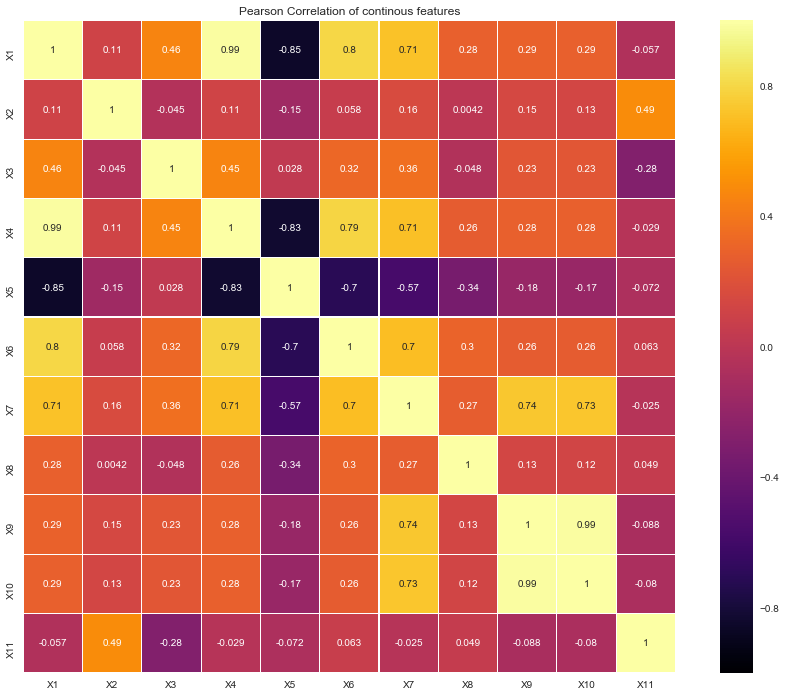

In [34]:
colormap = plt.cm.inferno
plt.figure(figsize=(16, 12))
plt.title('Pearson Correlation of continous features')
sns.heatmap(train_features.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

相关性分析: 

* 正向相关:
    * X1, X4/X6/X7
    * X4, X6/X7
    * X6, X7
    * X7, X9/X10
    * X9, X10
* 反向相关:
    * X1, X5
    * X4, X5
    * X5, X6/X7
* 其他(觉得用处不大, 暂时记录下)
    * X1, X3 0.46; X1, 8 9 10相关系数很接近在0.28,0,29

In [38]:
#train_int = train_int.drop(["id", "target"], axis=1)
# colormap = plt.cm.bone
# plt.figure(figsize=(21,16))
# plt.title('Pearson correlation of categorical features', y=1.05, size=15)
# sns.heatmap(train_cat.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=False)
data = [
    go.Heatmap(
        z=train_features.corr().values,
        x=train_features.columns.values,
        y=train_features.columns.values,
        colorscale='Viridis',
        reversescale = False,
        text = True ,
        opacity = 1.0 )
]

layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

### Binary features inspection

Another aspect of the data that we may want to inspect would be the columns that only contain binary values, i.e where values take on only either of the two values 1 or 0. Proceeding, we store all columns that contain these binary values and then generate a vertical plotly barplot of these binary values as follows:

In [72]:
bin_col = ['X1', 'X9', 'X11']
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train_features[col]==0).sum())
    one_list.append((train_features[col]==1).sum())

In [73]:
trace1 = go.Bar(
    x=bin_col,
    y=zero_list ,
    name='Zero count'
)
trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

### Mutual Information plots

Mutual information is another useful tool as it allows one to inspect the mutual information between the target variable and the corresponding feature it is calculated against. For classification problems, we can conveniently call Sklearn's mutual_info_classif method which measures the dependency between two random variables and ranges from zero (where the random variables are independent of each other) to higher values (indicate some dependency). This therefore will help give us an idea of how much information from the target may be contained within the features.

The sklearn implementation of the mutual_info_classif function tells us that it "relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances", where you can go into more detail on the official sklearn page in the [link](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif) here.

In [43]:
mf = mutual_info_classif(train_features.values,train_target.values,n_neighbors=3, random_state=17 )
print(mf)

[ 0.03302046  0.          0.          0.          0.          0.
  0.02076916  0.12029974  0.          0.00716094  0.        ]


### Feature importance via Random Forest

Let us now implement a Random Forest model where we fit the training data with a Random Forest Classifier and look at the ranking of the features after the model has finished training. This is a quick way of using an ensemble model (ensemble of weak decision tree learners applied under Bootstrap aggregated) which does not require much parameter tuning in obtaining useful feature importances and is also pretty robust to target imbalances. We call the Random Forest as follows:

In [65]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train_features, train_target)
features = train_features.columns.values
print("----- Training Done -----")

----- Training Done -----


### Plot.ly Scatter Plot of feature importances

Having trained the Random Forest, we can obtain the list of feature importances by invoking the attribute "featureimportances" and plot our next Plotly plot, the Scatter plot.

Here we invoke the command Scatter and as per the previous Plotly plots, we have to define our y and x-axes. However the one thing that we pay attention to in scatter plots is the marker attribute. It is the marker attribute where we define and hence control the size, color and scale of the scatter points embedded.

In [66]:
# Scatter plot 
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [67]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Random Forest Feature importances',
     width = 900, height = 500,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

### Decision Tree visualisation

One other interesting trick or technique often used would be to visualize the tree branches or decisions made by the model. For simplicity, I fit a decision tree (of max_depth = 3), use the export to graph visualization attribute in sklearn "export_graphviz" and then export and import the tree image for embedding into this notebook.

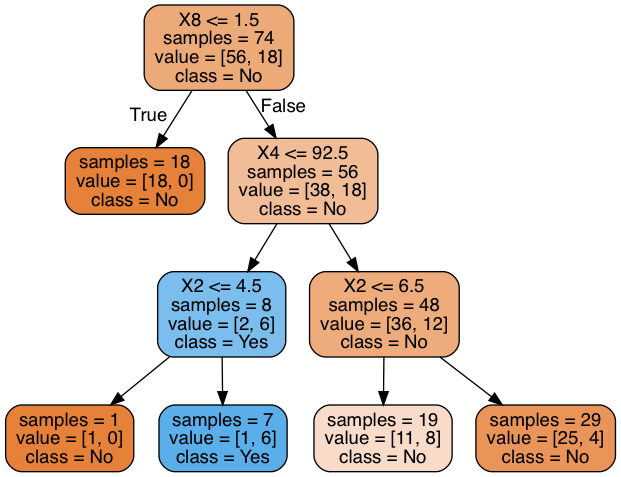

In [59]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(train_features, train_target)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 8,
                              impurity = False,
                              feature_names = train_features.columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png",)

### Feature importance via Gradient Boosting model

Just for curiosity, let us try another learning method in getting our feature importances. This time, we use a Gradient Boosting classifier to fit to the training data . Gradient Boosting proceeds in a forward stage-wise fashion, where at each stage regression tress are fitted on the gradient of the loss function (which defaults to the deviance in Sklearn implementation).

In [60]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train_features, train_target)
features = train_features.columns.values
print("----- Training Done -----")

----- Training Done -----


In [61]:
# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Machine Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [64]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Gradient Boosting Classifer Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Gradient Boosting Classifer Feature importances',
     width = 900, height = 500,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

In [14]:
# 前60行作为训练数据集
train_data = df[:60]
# 后边的数据作为测试数据
test_data = df[60:]

In [10]:
# 分离特征和标签，并获取数据维数
train_X = train_data[:, 1:]
train_y = train_data[:, 0:1]
feature_num = len(train_X[0])
sample_num = len(train_X)
print("Size of train_X: {}x{}".format(sample_num, feature_num))
print("Size of train_y: {}x{}".format(len(train_y), len(train_y[0])))

Size of train_X: 55x14
Size of train_y: 55x1


In [14]:
# 数据集
X = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

In [15]:
# 训练目标
W = tf.Variable(tf.zeros([feature_num, 1]))
b = tf.Variable([-.9])

In [16]:
db = tf.matmul(X, tf.reshape(W, [-1, 1])) + b
hyp = tf.sigmoid(db)

cost0 = y * tf.log(hyp)
cost1 = (1 - y) * tf.log(1 - hyp)
cost = (cost0 + cost1) / -sample_num
loss = tf.reduce_sum(cost)

In [17]:
optimizer = tf.train.GradientDescentOptimizer(0.001)
train = optimizer.minimize(loss)

In [18]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [19]:
feed_dict = {X: train_X, y: train_y}

for step in range(1000000):
    sess.run(train, {X: train_X, y: train_y})
    if step % 100 == 0:
        print(step, sess.run(W).flatten(), sess.run(b).flatten())

0 [  3.42482410e-04   9.91800684e-04   1.22574880e-03   7.84686476e-04
   3.62947409e-04   9.28442751e-04   1.66468835e-03   6.71189104e-04
   1.46596183e-04   4.97891102e-04   1.23158898e-04   4.19191376e-04
   5.65362789e-05   7.18780720e-05] [-0.89968902]
100 [ 0.01852635  0.04378271  0.06680475  0.03962544  0.00985298  0.04563949
  0.08225091  0.03153914  0.00599834  0.01354066  0.00463049  0.01922502
  0.00246252  0.00261896] [-0.88552469]
200 [  2.47371774e-02   4.51527275e-02   9.00120437e-02   4.90841940e-02
  -9.41699109e-05   5.46497330e-02   9.95471030e-02   3.56796086e-02
   5.61498245e-03   9.22824256e-04   3.41897295e-03   2.09653061e-02
   2.43945862e-03   1.69799407e-03] [-0.88388395]
300 [ 0.02883509  0.03989888  0.10580958  0.05355186 -0.01279326  0.05759443
  0.10641299  0.03538409  0.0044416  -0.01457432  0.0013224   0.01984671
  0.00197968  0.00015004] [-0.88432127]
400 [ 0.03241762  0.03362473  0.11984178  0.05697466 -0.02554917  0.05927771
  0.11133101  0.0342404

4000 [ 0.097386   -0.10684463  0.40679446  0.10712811 -0.27864295  0.0470966
  0.20284614 -0.00744644  0.01793214 -0.20963363 -0.04776322 -0.06042723
 -0.03278103 -0.08705488] [-0.91688097]
4100 [ 0.09834329 -0.10891985  0.4115831   0.10767893 -0.28244597  0.04614788
  0.2040775  -0.00800314  0.01880968 -0.2110192  -0.04840365 -0.06240317
 -0.03384427 -0.08968911] [-0.91763937]
4200 [ 0.09927867 -0.1109321   0.41627663  0.108211   -0.28615791  0.045193
  0.2052667  -0.00853037  0.01969083 -0.21234539 -0.04902041 -0.06435596
 -0.03490614 -0.09232536] [-0.91839123]
4300 [ 0.10019305 -0.11288346  0.42087817  0.10872533 -0.2897822   0.04423274
  0.20641519 -0.00902897  0.02057507 -0.21361585 -0.04961419 -0.06628549
 -0.03596631 -0.0949632 ] [-0.91913646]
4400 [ 0.1010873  -0.11477593  0.4253909   0.10922282 -0.29332227  0.04326781
  0.20752439 -0.00949983  0.02146192 -0.21483395 -0.05018566 -0.06819168
 -0.03702448 -0.09760199] [-0.91987509]
4500 [ 0.10196225 -0.11661144  0.42981771  0.109

8300 [ 0.12605011 -0.1581118   0.55412412  0.12147386 -0.38819599  0.00600948
  0.23037513 -0.01386075  0.05564908 -0.24088533 -0.06030212 -0.12571356
 -0.07463992 -0.19755976] [-0.94476527]
8400 [ 0.1265291  -0.15872368  0.5565908   0.12169712 -0.38988942  0.00511562
  0.23061755 -0.01376179  0.0564886  -0.24126405 -0.06034604 -0.12681688
 -0.07547839 -0.19998592] [-0.94532555]
8500 [ 0.12700294 -0.15932046  0.55902845  0.12191852 -0.39155787  0.00422602
  0.23084895 -0.01365751  0.05732581 -0.2416351  -0.06038263 -0.12790492
 -0.07630966 -0.20240338] [-0.94588006]
8600 [ 0.12747177 -0.1599025   0.56143755  0.12213827 -0.39320168  0.00334071
  0.23106965 -0.01354813  0.05816073 -0.24199872 -0.06041206 -0.12897795
 -0.07713373 -0.20481208] [-0.94643408]
8700 [ 0.12793578 -0.16047043  0.56381899  0.12235643 -0.39482144  0.0024597
  0.23127985 -0.01343394  0.05899333 -0.2423552  -0.0604345  -0.13003619
 -0.07795058 -0.20721196] [-0.94698244]
8800 [ 0.12839508 -0.16102454  0.5661732   0.1

13000 [ 0.14462152 -0.1762363   0.64619899  0.1312276  -0.44739202 -0.03125467
  0.2335121  -0.0062066   0.09272937 -0.25321907 -0.05660156 -0.1643618
 -0.10618009 -0.30162489] [-0.96822834]
13100 [ 0.14495556 -0.17647901  0.6477558   0.13143621 -0.44831422 -0.03194417
  0.23345737 -0.00601838  0.09346982 -0.2534034  -0.05643195 -0.16495539
 -0.10667991 -0.30361497] [-0.96867537]
13200 [ 0.14528769 -0.17671847  0.64929998  0.13164483 -0.44922599 -0.03262958
  0.23339957 -0.00583016  0.09420842 -0.25358519 -0.05625971 -0.16554175
 -0.1071729  -0.30559593] [-0.96912241]
13300 [ 0.14561813 -0.1769547   0.65083176  0.13185345 -0.45012754 -0.03331085
  0.23333889 -0.00564193  0.09494527 -0.25376478 -0.0560849  -0.16612099
 -0.10765912 -0.30756781] [-0.96956742]
13400 [ 0.14594689 -0.17718792  0.65235108  0.13206311 -0.45101911 -0.03398816
  0.23327515 -0.00545383  0.09568033 -0.25394303 -0.05590759 -0.16669324
 -0.10813861 -0.30953065] [-0.97000849]
13500 [ 0.14627402 -0.17741826  0.6538580

17300 [ 0.15772773 -0.18470746  0.70339668  0.14060275 -0.4793306  -0.05748073
  0.22913156  0.00158873  0.12310141 -0.25970933 -0.04745854 -0.18453641
 -0.12190462 -0.37938052] [-0.9860968]
17400 [ 0.15800853 -0.18487436  0.70452589  0.14083074 -0.47992015 -0.05801397
  0.22899596  0.00175822  0.12377592 -0.2598345  -0.0472114  -0.18490027
 -0.12213985 -0.38101029] [-0.98648423]
17500 [ 0.15828867 -0.18504022  0.70564789  0.14105873 -0.48050401 -0.05854395
  0.22885999  0.00192713  0.12444913 -0.25995967 -0.04696308 -0.18526039
 -0.12236965 -0.38263229] [-0.98687166]
17600 [ 0.15856773 -0.18520562  0.70676118  0.14128812 -0.48108241 -0.05907089
  0.22872268  0.00209529  0.12512118 -0.26008204 -0.04671363 -0.18561675
 -0.12259404 -0.38424706] [-0.98725313]
17700 [ 0.15884638 -0.18537036  0.70786721  0.14151759 -0.48165542 -0.05959475
  0.2285841   0.00226276  0.12579173 -0.26020423 -0.04646306 -0.18596955
 -0.12281307 -0.38585418] [-0.9876346]
17800 [ 0.15912358 -0.18553427  0.70896596

21600 [ 0.16916858 -0.19138548  0.74577147  0.15068653 -0.5003587  -0.07778738
  0.22274412  0.00827291  0.15106755 -0.26446131 -0.03599986 -0.19730963
 -0.12749563 -0.44316682] [-1.0017705]
21700 [ 0.1694219  -0.191533    0.74662393  0.15092626 -0.50075805 -0.07820141
  0.22258766  0.00841379  0.15169525 -0.26455966 -0.03571795 -0.19754864
 -0.127525   -0.44450945] [-1.0021162]
21800 [ 0.16967516 -0.19167957  0.74747115  0.15116617 -0.50115466 -0.07861304
  0.2224312   0.00855405  0.15232243 -0.264658   -0.03543546 -0.19778538
 -0.12755024 -0.44584623] [-1.00246191]
21900 [ 0.16992699 -0.19182588  0.74831313  0.15140608 -0.50154805 -0.07902237
  0.22227474  0.00869363  0.15294828 -0.26475635 -0.03515252 -0.19802004
 -0.1275713  -0.44717726] [-1.00280762]
22000 [ 0.17017882 -0.19197191  0.7491501   0.15164599 -0.50193745 -0.07942928
  0.22211827  0.00883261  0.1535735  -0.2648547  -0.0348691  -0.19825256
 -0.12758829 -0.44850251] [-1.00315332]
22100 [ 0.17043065 -0.19211794  0.749982  

26100 [ 0.18015951 -0.19779308  0.7794174   0.16146617 -0.51543796 -0.09426919
  0.21569932  0.01400344  0.17851111 -0.26855329 -0.02294274 -0.20624065
 -0.12508154 -0.49831128] [-1.01657462]
26200 [ 0.18039547 -0.19793166  0.78006709  0.16170396 -0.51571375 -0.09459031
  0.21554434  0.01411734  0.17910418 -0.26863673 -0.02264683 -0.20640337
 -0.12494941 -0.4994252 ] [-1.01688457]
26300 [ 0.18063091 -0.19807021  0.78071171  0.16194089 -0.51598793 -0.09490969
  0.21538998  0.01423072  0.17969657 -0.26872018 -0.02235078 -0.20656486
 -0.12481428 -0.50053507] [-1.01719451]
26400 [ 0.18086635 -0.19820799  0.78135395  0.16217782 -0.51626211 -0.09522725
  0.21523604  0.01434356  0.18028815 -0.26880363 -0.02205462 -0.20672509
 -0.1246761  -0.50164038] [-1.01750445]
26500 [ 0.18110178 -0.19834508  0.78199172  0.16241474 -0.51653051 -0.09554314
  0.21508221  0.01445582  0.18087938 -0.26888707 -0.02175828 -0.20688416
 -0.12453491 -0.50274199] [-1.0178144]
26600 [ 0.18133722 -0.19848217  0.7826253

30600 [ 0.19052669 -0.20382045  0.80521041  0.17195101 -0.52596718 -0.10710797
  0.20897537  0.01863209  0.20460634 -0.27216887 -0.00956479 -0.21244563
 -0.11638458 -0.54449922] [-1.03021157]
30700 [ 0.1907517  -0.20395009  0.80571109  0.17217751 -0.52616388 -0.10735922
  0.20883232  0.01872416  0.20517407 -0.27224636 -0.00926772 -0.21256101
 -0.11613359 -0.54544109] [-1.03049767]
30800 [ 0.19097671 -0.20407973  0.80620956  0.17240401 -0.52635568 -0.10760938
  0.20868924  0.01881555  0.20574079 -0.27232385 -0.00897077 -0.21267575
 -0.11588037 -0.54638201] [-1.03078377]
30900 [ 0.19120172 -0.20420937  0.80670428  0.1726305  -0.52654642 -0.10785828
  0.20854619  0.01890649  0.20630704 -0.27240133 -0.00867391 -0.21278964
 -0.11562493 -0.5473178 ] [-1.03106987]
31000 [ 0.19142672 -0.20433901  0.80719769  0.17285573 -0.52673715 -0.10810591
  0.20840314  0.01899696  0.20687328 -0.27247882 -0.00837714 -0.21290289
 -0.11536727 -0.54825187] [-1.03135598]
31100 [ 0.19165173 -0.20446721  0.807686

35100 [ 0.20048131 -0.20944637  0.8252033   0.18180434 -0.53339112 -0.11720652
  0.20281392  0.02236293  0.22969532 -0.27555403  0.003681   -0.2169148
 -0.10306877 -0.5839904 ] [-1.04291809]
35200 [ 0.20069887 -0.20956707  0.82559294  0.18201445 -0.53352821 -0.11740531
  0.20268428  0.0224369   0.23024368 -0.27562693  0.00397151 -0.21699974
 -0.10273051 -0.58480698] [-1.04319227]
35300 [ 0.20091642 -0.20968714  0.82598037  0.18222456 -0.5336653  -0.117603
  0.20255464  0.02251058  0.2307916  -0.27569878  0.00426184 -0.21708338
 -0.10239059 -0.58561885] [-1.04346645]
35400 [ 0.20113398 -0.20980635  0.8263678   0.1824338  -0.53380239 -0.11779977
  0.202425    0.02258385  0.23133847 -0.27577162  0.00455195 -0.21716683
 -0.10204905 -0.58642948] [-1.04374063]
35500 [ 0.20135154 -0.20992556  0.82675087  0.18264242 -0.53393608 -0.11799539
  0.20229569  0.02265683  0.23188534 -0.27584356  0.00484185 -0.21725003
 -0.10170582 -0.58723813] [-1.04401481]
35600 [ 0.2015691  -0.21004477  0.82713234 

39600 [ 0.21014653 -0.21463479  0.84083474  0.19085239 -0.53859264 -0.12521105
  0.19726248  0.0253699   0.25399628 -0.27878597  0.01652651 -0.22022653
 -0.08636086 -0.61846298] [-1.05501676]
39700 [ 0.21035813 -0.21474506  0.84113914  0.19104312 -0.538688   -0.125369
  0.19714613  0.02542969  0.25452974 -0.2788575   0.01680607 -0.22029008
 -0.08595844 -0.61918402] [-1.05527902]
39800 [ 0.21056972 -0.21485533  0.84144312  0.19123386 -0.53878337 -0.12552559
  0.19703008  0.02548937  0.25506321 -0.27892902  0.0170854  -0.22035266
 -0.08555482 -0.61989927] [-1.05554128]
39900 [ 0.21078132 -0.2149656   0.84174711  0.19142459 -0.53887874 -0.12568206
  0.19691528  0.0255487   0.25559372 -0.27900055  0.01736445 -0.22041525
 -0.08514994 -0.62061453] [-1.05580354]
40000 [ 0.21099292 -0.21507587  0.84205079  0.19161509 -0.53897369 -0.12583722
  0.1968001   0.0256076   0.2561242  -0.27907208  0.01764319 -0.22047783
 -0.08474392 -0.62132978] [-1.0560658]
40100 [ 0.21120451 -0.21518476  0.84234881 

44100 [ 0.21960101 -0.21938553  0.8531431   0.19904096 -0.54214495 -0.13158785
  0.19231409  0.02779283  0.27766711 -0.28197941  0.02881668 -0.22273646
 -0.06716193 -0.64914656] [-1.06664526]
44200 [ 0.21980962 -0.21948686  0.85338706  0.19921266 -0.54221052 -0.13171451
  0.19220978  0.02784079  0.27818567 -0.28204933  0.02908274 -0.22278564
 -0.06671243 -0.64979112] [-1.0668956]
44300 [ 0.22001824 -0.21958712  0.85362548  0.19938402 -0.54227608 -0.1318398
  0.19210631  0.02788866  0.27870423 -0.28211787  0.0293485  -0.22283405
 -0.06626206 -0.65043485] [-1.06714594]
44400 [ 0.22022685 -0.21968696  0.85386389  0.19955538 -0.54233605 -0.13196497
  0.19200301  0.02793626  0.27922279 -0.28218836  0.02961393 -0.22288173
 -0.06581083 -0.65107858] [-1.06739628]
44500 [ 0.22043478 -0.21978679  0.85410231  0.19972634 -0.54239565 -0.13208972
  0.19190016  0.02798353  0.27974135 -0.28225967  0.02987903 -0.22292942
 -0.06535874 -0.65172231] [-1.06764662]
44600 [ 0.22064191 -0.21988663  0.85434073

48600 [ 0.22889853 -0.22371508  0.86289555  0.20638534 -0.544447   -0.13668464
  0.18788633  0.02974814  0.30079147 -0.28511885  0.04047184 -0.22468461
 -0.04613589 -0.67693669] [-1.07791054]
48700 [ 0.22910416 -0.22380598  0.86308628  0.20653957 -0.54448873 -0.136785
  0.18779394  0.02978715  0.30130011 -0.28518739  0.04072335 -0.22472318
 -0.04565189 -0.67752677] [-1.07816088]
48800 [ 0.2293098  -0.22389688  0.86327702  0.20669305 -0.54452789 -0.13688484
  0.18770155  0.02982604  0.30180675 -0.28525651  0.04097454 -0.22476043
 -0.04516724 -0.67811686] [-1.07841122]
48900 [ 0.22951543 -0.22398777  0.86346775  0.20684654 -0.54456365 -0.13698468
  0.18760917  0.02986468  0.30231339 -0.28532678  0.04122539 -0.22479768
 -0.04468197 -0.67870694] [-1.07866156]
49000 [ 0.22972107 -0.22407867  0.86365849  0.207      -0.54459941 -0.13708358
  0.18751678  0.02990307  0.30282003 -0.28539765  0.0414759  -0.22483493
 -0.04419602 -0.67929351] [-1.0789119]
49100 [ 0.22992671 -0.22416957  0.86384922 

53100 [ 0.23808526 -0.22765678  0.87065762  0.21293698 -0.54579955 -0.14075744
  0.18391879  0.03131987  0.32342857 -0.28824741  0.05145846 -0.2262307
 -0.02377505 -0.70250702] [-1.08877659]
53200 [ 0.23828791 -0.22774023  0.87081259  0.21307407 -0.54582208 -0.14083791
  0.18383534  0.03135116  0.32392627 -0.28831694  0.05169497 -0.22626199
 -0.02326598 -0.70305538] [-1.08901501]
53300 [ 0.23849057 -0.22782367  0.87096757  0.21321116 -0.54583997 -0.14091837
  0.1837519   0.0313821   0.32442397 -0.28838775  0.05193112 -0.22629328
 -0.02275644 -0.70360374] [-1.08925343]
53400 [ 0.23869322 -0.22790712  0.87112111  0.2133473  -0.54585785 -0.14099884
  0.18366845  0.0314129   0.32492167 -0.28845778  0.05216693 -0.22632433
 -0.02224644 -0.70414925] [-1.08949184]
53500 [ 0.23889588 -0.22799057  0.87127012  0.2134829  -0.54587573 -0.14107786
  0.18358505  0.03144382  0.32541937 -0.28852633  0.0524024  -0.22635414
 -0.02173597 -0.70469165] [-1.08973026]
53600 [ 0.23909853 -0.22807401  0.8714191

57600 [  2.47181296e-01  -2.31244192e-01   8.76886308e-01   2.18780965e-01
  -5.46399772e-01  -1.44001886e-01   1.80345446e-01   3.25891711e-02
   3.45628202e-01  -2.91365355e-01   6.17766567e-02  -2.27485567e-01
  -4.45698097e-04  -7.26348460e-01] [-1.09950542]
57700 [  2.47382462e-01  -2.31320187e-01   8.77011478e-01   2.18903154e-01
  -5.46405733e-01  -1.44065961e-01   1.80269450e-01   3.26144472e-02
   3.46116960e-01  -2.91434467e-01   6.19984753e-02  -2.27510899e-01
   8.14596060e-05  -7.26861060e-01] [-1.09974384]
57800 [  2.47583628e-01  -2.31396183e-01   8.77136648e-01   2.19025344e-01
  -5.46411693e-01  -1.44130036e-01   1.80193886e-01   3.26394066e-02
   3.46605718e-01  -2.91503906e-01   6.22199886e-02  -2.27536231e-01
   6.08948525e-04  -7.27373660e-01] [-1.09998226]
57900 [ 0.24778479 -0.23147218  0.87726182  0.21914753 -0.54641765 -0.1441934
  0.18011869  0.03266437  0.34709448 -0.2915743   0.06244117 -0.22756156
  0.00113676 -0.72788626] [-1.10022068]
58000 [ 0.24798596 -

61900 [ 0.25578824 -0.23437583  0.88171524  0.22378413 -0.54644984 -0.14645846
  0.17725201  0.03357113  0.36645859 -0.29434219  0.07102989 -0.22848779
  0.0224967  -0.74785632] [-1.10967946]
62000 [ 0.25598791 -0.23444587  0.88181657  0.2238944  -0.54644388 -0.14650913
  0.17718197  0.03359125  0.36693841 -0.29441193  0.07123817 -0.22850868
  0.02303615 -0.74834508] [-1.10990596]
62100 [ 0.25618759 -0.23451591  0.88191789  0.22400336 -0.54643792 -0.14655979
  0.17711194  0.03361132  0.36741823 -0.29448095  0.07144604 -0.22852954
  0.02357583 -0.74883384] [-1.11013246]
62200 [ 0.25638726 -0.23458594  0.88201922  0.22411214 -0.54643196 -0.14661045
  0.1770419   0.03363106  0.36789805 -0.2945497   0.07165387 -0.2285504
  0.02411573 -0.74932259] [-1.11035895]
62300 [ 0.25658694 -0.23465598  0.88212055  0.22422092 -0.546426   -0.14666112
  0.17697233  0.0336508   0.36837786 -0.29461896  0.071861   -0.22857127
  0.02465587 -0.74981135] [-1.11058545]
62400 [ 0.25678661 -0.23472601  0.8822208

66500 [ 0.26497331 -0.23746848  0.88589025  0.2285666  -0.54604495 -0.14854228
  0.17420316  0.03440794  0.38834932 -0.29750538  0.08030152 -0.22940663
  0.04752972 -0.76977074] [-1.12009835]
66600 [ 0.26517299 -0.23753256  0.88597369  0.22866495 -0.54603302 -0.14858252
  0.17413908  0.03442396  0.3888202  -0.29757392  0.08049598 -0.22942451
  0.0480781  -0.77023566] [-1.12032485]
66700 [ 0.26537266 -0.23759663  0.88605714  0.2287633  -0.5460211  -0.14862275
  0.17407501  0.03443998  0.38929108 -0.29764247  0.08069044 -0.22944239
  0.04862684 -0.77070057] [-1.12055135]
66800 [ 0.26557234 -0.23766071  0.8861382   0.22886164 -0.54600918 -0.14866218
  0.17401095  0.034456    0.38976195 -0.29771101  0.08088453 -0.22946027
  0.04917558 -0.77116549] [-1.12077785]
66900 [ 0.26577201 -0.23772478  0.8862161   0.22895999 -0.54599726 -0.14870092
  0.17394835  0.03447201  0.39023283 -0.29777956  0.08107825 -0.22947815
  0.0497246  -0.77163041] [-1.12100434]
67000 [ 0.26597169 -0.23778808  0.886293

71000 [ 0.2739422  -0.24023755  0.88920552  0.23277426 -0.54531026 -0.15011242
  0.17145975  0.03506604  0.40939301 -0.30058992  0.08878556 -0.23018123
  0.07235049 -0.79032141] [-1.13029075]
71100 [ 0.2741389  -0.24029566  0.88927108  0.23286366 -0.54529238 -0.15014222
  0.17140163  0.03507908  0.40985751 -0.30065846  0.08896803 -0.23019762
  0.07290482 -0.79076844] [-1.13051724]
71200 [ 0.27433559 -0.24035378  0.88933665  0.23295254 -0.5452745  -0.15017202
  0.17134352  0.03509212  0.41031945 -0.30072701  0.08914983 -0.23021401
  0.07345914 -0.79121548] [-1.13074374]
71300 [ 0.27453253 -0.24041189  0.88940221  0.23304045 -0.54525661 -0.15020183
  0.17128541  0.03510515  0.41078138 -0.30079556  0.08933162 -0.23023041
  0.07401346 -0.79166251] [-1.13097024]
71400 [ 0.27473098 -0.24047001  0.88946778  0.23312837 -0.54523873 -0.15023163
  0.17122778  0.03511819  0.41124332 -0.3008641   0.08951331 -0.2302468
  0.07456779 -0.79210955] [-1.13119674]
71500 [ 0.27492768 -0.24052812  0.8895333

75400 [ 0.28259879 -0.24273384  0.89187062  0.23650482 -0.54431266 -0.15126991
  0.16898498  0.03558072  0.42961714 -0.30360168  0.09656023 -0.2308618
  0.09681839 -0.80972368] [-1.14025664]
75500 [ 0.28279549 -0.24278748  0.89192426  0.23658529 -0.54428881 -0.15129226
  0.16893134  0.03559116  0.43007311 -0.30366981  0.09673135 -0.2308767
  0.09737591 -0.81015879] [-1.14048314]
75600 [ 0.28299218 -0.24284112  0.89197791  0.23666576 -0.54426497 -0.15131462
  0.16887769  0.03560159  0.43052909 -0.30373788  0.09690197 -0.2308916
  0.09793396 -0.8105939 ] [-1.14070964]
75700 [ 0.28318888 -0.24289477  0.89203155  0.23674622 -0.54424113 -0.15133697
  0.16882405  0.03561202  0.43098506 -0.30380595  0.09707259 -0.2309065
  0.09849201 -0.81102902] [-1.14093614]
75800 [ 0.28338557 -0.24294841  0.89208519  0.23682669 -0.54421729 -0.15135932
  0.1687704   0.03562245  0.43144104 -0.30387396  0.09724292 -0.2309214
  0.09905006 -0.81146413] [-1.14116263]
75900 [ 0.28358227 -0.24300206  0.89213884  0

79800 [ 0.29125339 -0.24504627  0.89408922  0.23990551 -0.54312366 -0.15211904
  0.16665931  0.03598817  0.4495168  -0.30658123  0.10385755 -0.23148423
  0.12139188 -0.82855529] [-1.15022254]
79900 [ 0.29145008 -0.24509694  0.89413691  0.23997852 -0.54309386 -0.15213543
  0.16660716  0.03599601  0.44996384 -0.30664808  0.10401822 -0.23149765
  0.12195101 -0.82897848] [-1.15044904]
80000 [ 0.29164678 -0.2451476   0.8941834   0.24005154 -0.54306406 -0.15215182
  0.166555    0.03600402  0.45041087 -0.30671418  0.10417841 -0.23151106
  0.12251055 -0.82940167] [-1.15067554]
80100 [ 0.29184347 -0.24519826  0.89422905  0.24012455 -0.54303426 -0.15216821
  0.16650285  0.03601222  0.45085791 -0.30677974  0.10433859 -0.23152447
  0.12307009 -0.82982486] [-1.15090203]
80200 [ 0.29204017 -0.24524893  0.8942734   0.24019757 -0.54300445 -0.15218461
  0.16645156  0.03602041  0.45130494 -0.30684531  0.10449878 -0.23153788
  0.12362963 -0.83024806] [-1.15112853]
80300 [ 0.29223686 -0.24529959  0.894316

84200 [ 0.29990798 -0.24719985  0.8959204   0.24303089 -0.54181236 -0.15269871
  0.16446307  0.0363161   0.46907225 -0.30951542  0.11071953 -0.23207343
  0.1460038  -0.84691179] [-1.16018844]
84300 [ 0.30010468 -0.24724604  0.89595616  0.24309944 -0.54178256 -0.15270914
  0.16441517  0.03632281  0.46951333 -0.30958173  0.11087078 -0.23208606
  0.14656259 -0.84732306] [-1.16041493]
84400 [ 0.30030137 -0.24729224  0.89599192  0.24316798 -0.54175276 -0.15271957
  0.16436748  0.03632952  0.4699544  -0.30964854  0.11102203 -0.23209871
  0.14712138 -0.84773433] [-1.16064143]
84500 [ 0.30049807 -0.24733843  0.89602768  0.24323653 -0.54172295 -0.15273
  0.1643198   0.03633622  0.47039548 -0.30971527  0.11117256 -0.23211125
  0.14768018 -0.8481456 ] [-1.16086793]
84600 [ 0.30069476 -0.24738462  0.89606345  0.24330507 -0.54169315 -0.15274043
  0.16427211  0.03634293  0.47083655 -0.30978203  0.11132307 -0.2321237
  0.14823897 -0.84855688] [-1.16109443]
84700 [ 0.30089146 -0.24743082  0.89609921  

88700 [ 0.30875927 -0.24925837  0.89745969  0.2459866  -0.54024863 -0.15306666
  0.16232203  0.03657764  0.48873973 -0.31249568  0.11732268 -0.2326268
  0.17114951 -0.86526608] [-1.17038083]
88800 [ 0.30895597 -0.24930198  0.89748949  0.24605067 -0.54021287 -0.15307263
  0.16227584  0.03658285  0.48917186 -0.31256124  0.11746499 -0.23263872
  0.1717083  -0.8656714 ] [-1.17060733]
88900 [ 0.30915266 -0.24934554  0.89751929  0.24611452 -0.54017711 -0.15307859
  0.16222964  0.03658807  0.489604   -0.31262681  0.1176073  -0.23265064
  0.17226709 -0.86607671] [-1.17083383]
89000 [ 0.30934936 -0.24938875  0.89754909  0.24617711 -0.54014134 -0.15308455
  0.16218345  0.03659328  0.49003613 -0.31269237  0.11774941 -0.23266256
  0.17282589 -0.86648202] [-1.17106032]
89100 [ 0.30954605 -0.24943197  0.8975789   0.24623969 -0.54010558 -0.15308931
  0.16213726  0.0365985   0.49046826 -0.31275794  0.11789097 -0.23267448
  0.17338468 -0.86688733] [-1.17128682]
89200 [ 0.30974275 -0.24947518  0.8976087

93300 [ 0.31780726 -0.25120962  0.89880002  0.24879164 -0.53860354 -0.153236
  0.1602108   0.03678285  0.5085144  -0.31551439  0.1236783  -0.23317516
  0.19681141 -0.88364661] [-1.18079972]
93400 [ 0.31800395 -0.25125134  0.89882416  0.24885124 -0.53856778 -0.15323749
  0.16016759  0.03678707  0.5089376  -0.31557995  0.12381241 -0.23318708
  0.19736871 -0.88404   ] [-1.18102622]
93500 [ 0.31820065 -0.25129306  0.89884835  0.24891084 -0.53853202 -0.15323898
  0.16012438  0.03679125  0.50936079 -0.31564552  0.12394653 -0.233199
  0.19792601 -0.88443339] [-1.18125272]
93600 [ 0.31839734 -0.25133479  0.89887249  0.24897045 -0.53849626 -0.15324047
  0.16008116  0.03679547  0.50978398 -0.31571108  0.12408037 -0.23321092
  0.19848332 -0.88482678] [-1.18147922]
93700 [ 0.31859404 -0.25137651  0.89889675  0.24903005 -0.53846049 -0.1532419
  0.16003795  0.03679967  0.51020718 -0.31577665  0.12421374 -0.23322284
  0.19904062 -0.88522017] [-1.18170571]
93800 [ 0.31879073 -0.25141823  0.8989206   0

97600 [ 0.32619098 -0.252942    0.89982659  0.25126699 -0.53706574 -0.15322635
  0.15835263  0.03692891  0.52667069 -0.31831157  0.12929018 -0.23368776
  0.22070904 -0.90050894] [-1.19044685]
97700 [ 0.32638469 -0.25298074  0.89985043  0.25132081 -0.53702998 -0.15322486
  0.15830941  0.03693152  0.52708793 -0.31837538  0.12941684 -0.23369968
  0.22126336 -0.90089637] [-1.19066763]
97800 [ 0.32657841 -0.25301948  0.89987427  0.25137445 -0.53699422 -0.15322337
  0.1582662   0.03693413  0.52750516 -0.31843936  0.1295435  -0.2337116
  0.22181769 -0.9012838 ] [-1.19088733]
97900 [ 0.32677212 -0.25305822  0.89989811  0.2514281  -0.53695846 -0.15322188
  0.15822299  0.03693674  0.52792239 -0.31850335  0.12967016 -0.23372352
  0.22237201 -0.90167123] [-1.19110692]
98000 [ 0.32696584 -0.25309697  0.89992195  0.25148174 -0.53692269 -0.15322039
  0.15817977  0.03693929  0.52833962 -0.31856734  0.12979682 -0.23373544
  0.22292633 -0.90205866] [-1.1913265]
98100 [ 0.32715955 -0.25313571  0.8999458 

102300 [ 0.33529559 -0.25476292  0.90077543  0.25377882 -0.5352791  -0.15310279
  0.15634583  0.0370374   0.5461812  -0.32129231  0.13509102 -0.23421666
  0.24669768 -0.91864324] [-1.20058835]
102400 [ 0.3354893  -0.25480166  0.90079331  0.25382948 -0.53523856 -0.15309832
  0.15630411  0.03703932  0.54659247 -0.32135522  0.13521135 -0.23422709
  0.24724902 -0.91902471] [-1.20080292]
102500 [ 0.33568302 -0.2548404   0.9008112   0.25388014 -0.53519809 -0.15309384
  0.15626238  0.03704137  0.54700375 -0.32141808  0.13533056 -0.23423752
  0.24780037 -0.91940618] [-1.2010175]
102600 [ 0.33587673 -0.25487792  0.90082908  0.25393081 -0.53515893 -0.15308937
  0.15622066  0.03704327  0.54741502 -0.32148129  0.13544977 -0.23424809
  0.24835171 -0.91978765] [-1.20123208]
102700 [ 0.33607045 -0.25491482  0.90084696  0.25398147 -0.53512013 -0.1530849
  0.15617894  0.03704513  0.54782629 -0.32154459  0.13556898 -0.23425947
  0.24890305 -0.92016912] [-1.20144665]
102800 [ 0.33626416 -0.25495148  0.90

107000 [ 0.3444002  -0.25645974  0.90161586  0.25613251 -0.5334397  -0.15287399
  0.15437824  0.03710729  0.56535643 -0.32424563  0.14057931 -0.23474783
  0.27252835 -0.93650842] [-1.21067345]
107100 [ 0.34459391 -0.25649551  0.90163374  0.2561802  -0.53340024 -0.15286803
  0.15433651  0.03710869  0.56576174 -0.32430822  0.14069256 -0.23475826
  0.27307671 -0.93688393] [-1.21088803]
107200 [ 0.34478763 -0.25653127  0.90165073  0.25622788 -0.53335947 -0.15286207
  0.15429479  0.03711015  0.56616706 -0.3243708   0.14080581 -0.23476869
  0.27362508 -0.93725944] [-1.2111026]
107300 [ 0.34498134 -0.25656703  0.90166724  0.25627556 -0.53331774 -0.15285611
  0.15425307  0.03711164  0.56657237 -0.32443339  0.14091906 -0.23477912
  0.27417344 -0.93763494] [-1.21131718]
107400 [ 0.34517506 -0.25660279  0.90168369  0.25632325 -0.53327602 -0.15285015
  0.15421134  0.03711313  0.56697768 -0.32449597  0.14103231 -0.23478955
  0.2747218  -0.93801045] [-1.21153176]
107500 [ 0.34536877 -0.25663856  0.9

111500 [ 0.35311738 -0.25801274  0.90220422  0.25827828 -0.53156537 -0.15255082
  0.15256654  0.03716501  0.58341718 -0.32703683  0.14557795 -0.23521774
  0.2970989  -0.95337391] [-1.2203294]
111600 [ 0.35331109 -0.25804648  0.90221614  0.25832596 -0.53152364 -0.1525424
  0.1525263   0.03716575  0.58381653 -0.3270984   0.14568673 -0.23522869
  0.29764429 -0.95374346] [-1.22054398]
111700 [ 0.35350481 -0.2580803   0.90222806  0.25837365 -0.53148192 -0.15253398
  0.15248607  0.0371665   0.58421588 -0.32716003  0.14579551 -0.23523962
  0.29818967 -0.95411301] [-1.22075856]
111800 [ 0.35369852 -0.25811377  0.90223998  0.25842133 -0.53144163 -0.15252514
  0.15244584  0.03716724  0.58461523 -0.32722148  0.14590326 -0.23525061
  0.29873359 -0.95448256] [-1.22097313]
111900 [ 0.35389224 -0.25814706  0.9022519   0.25846902 -0.5314014  -0.1525162
  0.1524056   0.03716799  0.58501458 -0.32728302  0.14601055 -0.23526168
  0.29927599 -0.9548521 ] [-1.22118771]
112000 [ 0.35408595 -0.25818035  0.902

115800 [ 0.36144713 -0.25942877  0.90271682  0.26025212 -0.52980924 -0.15216751
  0.15086932  0.03718477  0.60039186 -0.32965159  0.15013099 -0.23568572
  0.32040808 -0.96926451] [-1.2295562]
115900 [ 0.36164084 -0.25946155  0.90272874  0.26029682 -0.52976787 -0.15215857
  0.15083058  0.03718515  0.60078526 -0.3297123   0.15023382 -0.23569638
  0.3209475  -0.96963406] [-1.22977078]
116000 [ 0.36183456 -0.25949433  0.90274066  0.26034153 -0.52972651 -0.15214963
  0.15079184  0.03718552  0.60117865 -0.32977298  0.15033664 -0.235707
  0.32148692 -0.9700036 ] [-1.22998536]
116100 [ 0.36202827 -0.25952712  0.90275258  0.26038623 -0.52968562 -0.1521403
  0.1507531   0.03718589  0.60157204 -0.32983375  0.15043946 -0.23571782
  0.32202634 -0.97037315] [-1.23019993]
116200 [ 0.36222199 -0.2595599   0.9027645   0.26043093 -0.52964544 -0.1521299
  0.15071435  0.03718626  0.60196543 -0.32989466  0.15054227 -0.23572938
  0.32256576 -0.9707427 ] [-1.23041451]
116300 [ 0.3624157  -0.25959268  0.90277

120300 [ 0.37007678 -0.26088938  0.90325326  0.26226377 -0.52801812 -0.15170224
  0.14912589  0.03719922  0.61786371 -0.33234823  0.15469138 -0.23617052
  0.34461981 -0.98567694] [-1.23921216]
120400 [ 0.37026751 -0.26092044  0.90326518  0.26230848 -0.52797902 -0.15169181
  0.14908715  0.03719922  0.61825114 -0.33240822  0.15479122 -0.23618178
  0.34515625 -0.98604053] [-1.23942673]
120500 [ 0.37045825 -0.26095134  0.9032771   0.26235318 -0.52793986 -0.15168138
  0.1490484   0.03719922  0.61863738 -0.33246809  0.15489018 -0.23619291
  0.34569269 -0.98640412] [-1.23964131]
120600 [ 0.37064898 -0.26098165  0.90328902  0.26239789 -0.52790058 -0.15167095
  0.14900966  0.03719922  0.61901885 -0.3325277   0.15498853 -0.2362041
  0.34622914 -0.98676771] [-1.23985589]
120700 [ 0.37083972 -0.26101202  0.90330094  0.26244259 -0.52786118 -0.15166052
  0.14897092  0.03719922  0.61940032 -0.3325873   0.15508687 -0.23621523
  0.34676558 -0.9871313 ] [-1.24007046]
120800 [ 0.37103045 -0.26104197  0.9

124800 [ 0.37865984 -0.26223406  0.90366465  0.26416573 -0.52615219 -0.15118726
  0.14743727  0.03720174  0.63504058 -0.33503109  0.15906093 -0.23664643
  0.36864737 -1.00193155] [-1.24886811]
124900 [ 0.37885058 -0.26226386  0.90367109  0.26420745 -0.52611047 -0.15117534
  0.1474015   0.03720174  0.63542205 -0.3350907   0.15915629 -0.23665686
  0.36917785 -1.00228918] [-1.24908268]
125000 [ 0.37904131 -0.26229367  0.9036783   0.26424918 -0.52606875 -0.15116341
  0.14736573  0.03720174  0.6357981  -0.3351503   0.15925166 -0.23666729
  0.36970833 -1.0026468 ] [-1.24929726]
125100 [ 0.37923205 -0.26232347  0.90368521  0.2642909  -0.52602702 -0.15115149
  0.14732997  0.03720174  0.63617361 -0.33520922  0.15934703 -0.23667772
  0.37023881 -1.00300443] [-1.24951184]
125200 [ 0.37942278 -0.26235327  0.90369177  0.26433262 -0.5259853  -0.15113957
  0.14729421  0.03720174  0.63654912 -0.33526763  0.15944239 -0.23668815
  0.37076929 -1.00336206] [-1.24972641]
125300 [ 0.37961352 -0.26238307  0.

129200 [ 0.38705218 -0.26354536  0.90395212  0.26600155 -0.52431637 -0.15061679
  0.14586332  0.0371906   0.65156037 -0.33760118  0.16316633 -0.2371134
  0.39194453 -1.01766717] [-1.2583456]
129300 [ 0.38724291 -0.26357427  0.9039591   0.26604328 -0.52427465 -0.15060338
  0.14582756  0.03719022  0.65192991 -0.33765861  0.16325723 -0.23712429
  0.39247203 -1.0180248 ] [-1.258564]
129400 [ 0.38743365 -0.26360205  0.90396643  0.266085   -0.52423292 -0.15058997
  0.1457918   0.03718985  0.65229946 -0.33771607  0.16334812 -0.23713537
  0.39299953 -1.01838243] [-1.25878668]
129500 [ 0.38762438 -0.2636295   0.90397376  0.26612672 -0.5241912  -0.15057656
  0.14575604  0.03718948  0.65266901 -0.33777356  0.16343902 -0.23714645
  0.39352703 -1.01874006] [-1.25901067]
129600 [ 0.38781512 -0.26365668  0.90398127  0.26616845 -0.52414948 -0.15056315
  0.14572027  0.03718911  0.65303856 -0.33783108  0.16352992 -0.23715749
  0.39405453 -1.01909769] [-1.2592361]
129700 [ 0.38800585 -0.26368394  0.90398

  0.41455886 -1.03285158] [-1.26806676]
133600 [ 0.39544451 -0.26474196  0.9042592   0.26783609 -0.52248055 -0.14999792
  0.14428976  0.03717728  0.66779947 -0.34013179  0.16711172 -0.23758964
  0.41508338 -1.03319728] [-1.26829326]
133700 [ 0.39563525 -0.26476878  0.90426517  0.26787713 -0.52243882 -0.14998302
  0.144254    0.03717691  0.66816306 -0.34018841  0.16719964 -0.23760007
  0.4156079  -1.03354299] [-1.26851976]
133800 [ 0.39582598 -0.2647956   0.90427113  0.26791814 -0.5223971  -0.14996812
  0.14421824  0.03717654  0.66852665 -0.34024504  0.16728756 -0.2376105
  0.41613242 -1.0338887 ] [-1.26874626]
133900 [ 0.39601672 -0.26482242  0.90427709  0.26795939 -0.52235538 -0.14995322
  0.14418247  0.03717617  0.66889024 -0.34030166  0.16737548 -0.23762093
  0.41665465 -1.0342344 ] [-1.26897275]
134000 [ 0.39620745 -0.26484925  0.90428305  0.26800069 -0.52231365 -0.14993832
  0.14414671  0.03717579  0.66925383 -0.34035829  0.16746339 -0.23763137
  0.41717619 -1.03458011] [-1.269199

138200 [ 0.40421832 -0.26597577  0.90453339  0.26963308 -0.52056128 -0.14929751
  0.14270364  0.03715836  0.68448681 -0.34273893  0.17108807 -0.23806946
  0.43902749 -1.0490998 ] [-1.27871215]
138300 [ 0.40440905 -0.2660026   0.90453935  0.26967183 -0.52051955 -0.14928111
  0.14266936  0.03715798  0.68484443 -0.34279555  0.17117301 -0.23807989
  0.43954605 -1.04944551] [-1.27893865]
138400 [ 0.40459979 -0.26602942  0.90454531  0.26971057 -0.52047783 -0.14926472
  0.14263517  0.03715756  0.68520206 -0.34285218  0.17125794 -0.23809032
  0.44006461 -1.04979122] [-1.27916515]
138500 [ 0.40479052 -0.26605624  0.90455127  0.26974931 -0.52043611 -0.14924833
  0.14260116  0.03715685  0.68555969 -0.3429088   0.17134288 -0.23810075
  0.44058317 -1.05013692] [-1.27939165]
138600 [ 0.40498126 -0.26608306  0.90455723  0.26978806 -0.52039438 -0.14923194
  0.1425672   0.03715611  0.68591732 -0.34296542  0.17142782 -0.23811118
  0.44110173 -1.05048263] [-1.27961814]
138700 [ 0.40517199 -0.26610988  0.

142600 [ 0.41261065 -0.26713347  0.90479565  0.27133778 -0.51872545 -0.14857629
  0.14120838  0.03712182  0.70020413 -0.34522933  0.17476352 -0.23852842
  0.46172708 -1.06431091] [-1.28867805]
142700 [ 0.41280138 -0.26715931  0.90480161  0.27137652 -0.51868373 -0.1485599
  0.14117436  0.03712075  0.7005558  -0.34528446  0.17484547 -0.23853885
  0.46223968 -1.06465662] [-1.28890455]
142800 [ 0.41299212 -0.26718497  0.90480757  0.27141526 -0.51864201 -0.14854351
  0.14114021  0.03711978  0.70090747 -0.34533948  0.17492743 -0.23854928
  0.46275228 -1.06500232] [-1.28913105]
142900 [ 0.41318285 -0.2672106   0.90481353  0.27145401 -0.51860029 -0.14852712
  0.14110595  0.03711886  0.70125914 -0.34539449  0.17500938 -0.23855971
  0.46326488 -1.06534803] [-1.28935754]
143000 [ 0.41337359 -0.26723626  0.90481949  0.27149275 -0.51855856 -0.14851072
  0.14107171  0.037118    0.7016108  -0.34544945  0.17509134 -0.23857014
  0.46377748 -1.06569374] [-1.28958404]
143100 [ 0.41356432 -0.26726192  0.9

147100 [ 0.4210937  -0.26827025  0.90506387  0.27308121 -0.51684791 -0.14783868
  0.13968915  0.03708633  0.71600807 -0.34770721  0.17839837 -0.23901609
  0.48474237 -1.07986772] [-1.29887044]
147200 [ 0.42128146 -0.26829514  0.90506983  0.27311996 -0.51680619 -0.14782229
  0.13965592  0.03708558  0.71635377 -0.34776145  0.17847735 -0.23902766
  0.48525199 -1.08021343] [-1.29909694]
147300 [ 0.42146921 -0.26832005  0.90507579  0.2731587  -0.51676446 -0.1478059
  0.13962273  0.03708484  0.71669948 -0.34781569  0.17855632 -0.23903918
  0.48576161 -1.08055913] [-1.29932344]
147400 [ 0.42165697 -0.26834506  0.90508175  0.27319744 -0.51672274 -0.14778951
  0.139589    0.03708409  0.71704519 -0.34787002  0.1786353  -0.23905022
  0.48627123 -1.08089602] [-1.29954994]
147500 [ 0.42184472 -0.26836991  0.90508771  0.27323619 -0.51668102 -0.14777312
  0.13955474  0.03708335  0.71739089 -0.34792423  0.17871428 -0.23906067
  0.48678085 -1.08122981] [-1.29977643]
147600 [ 0.42203248 -0.26839468  0.9

151500 [ 0.42935491 -0.26932639  0.90532613  0.27467927 -0.51506054 -0.14711747
  0.13823299  0.03704012  0.73120815 -0.35009551  0.18183996 -0.2394779
  0.5070709  -1.09458125] [-1.30883634]
151600 [ 0.42954266 -0.26935023  0.90533209  0.27471504 -0.51501983 -0.14710107
  0.13820021  0.03703934  0.73154789 -0.35014915  0.18191744 -0.23948833
  0.50757754 -1.09491503] [-1.30906284]
151700 [ 0.42973042 -0.26937407  0.90533805  0.2747508  -0.51497918 -0.14708468
  0.13816743  0.03703857  0.73188764 -0.3502028   0.18199493 -0.23949876
  0.50808418 -1.09524882] [-1.30928934]
151800 [ 0.42991817 -0.26939791  0.90534401  0.27478656 -0.51493847 -0.14706829
  0.13813464  0.0370378   0.73222739 -0.35025644  0.18207242 -0.2395092
  0.50859082 -1.0955826 ] [-1.30951583]
151900 [ 0.43010592 -0.26942176  0.90534997  0.27482232 -0.51489776 -0.1470519
  0.13810186  0.03703701  0.73256713 -0.35031009  0.1821499  -0.23951963
  0.50909746 -1.09591639] [-1.30974233]
152000 [ 0.43029368 -0.2694456   0.905

155900 [ 0.43761611 -0.27037543  0.9055618   0.27625284 -0.51325756 -0.1463922
  0.13681987  0.03700554  0.74615699 -0.35245585  0.18519096 -0.23993686
  0.52912879 -1.10926783] [-1.31880224]
156000 [ 0.43780386 -0.27039927  0.90556484  0.2762886  -0.51321584 -0.14637432
  0.13678858  0.03700445  0.74649674 -0.3525095   0.18526547 -0.23994729
  0.52962947 -1.10960162] [-1.31902874]
156100 [ 0.43799162 -0.27042311  0.90556812  0.27632436 -0.51317412 -0.14635643
  0.13675728  0.03700336  0.74683481 -0.35256314  0.18533997 -0.23995772
  0.53013015 -1.1099354 ] [-1.31925523]
156200 [ 0.43817937 -0.27044696  0.905572    0.27636012 -0.51313239 -0.14633855
  0.13672599  0.03700235  0.7471686  -0.35261679  0.18541448 -0.23996815
  0.53063083 -1.11026919] [-1.31948173]
156300 [ 0.43836713 -0.2704708   0.90557593  0.27639589 -0.51309067 -0.14632067
  0.1366947   0.03700138  0.74750239 -0.35267043  0.18548898 -0.23997858
  0.53113151 -1.11060297] [-1.31970823]
156400 [ 0.43855488 -0.27049464  0.9

160400 [ 0.44606507 -0.27143812  0.9057287   0.27786216 -0.51138091 -0.14558753
  0.13541171  0.0369607   0.76118761 -0.35484719  0.18852018 -0.24040793
  0.55149919 -1.1242882 ] [-1.32899463]
160500 [ 0.44625282 -0.27146113  0.90573245  0.27789792 -0.51133966 -0.14556965
  0.13538042  0.0369597   0.7615214  -0.35489982  0.18859319 -0.24041922
  0.55199391 -1.12462199] [-1.32922113]
160600 [ 0.44644058 -0.27148423  0.90573621  0.27793369 -0.5112983  -0.14555177
  0.13534912  0.03695868  0.76185519 -0.35495251  0.18866621 -0.24043056
  0.55248863 -1.12495577] [-1.32944763]
160700 [ 0.44662833 -0.27150729  0.9057399   0.27796945 -0.51125681 -0.14553389
  0.13531783  0.03695765  0.76218897 -0.3550052   0.18873923 -0.24044189
  0.55298334 -1.12528956] [-1.32967412]
160800 [ 0.44681609 -0.27153039  0.90574366  0.27800521 -0.51121533 -0.14551601
  0.13528654  0.03695662  0.76252276 -0.35505792  0.18881224 -0.24045323
  0.55347806 -1.12562335] [-1.32990062]
160900 [ 0.44700384 -0.27155343  0.

164900 [ 0.45451403 -0.27244925  0.90586525  0.27947149 -0.50951535 -0.14478287
  0.13400355  0.03691597  0.77597874 -0.35717529  0.1917641  -0.2409105
  0.57372862 -1.13916755] [-1.33918703]
165000 [ 0.45470178 -0.27247101  0.90586674  0.27950725 -0.50947374 -0.14476499
  0.13397226  0.03691485  0.77630657 -0.35722685  0.19183563 -0.24092093
  0.57421738 -1.13948941] [-1.33941352]
165100 [ 0.45488954 -0.27249277  0.90586847  0.27954301 -0.50943232 -0.14474711
  0.13394096  0.03691373  0.7766344  -0.35727841  0.19190715 -0.24093136
  0.57470614 -1.13981128] [-1.33964002]
165200 [ 0.45507729 -0.27251446  0.9058699   0.27957878 -0.50939077 -0.14472923
  0.13390967  0.03691262  0.77696222 -0.35732993  0.19197868 -0.24094179
  0.5751949  -1.14013314] [-1.33986652]
165300 [ 0.45526505 -0.27253625  0.90587145  0.27961454 -0.50934911 -0.14471135
  0.13387838  0.0369115   0.77729005 -0.35738149  0.1920502  -0.24095222
  0.57568365 -1.14045501] [-1.34009302]
165400 [ 0.4554528  -0.27255794  0.9

169200 [ 0.46248436 -0.27337366  0.90592432  0.28100413 -0.50773537 -0.14401397
  0.13269669  0.03686789  0.78987789 -0.35936901  0.1947743  -0.24135903
  0.59474522 -1.15300775] [-1.34892642]
169300 [ 0.46266913 -0.27339453  0.90592647  0.2810373  -0.50769413 -0.14399609
  0.13266689  0.0368667   0.79019976 -0.35942     0.19484285 -0.24136946
  0.59523398 -1.15332961] [-1.34915292]
169400 [ 0.46285391 -0.27341539  0.90592867  0.2810705  -0.50765294 -0.14397821
  0.13263708  0.0368655   0.79052162 -0.35947096  0.19491139 -0.24137989
  0.59572273 -1.15365148] [-1.34937942]
169500 [ 0.46303868 -0.27343625  0.905931    0.28110364 -0.50761169 -0.14396033
  0.13260728  0.0368643   0.79084349 -0.35952187  0.19497994 -0.24139032
  0.59621149 -1.15397334] [-1.34960592]
169600 [ 0.46322346 -0.27345711  0.90593314  0.2811369  -0.50757056 -0.14394245
  0.13257748  0.03686308  0.79116535 -0.35957283  0.19504848 -0.24140075
  0.59670025 -1.15429521] [-1.34983242]
169700 [ 0.46340823 -0.27347797  0.

173800 [ 0.47098398 -0.2743333   0.90606821  0.28252974 -0.50584728 -0.14319143
  0.13132899  0.03681549  0.80450636 -0.3617053   0.19790818 -0.24183884
  0.61697865 -1.16781354] [-1.35934532]
173900 [ 0.47116876 -0.27435416  0.90607035  0.28256252 -0.50580609 -0.14317355
  0.13130036  0.03681438  0.80482227 -0.36175597  0.19797523 -0.24184927
  0.61746144 -1.1681354 ] [-1.35957181]
174000 [ 0.47135353 -0.27437502  0.90607244  0.28259531 -0.50576484 -0.14315566
  0.13127176  0.03681326  0.80513817 -0.36180663  0.19804229 -0.2418597
  0.61794424 -1.16845727] [-1.35979831]
174100 [ 0.47153831 -0.27439588  0.90607452  0.28262809 -0.50572371 -0.14313778
  0.13124317  0.03681214  0.80545408 -0.3618573   0.19810934 -0.24187014
  0.61842704 -1.16877913] [-1.36002481]
174200 [ 0.47172308 -0.27441674  0.90607667  0.28266087 -0.50568265 -0.1431199
  0.1312146   0.03681102  0.80576998 -0.36190796  0.1981764  -0.24188057
  0.61890984 -1.169101  ] [-1.36025131]
174300 [ 0.47190785 -0.27443761  0.90

178200 [ 0.47911406 -0.27525121  0.90618616  0.28397217 -0.50404674 -0.14240465
  0.13007805  0.03676336  0.81828713 -0.36391318  0.20083596 -0.24232493
  0.63807708 -1.1819756 ] [-1.36931121]
178300 [ 0.47929883 -0.27527207  0.90618914  0.28400496 -0.50400597 -0.14238676
  0.13004974  0.03676224  0.81859708 -0.36396256  0.20090152 -0.24233644
  0.63855392 -1.18229747] [-1.36953771]
178400 [ 0.4794836  -0.27529293  0.90619224  0.28403774 -0.50396526 -0.14236888
  0.13002142  0.03676113  0.81890702 -0.36401197  0.20096709 -0.24234796
  0.63903075 -1.18261933] [-1.36976421]
178500 [ 0.47966838 -0.27531379  0.90619522  0.28407052 -0.50392449 -0.142351
  0.12999311  0.03676001  0.81921697 -0.36406136  0.20103265 -0.24235946
  0.63950759 -1.1829412 ] [-1.36999071]
178600 [ 0.47985315 -0.27533466  0.90619832  0.2841033  -0.50388378 -0.14233312
  0.1299648   0.03675889  0.81952691 -0.36411074  0.20109822 -0.24237095
  0.63998443 -1.18326306] [-1.3702172]
178700 [ 0.48003793 -0.27535552  0.906

182600 [ 0.48724413 -0.27616912  0.90627539  0.28541461 -0.50224918 -0.14161786
  0.12883231  0.03671419  0.83184987 -0.36606702  0.20370646 -0.24280442
  0.65902019 -1.19583535] [-1.37927711]
182700 [ 0.4874289  -0.27618998  0.90627742  0.28544739 -0.50220853 -0.14159998
  0.128804    0.03671307  0.83215386 -0.36611515  0.20377053 -0.24281485
  0.65949106 -1.1961453 ] [-1.37950361]
182800 [ 0.48761368 -0.27621084  0.90627933  0.28548017 -0.50216776 -0.1415821
  0.12877569  0.03671195  0.83245784 -0.36616331  0.20383461 -0.24282528
  0.65996194 -1.19645524] [-1.37973011]
182900 [ 0.48779845 -0.27623171  0.90628123  0.28551295 -0.50212687 -0.14156422
  0.12874737  0.03671084  0.83276182 -0.36621141  0.20389868 -0.24283572
  0.66043282 -1.19676518] [-1.3799566]
183000 [ 0.48798323 -0.27625257  0.90628314  0.28554574 -0.50208598 -0.14154634
  0.12871906  0.03670972  0.83306581 -0.36625949  0.20396276 -0.24284615
  0.66090369 -1.19707513] [-1.3801831]
183100 [ 0.488168   -0.27627343  0.906

187000 [ 0.4953742  -0.27707329  0.9063158   0.28685704 -0.50044912 -0.14083108
  0.12761205  0.03666687  0.84520572 -0.36819279  0.20652503 -0.24326338
  0.67973876 -1.20947289] [-1.38924301]
187100 [ 0.49555898 -0.2770929   0.90631604  0.28688982 -0.50040823 -0.1408132
  0.12758467  0.03666575  0.84550375 -0.36824048  0.20658761 -0.24327381
  0.68020964 -1.20978284] [-1.3894695]
187200 [ 0.49574375 -0.27711251  0.9063161   0.2869226  -0.50036716 -0.14079532
  0.12755728  0.03666463  0.84580177 -0.36828816  0.2066502  -0.24328424
  0.68068051 -1.21009278] [-1.389696]
187300 [ 0.49592853 -0.27713203  0.90631622  0.28695539 -0.50032616 -0.14077744
  0.12752984  0.03666351  0.84609979 -0.36833584  0.20671278 -0.24329467
  0.68115139 -1.21040273] [-1.3899225]
187400 [ 0.4961133  -0.27715179  0.9063167   0.28698817 -0.50028509 -0.14075956
  0.12750253  0.0366624   0.84639782 -0.36838353  0.20677537 -0.2433051
  0.68161732 -1.21071267] [-1.390149]
187500 [ 0.49629807 -0.27717173  0.90631783

191400 [ 0.50347322 -0.27794555  0.90639716  0.28829947 -0.49872121 -0.1400443
  0.12640305  0.03661524  0.85831875 -0.37029088  0.20927876 -0.24372233
  0.70021397 -1.22311044] [-1.3992089]
191500 [ 0.503658   -0.2779654   0.90639937  0.28833225 -0.49868247 -0.14002642
  0.12637547  0.03661399  0.85861677 -0.37033856  0.20934135 -0.24373277
  0.70067888 -1.22342038] [-1.3994354]
191600 [ 0.50384277 -0.27798516  0.90640152  0.28836504 -0.49864373 -0.14000854
  0.12634785  0.03661275  0.85891479 -0.37038624  0.20940393 -0.2437432
  0.7011438  -1.22373033] [-1.3996619]
191700 [ 0.50402755 -0.27800491  0.9064036   0.28839782 -0.49860498 -0.13999066
  0.12632032  0.0366115   0.85921282 -0.37043393  0.2094653  -0.24375363
  0.70160872 -1.22404027] [-1.3998884]
191800 [ 0.50421232 -0.27802446  0.90640569  0.2884306  -0.49856624 -0.13997278
  0.12629272  0.03661026  0.85951084 -0.37048161  0.20952639 -0.24376406
  0.70207363 -1.22435021] [-1.40011489]
191900 [ 0.50439709 -0.27804404  0.906407

195800 [ 0.5116033  -0.27881199  0.90650016  0.28973031 -0.49701071 -0.13925752
  0.12521641  0.03656125  0.87121809 -0.37237415  0.21197018 -0.24420239
  0.72053879 -1.23674798] [-1.4091748]
195900 [ 0.51178807 -0.27883115  0.90650278  0.28976071 -0.49697042 -0.13923964
  0.12518959  0.03656014  0.87151015 -0.37242085  0.21203128 -0.24421386
  0.72099775 -1.23705792] [-1.4094013]
196000 [ 0.51197284 -0.27885035  0.90650535  0.2897912  -0.49693012 -0.13922176
  0.12516277  0.03655902  0.87180221 -0.37246755  0.21209237 -0.24422534
  0.72145671 -1.23736787] [-1.4096278]
196100 [ 0.51215762 -0.27886963  0.90650803  0.28982168 -0.49688989 -0.13920388
  0.12513594  0.0365579   0.87209427 -0.37251419  0.21215346 -0.24423675
  0.72191566 -1.23767781] [-1.40985429]
196200 [ 0.51234239 -0.27888876  0.90651065  0.28985202 -0.49684954 -0.13918599
  0.12510912  0.03655678  0.87238634 -0.37256089  0.21221456 -0.24424823
  0.72237462 -1.23798776] [-1.41008079]
196300 [ 0.51252717 -0.27890804  0.906

200200 [ 0.51953536 -0.27962142  0.90659529  0.29109046 -0.49525103 -0.13847074
  0.12404013  0.03651247  0.88393855 -0.37440419  0.21461029 -0.24468222
  0.74072355 -1.25014496] [-1.4191407]
200300 [ 0.51971418 -0.2796393   0.90659666  0.29112074 -0.49521121 -0.13845286
  0.12401405  0.03651138  0.88422465 -0.37444991  0.2146699  -0.24469265
  0.74117655 -1.25044298] [-1.41936719]
200400 [ 0.51989299 -0.27965719  0.90659803  0.2911509  -0.49517134 -0.13843498
  0.12398797  0.03651028  0.88451076 -0.37449569  0.2147295  -0.24470308
  0.74162954 -1.250741  ] [-1.41959369]
200500 [ 0.5200718  -0.27967507  0.9065994   0.29118118 -0.4951314  -0.13841709
  0.1239619   0.03650919  0.88479686 -0.37454149  0.21478911 -0.24471352
  0.74208254 -1.25103903] [-1.41982019]
200600 [ 0.52025062 -0.27969295  0.90660077  0.29121137 -0.49509147 -0.13839921
  0.12393582  0.03650811  0.88508296 -0.37458727  0.21484871 -0.24472395
  0.74253553 -1.25133705] [-1.42004669]
200700 [ 0.52042943 -0.27971083  0.9

204600 [ 0.52740318 -0.2804082   0.90664548  0.29240984 -0.49349412 -0.13768396
  0.12291142  0.036464    0.89647424 -0.37641501  0.21720749 -0.24514118
  0.76065534 -1.26325798] [-1.42910659]
204700 [ 0.52758199 -0.28042608  0.90664661  0.29243964 -0.49345419 -0.13766608
  0.12288608  0.03646288  0.89675438 -0.37645993  0.21726561 -0.24515161
  0.76110834 -1.263556  ] [-1.42933309]
204800 [ 0.5277608  -0.28044397  0.90664774  0.29246944 -0.49341428 -0.1376482
  0.12286075  0.03646177  0.89703453 -0.37650487  0.21732372 -0.24516204
  0.76156133 -1.26385403] [-1.42955959]
204900 [ 0.52793962 -0.28046185  0.90664887  0.29249924 -0.49337426 -0.13763031
  0.12283542  0.03646065  0.89731467 -0.37654978  0.21738183 -0.24517247
  0.76201433 -1.26415205] [-1.42978609]
205000 [ 0.52811843 -0.28047973  0.90665001  0.29252905 -0.49333435 -0.13761243
  0.12281009  0.03645953  0.89759481 -0.37659472  0.21743995 -0.2451829
  0.76246732 -1.26445007] [-1.43001258]
205100 [ 0.52829725 -0.28049761  0.90

209000 [ 0.53527099 -0.28119498  0.90670496  0.29372117 -0.49174207 -0.13689718
  0.12180562  0.03641483  0.90880048 -0.37839794  0.21976453 -0.24560013
  0.78038698 -1.276371  ] [-1.43907249]
209100 [ 0.5354498  -0.28121287  0.90670633  0.29375097 -0.49170232 -0.1368793
  0.1217806   0.03641371  0.90908062 -0.37844312  0.21982265 -0.24561056
  0.78083402 -1.27666903] [-1.43929899]
209200 [ 0.53562862 -0.28123075  0.90670764  0.29378077 -0.4916625  -0.13686141
  0.12175561  0.03641259  0.90936077 -0.37848827  0.21988058 -0.245621
  0.78128105 -1.27696705] [-1.43952549]
209300 [ 0.53580743 -0.28124863  0.90670913  0.29381058 -0.49162272 -0.13684353
  0.12173072  0.03641148  0.90964091 -0.37853345  0.21993722 -0.24563143
  0.78172809 -1.27726507] [-1.43975198]
209400 [ 0.53598624 -0.28126651  0.90671039  0.29384038 -0.49158299 -0.13682565
  0.12170592  0.03641036  0.90992105 -0.37857866  0.21999384 -0.24564186
  0.78217512 -1.2775631 ] [-1.43997848]
209500 [ 0.53616506 -0.28128439  0.906

213400 [ 0.5431388  -0.28198177  0.90677816  0.29503247 -0.48999271 -0.1361104
  0.12072223  0.03636565  0.92089289 -0.38036719  0.22225882 -0.24605909
  0.79998648 -1.28948402] [-1.44903839]
213500 [ 0.54331762 -0.28199965  0.90678024  0.29506227 -0.4899531  -0.13609251
  0.12069769  0.03636454  0.92116708 -0.38041189  0.22231545 -0.24606952
  0.80042756 -1.28978205] [-1.44926488]
213600 [ 0.54349643 -0.28201753  0.90678215  0.29509208 -0.48991349 -0.13607463
  0.12067319  0.03636342  0.92144126 -0.3804566   0.22237207 -0.24607995
  0.80086863 -1.29008007] [-1.44949138]
213700 [ 0.54367524 -0.28203541  0.90678412  0.29512188 -0.48987383 -0.13605675
  0.1206487   0.0363623   0.92171544 -0.3805013   0.22242869 -0.24609038
  0.8013097  -1.29037809] [-1.44971788]
213800 [ 0.54385406 -0.28205329  0.90678596  0.29515168 -0.48983425 -0.13603887
  0.12062427  0.03636118  0.92198962 -0.380546    0.22248532 -0.24610081
  0.80175078 -1.29067612] [-1.44994438]
213900 [ 0.54403287 -0.28207117  0.9

217800 [ 0.55100662 -0.28276855  0.90684199  0.29634377 -0.48825759 -0.13532361
  0.11966222  0.03631788  0.93283963 -0.38230902  0.22472379 -0.24654298
  0.81939375 -1.30246818] [-1.45900428]
217900 [ 0.55118543 -0.28278643  0.90684199  0.29637358 -0.48821837 -0.13530573
  0.11963838  0.03631677  0.93310785 -0.38235223  0.22477892 -0.24655341
  0.81983483 -1.30275428] [-1.45923078]
218000 [ 0.55136424 -0.28280431  0.90684199  0.29640338 -0.48817924 -0.13528785
  0.11961453  0.03631565  0.93337607 -0.38239545  0.22483405 -0.24656384
  0.8202759  -1.30304039] [-1.45945728]
218100 [ 0.55154306 -0.28282219  0.90684199  0.29643318 -0.48814008 -0.13526997
  0.11959069  0.03631453  0.93364429 -0.38243869  0.22488919 -0.24657427
  0.82071698 -1.30332649] [-1.45968378]
218200 [ 0.55172187 -0.28284007  0.90684199  0.29646298 -0.48810086 -0.13525209
  0.11956685  0.03631341  0.93391252 -0.38248193  0.22494432 -0.2465847
  0.82115805 -1.30361259] [-1.45991027]
218300 [ 0.55190068 -0.28285795  0.9

222200 [ 0.55887443 -0.28354016  0.90684199  0.29765508 -0.48651558 -0.13454986
  0.11861368  0.03627186  0.94463283 -0.38421011  0.2271497  -0.24700193
  0.83859849 -1.31505668] [-1.46897018]
222300 [ 0.55905324 -0.28355685  0.90684199  0.29768488 -0.48647603 -0.13453346
  0.11859033  0.03627075  0.94489509 -0.38425255  0.22720483 -0.24701236
  0.8390336  -1.31534278] [-1.46919668]
222400 [ 0.55923206 -0.28357357  0.90684199  0.29771468 -0.48643658 -0.13451707
  0.11856705  0.03626963  0.94515735 -0.38429496  0.22725996 -0.24702279
  0.83946872 -1.31562889] [-1.46942317]
222500 [ 0.55941087 -0.28359035  0.90684199  0.29774448 -0.48639706 -0.13450068
  0.1185438   0.03626851  0.94541961 -0.3843374   0.2273151  -0.24703322
  0.83990383 -1.31591499] [-1.46964967]
222600 [ 0.55958968 -0.28360716  0.90684199  0.29777429 -0.48635748 -0.13448429
  0.11852054  0.03626739  0.94568187 -0.38437986  0.22737023 -0.24704365
  0.84033895 -1.31620109] [-1.46987617]
222700 [ 0.5597685  -0.28362393  0.

226600 [ 0.56674224 -0.28427264  0.90684199  0.29896638 -0.48476997 -0.13382864
  0.11759374  0.03622557  0.95617229 -0.38607916  0.22953133 -0.24746089
  0.85761958 -1.32764518] [-1.47893608]
226700 [ 0.56692106 -0.2842893   0.90684199  0.29899618 -0.48473009 -0.13381225
  0.11757065  0.03622468  0.95643455 -0.38612166  0.22958498 -0.24747132
  0.85804874 -1.32793128] [-1.47916257]
226800 [ 0.56709987 -0.28430599  0.90684199  0.29902598 -0.4846901  -0.13379586
  0.11754755  0.0362238   0.95669681 -0.38616413  0.22963862 -0.24748175
  0.85847789 -1.32821739] [-1.47938907]
226900 [ 0.56727868 -0.28432268  0.90684199  0.29905578 -0.48465025 -0.13377947
  0.11752445  0.0362229   0.95695907 -0.38620663  0.22969227 -0.24749218
  0.85890704 -1.32850349] [-1.47961557]
227000 [ 0.5674575  -0.28433934  0.90684199  0.29908559 -0.48461035 -0.13376307
  0.11750136  0.036222    0.95722133 -0.38624913  0.22974591 -0.24750261
  0.8593362  -1.32878959] [-1.47984207]
227100 [ 0.56763631 -0.28435603  0.

231000 [ 0.57461005 -0.28499633  0.90686828  0.30024979 -0.48302522 -0.13310742
  0.11657754  0.0361863   0.96755111 -0.38792828  0.23188768 -0.24791984
  0.87650234 -1.34023368] [-1.48890197]
231100 [ 0.57478887 -0.28501213  0.90686929  0.30027741 -0.48298591 -0.13309103
  0.11655485  0.03618536  0.96780741 -0.38797     0.23193984 -0.24793027
  0.87693149 -1.34051979] [-1.48912847]
231200 [ 0.57496768 -0.28502813  0.90687025  0.30030492 -0.48294652 -0.13307464
  0.11653236  0.03618435  0.96806371 -0.38801172  0.23199199 -0.2479407
  0.87736064 -1.34080589] [-1.48935497]
231300 [ 0.5751465  -0.28504407  0.90687096  0.30033243 -0.482907   -0.13305825
  0.11650996  0.03618332  0.96832001 -0.38805345  0.23204415 -0.24795114
  0.8777898  -1.34109199] [-1.48958147]
231400 [ 0.57532531 -0.28505999  0.9068718   0.30035979 -0.48286754 -0.13304186
  0.1164876   0.03618231  0.96857631 -0.38809517  0.2320963  -0.24796157
  0.87821895 -1.34137809] [-1.48980796]
231500 [ 0.57550412 -0.28507629  0.9

235400 [ 0.58247787 -0.2857174   0.90693915  0.30146387 -0.48129714 -0.13238621
  0.11559318  0.03614845  0.97878993 -0.3897641   0.23418246 -0.2483788
  0.89514822 -1.35282218] [-1.49886787]
235500 [ 0.58265668 -0.2857334   0.90694135  0.30149123 -0.48125786 -0.13236982
  0.11557083  0.03614763  0.97904027 -0.38980582  0.23423462 -0.24838923
  0.89557141 -1.35310829] [-1.49909437]
235600 [ 0.5828355  -0.28574947  0.9069435   0.30151865 -0.48121858 -0.13235343
  0.11554848  0.0361468   0.9792906  -0.38984755  0.23428677 -0.24839966
  0.8959946  -1.35339439] [-1.49932086]
235700 [ 0.58301431 -0.28576553  0.90694571  0.30154604 -0.48117924 -0.13233703
  0.11552612  0.03614598  0.97954094 -0.38988927  0.23433892 -0.24841017
  0.8964178  -1.35368049] [-1.49954736]
235800 [ 0.58319312 -0.28578141  0.90694803  0.3015734  -0.48114005 -0.13232064
  0.11550377  0.03614517  0.97979128 -0.38993099  0.23439108 -0.24842116
  0.89684099 -1.35396659] [-1.49977386]
235900 [ 0.58337194 -0.28579733  0.9

239700 [ 0.59016687 -0.28638285  0.90696079  0.30262268 -0.47962615 -0.13168138
  0.11465122  0.03610209  0.98955452 -0.39153746  0.23641627 -0.24883176
  0.91326755 -1.36472273] [-1.50860727]
239800 [ 0.59034568 -0.28639802  0.90696079  0.3026495  -0.47958741 -0.13166499
  0.11462956  0.03610082  0.98980486 -0.39157835  0.23646693 -0.24884219
  0.91368479 -1.36499691] [-1.50883377]
239900 [ 0.59052449 -0.28641322  0.90696079  0.30267632 -0.47954866 -0.1316486
  0.1146079   0.03609956  0.9900552  -0.39161921  0.23651759 -0.24885263
  0.91410202 -1.36527109] [-1.50906026]
240000 [ 0.59070331 -0.28642842  0.90696079  0.30270314 -0.47950992 -0.13163221
  0.11458625  0.03609828  0.99030554 -0.39166006  0.23656826 -0.24886306
  0.91451925 -1.36554527] [-1.50928676]
240100 [ 0.59088212 -0.28644359  0.90696079  0.30272996 -0.47947118 -0.13161582
  0.11456459  0.03609704  0.99055588 -0.39170095  0.23661892 -0.24887349
  0.91493648 -1.36581945] [-1.50951326]
240200 [ 0.59106094 -0.28645876  0.9

244300 [ 0.59821701 -0.28707182  0.90696079  0.30385649 -0.47782901 -0.13092738
  0.11367339  0.03605372  1.00094783 -0.3933951   0.23874681 -0.24931158
  0.93246025 -1.37733507] [-1.51902616]
244400 [ 0.59838986 -0.28708673  0.90696079  0.30388331 -0.47779    -0.13091099
  0.11365253  0.03605274  1.00119817 -0.39343613  0.23879747 -0.24932201
  0.93287748 -1.37760925] [-1.51925266]
244500 [ 0.59856272 -0.28710163  0.90696079  0.30391014 -0.47775066 -0.1308946
  0.11363167  0.03605188  1.00144851 -0.39347714  0.23884813 -0.24933244
  0.93329042 -1.37788343] [-1.51947916]
244600 [ 0.59873557 -0.28711653  0.90696079  0.30393696 -0.47771111 -0.13087821
  0.1136108   0.03605112  1.00169885 -0.39351812  0.2388988  -0.24934287
  0.93370169 -1.37815762] [-1.51970565]
244700 [ 0.59890842 -0.28713143  0.90696079  0.30396378 -0.47767159 -0.13086182
  0.11358994  0.03605037  1.00194919 -0.39355916  0.23894946 -0.2493533
  0.93411297 -1.3784318 ] [-1.51993215]
244800 [ 0.59908128 -0.28714633  0.90

248700 [ 0.60582256 -0.28772748  0.90696102  0.30503666 -0.47611275 -0.13020617
  0.11278253  0.03601216  1.01154649 -0.39513561  0.24096005 -0.24977054
  0.95056385 -1.38939905] [-1.52899206]
248800 [ 0.60599542 -0.28774238  0.90696126  0.30506349 -0.47607398 -0.13018978
  0.11276241  0.03601122  1.01178491 -0.39517483  0.24100922 -0.24978097
  0.95097512 -1.38967323] [-1.52921855]
248900 [ 0.60616827 -0.28775728  0.9069615   0.30509031 -0.47603524 -0.13017339
  0.1127423   0.03601027  1.01202333 -0.39521399  0.24105839 -0.2497914
  0.95138639 -1.38994741] [-1.52944505]
249000 [ 0.60634112 -0.28777218  0.9069618   0.30511713 -0.47599646 -0.13015699
  0.11272218  0.03600931  1.01226175 -0.39525318  0.24110757 -0.24980183
  0.95179766 -1.3902216 ] [-1.52967155]
249100 [ 0.60651398 -0.28778708  0.90696216  0.30514395 -0.47595772 -0.1301406
  0.11270206  0.03600831  1.01250017 -0.39529243  0.24115674 -0.24981226
  0.95220894 -1.39049578] [-1.52989805]
249200 [ 0.60668683 -0.28780198  0.90

253100 [ 0.61342812 -0.28838313  0.9069823   0.30621684 -0.474408   -0.12948495
  0.11189729  0.03597062  1.02203691 -0.39686176  0.2431237  -0.25023311
  0.9685747  -1.40146303] [-1.53895795]
253200 [ 0.61360097 -0.28839803  0.90698338  0.30624366 -0.47436926 -0.12946856
  0.11187708  0.03596981  1.02227533 -0.39690098  0.24317287 -0.2502442
  0.96898001 -1.40173721] [-1.53918445]
253300 [ 0.61377382 -0.28841293  0.90698457  0.30627048 -0.47433051 -0.12945217
  0.11185683  0.03596897  1.02251375 -0.3969402   0.24322204 -0.25025523
  0.96938533 -1.40201139] [-1.53941095]
253400 [ 0.61394668 -0.28842783  0.90698558  0.3062973  -0.47429177 -0.12943578
  0.11183664  0.0359682   1.02275217 -0.39697942  0.24327122 -0.25026637
  0.96979064 -1.40228558] [-1.53963745]
253500 [ 0.61411953 -0.28844273  0.90698671  0.30632412 -0.47425303 -0.12941939
  0.11181632  0.03596739  1.02299058 -0.39701855  0.24332039 -0.25027737
  0.97019595 -1.40255976] [-1.53986394]
253600 [ 0.61429238 -0.28845763  0.9

257500 [ 0.62103367 -0.28904375  0.90702701  0.30739701 -0.47270331 -0.12876374
  0.11100261  0.03593453  1.03252733 -0.39858666  0.24527787 -0.25070333
  0.98640841 -1.41342831] [-1.54892385]
257600 [ 0.62120652 -0.28905866  0.90702701  0.30742383 -0.47266456 -0.12874734
  0.110982    0.03593341  1.03276575 -0.39862582  0.24532555 -0.25071245
  0.98681372 -1.41369057] [-1.54915035]
257700 [ 0.62137938 -0.28907356  0.90702701  0.30745065 -0.47262582 -0.12873095
  0.11096142  0.03593229  1.03300416 -0.39866501  0.24537323 -0.2507216
  0.98721904 -1.41395283] [-1.54937685]
257800 [ 0.62155223 -0.28908846  0.90702701  0.30747747 -0.47258708 -0.12871456
  0.11094082  0.03593117  1.03324258 -0.39870417  0.24542092 -0.25073072
  0.98762435 -1.41421509] [-1.54960334]
257900 [ 0.62172508 -0.28910336  0.90702701  0.3075043  -0.47254834 -0.12869817
  0.11092021  0.03593006  1.033481   -0.39874333  0.2454686  -0.2507399
  0.98802966 -1.41447735] [-1.54982984]
258000 [ 0.62189794 -0.28911826  0.90

261900 [ 0.62863922 -0.28969941  0.90702701  0.30857718 -0.47099862 -0.12805699
  0.11012948  0.03589431  1.04267931 -0.40028495  0.24737595 -0.25110972
  1.00410354 -1.42496777] [-1.55888975]
262000 [ 0.62881207 -0.28971431  0.90702701  0.308604   -0.47095987 -0.12804209
  0.11011063  0.03589356  1.04290581 -0.40032232  0.24742363 -0.25111943
  1.00449693 -1.42523003] [-1.55911624]
262100 [ 0.62898493 -0.28972921  0.90702701  0.30863082 -0.47092113 -0.12802719
  0.11009195  0.03589282  1.04313231 -0.40035975  0.24747132 -0.25112951
  1.00489032 -1.42549229] [-1.55934274]
262200 [ 0.62915778 -0.28974411  0.90702701  0.30865765 -0.47088239 -0.12801228
  0.11007329  0.03589207  1.0433588  -0.40039724  0.247519   -0.25113961
  1.00528371 -1.42575455] [-1.55956924]
262300 [ 0.62933064 -0.28975901  0.90702701  0.30868447 -0.47084364 -0.12799738
  0.11005466  0.03589133  1.0435853  -0.40043473  0.24756669 -0.25114968
  1.0056771  -1.42601681] [-1.55979574]
262400 [ 0.62950349 -0.28977391  0.

266300 [ 0.63624477 -0.29035506  0.90702701  0.30975735 -0.46929392 -0.12740134
  0.10930947  0.03586153  1.05264521 -0.40193474  0.24947403 -0.25155443
  1.02141273 -1.43650723] [-1.56885564]
266400 [ 0.63641763 -0.29036996  0.90702701  0.30978417 -0.46925518 -0.12738644
  0.10929085  0.03586078  1.0528717  -0.40197226  0.24952172 -0.25156456
  1.02180612 -1.43676949] [-1.56908214]
266500 [ 0.63659048 -0.29038486  0.90702701  0.309811   -0.46921644 -0.12737153
  0.10927222  0.03586004  1.0530982  -0.40200976  0.2495694  -0.2515747
  1.02219951 -1.43703175] [-1.56930864]
266600 [ 0.63676333 -0.29039976  0.90702701  0.30983782 -0.46917769 -0.12735663
  0.10925359  0.03585929  1.0533247  -0.40204725  0.24961708 -0.25158477
  1.0225929  -1.43729401] [-1.56953514]
266700 [ 0.63693619 -0.29041466  0.90702701  0.30986464 -0.46913895 -0.12734173
  0.10923497  0.03585855  1.0535512  -0.40208477  0.24966477 -0.25159493
  1.02298629 -1.43755627] [-1.56976163]
266800 [ 0.63710904 -0.29042956  0.9

270700 [ 0.64385033 -0.29100746  0.90702701  0.31092405 -0.46758923 -0.12674569
  0.10848991  0.03583347  1.0626111  -0.40358365  0.2515721  -0.25199658
  1.03872192 -1.44804668] [-1.57882154]
270800 [ 0.64402318 -0.29102132  0.90702701  0.31094939 -0.46755049 -0.12673078
  0.10847128  0.03583276  1.0628376  -0.40362114  0.25161979 -0.2520068
  1.03911531 -1.44830894] [-1.57904804]
270900 [ 0.64419603 -0.29103515  0.90702701  0.31097472 -0.46751174 -0.12671588
  0.10845266  0.03583205  1.0630641  -0.40365866  0.25166747 -0.25201696
  1.0395087  -1.44857121] [-1.57927454]
271000 [ 0.64436889 -0.29104903  0.90702701  0.31099996 -0.467473   -0.12670098
  0.10843403  0.03583134  1.0632906  -0.40369618  0.25171515 -0.25202715
  1.03990209 -1.44883347] [-1.57950103]
271100 [ 0.64454174 -0.29106292  0.90702701  0.31102532 -0.46743426 -0.12668608
  0.1084154   0.03583065  1.06351709 -0.40373364  0.25176284 -0.25203729
  1.04029548 -1.44909573] [-1.57972753]
271200 [ 0.64471459 -0.29107675  0.9

275100 [ 0.65145588 -0.29160756  0.90702701  0.31202462 -0.46588454 -0.12608218
  0.10767728  0.03580131  1.07251608 -0.40522769  0.25360611 -0.25244862
  1.05603111 -1.45958614] [-1.58878744]
275200 [ 0.65162873 -0.29162064  0.90702701  0.31204903 -0.46584579 -0.12606728
  0.1076594   0.03580057  1.07273066 -0.40526345  0.25365081 -0.25245914
  1.0564245  -1.4598484 ] [-1.58901393]
275300 [ 0.65180159 -0.29163358  0.90702701  0.31207329 -0.46580705 -0.12605238
  0.10764152  0.03579982  1.07294524 -0.40529922  0.25369552 -0.25246966
  1.05681789 -1.46011066] [-1.58924043]
275400 [ 0.65197444 -0.29164657  0.90702701  0.31209755 -0.46576831 -0.12603748
  0.10762364  0.03579907  1.07315981 -0.40533498  0.25374022 -0.25248021
  1.05721128 -1.46037292] [-1.58946693]
275500 [ 0.65214729 -0.29165953  0.90702701  0.31212187 -0.46572956 -0.12602258
  0.10760576  0.03579833  1.07337439 -0.40537074  0.25378492 -0.25249076
  1.05760467 -1.46063519] [-1.58969343]
275600 [ 0.65232015 -0.29167253  0.

279500 [ 0.65906143 -0.29219913  0.90702701  0.31310922 -0.46417984 -0.12540363
  0.10689131  0.03577353  1.08195746 -0.40680125  0.25557306 -0.25291654
  1.07299936 -1.47101068] [-1.59875333]
279600 [ 0.65923429 -0.29221237  0.90702701  0.31313306 -0.4641411  -0.12538873
  0.10687343  0.03577279  1.08217204 -0.40683702  0.25561777 -0.25292635
  1.07338083 -1.47126102] [-1.59897983]
279700 [ 0.65940714 -0.29222563  0.90702701  0.3131569  -0.46410236 -0.12537383
  0.10685555  0.03577204  1.08238661 -0.40687278  0.25566247 -0.25293604
  1.0737623  -1.47151136] [-1.59920633]
279800 [ 0.65957999 -0.29223889  0.90702701  0.31318074 -0.46406361 -0.12535892
  0.10683767  0.0357713   1.08260119 -0.40690854  0.25570717 -0.25294584
  1.07414377 -1.4717617 ] [-1.59943283]
279900 [ 0.65975285 -0.29225215  0.90702701  0.31320459 -0.46402487 -0.12534402
  0.10681979  0.03577055  1.08281577 -0.4069443   0.25575188 -0.25295562
  1.07452524 -1.47201204] [-1.59965932]
280000 [ 0.6599257  -0.29226542  0.

283900 [ 0.66666698 -0.29277766  0.90702701  0.31415826 -0.46247515 -0.12474798
  0.10610453  0.03573152  1.09139884 -0.40837482  0.25754002 -0.25334454
  1.08978403 -1.48202562] [-1.60871923]
284000 [ 0.66683984 -0.29279074  0.90702701  0.3141821  -0.46243641 -0.12473308
  0.10608665  0.03573044  1.09161341 -0.40841058  0.25758472 -0.25335422
  1.0901655  -1.48227596] [-1.60894573]
284100 [ 0.66701269 -0.29280379  0.90702701  0.31420594 -0.46239766 -0.12471817
  0.10606877  0.03572938  1.09182799 -0.40844634  0.25762942 -0.25336388
  1.09054697 -1.4825263 ] [-1.60917222]
284200 [ 0.66718554 -0.29281691  0.90702701  0.31422979 -0.46235892 -0.12470327
  0.10605089  0.03572832  1.09204257 -0.4084821   0.25767413 -0.25337362
  1.09092844 -1.48277664] [-1.60939872]
284300 [ 0.6673584  -0.29282999  0.90702701  0.31425363 -0.46232018 -0.12468837
  0.106033    0.03572726  1.09225714 -0.40851787  0.25771883 -0.25338337
  1.09130991 -1.48302698] [-1.60962522]
284400 [ 0.66753125 -0.29284307  0.

288300 [ 0.67427254 -0.29333073  0.90702701  0.3152073  -0.46079665 -0.12411905
  0.10531775  0.03569212  1.10084021 -0.40994838  0.25950697 -0.25376508
  1.10656869 -1.49304056] [-1.61868513]
288400 [ 0.67444539 -0.2933431   0.90702701  0.31523114 -0.46075892 -0.12410489
  0.10529987  0.03569129  1.10105479 -0.40998414  0.25955167 -0.25377458
  1.10695016 -1.4932909 ] [-1.61891162]
288500 [ 0.67461824 -0.29335549  0.90702701  0.31525499 -0.46072111 -0.12409074
  0.10528199  0.03569046  1.10126936 -0.4100199   0.25959638 -0.25378409
  1.10733163 -1.49354124] [-1.61913812]
288600 [ 0.6747911  -0.29336789  0.90702701  0.31527883 -0.46068338 -0.12407658
  0.1052641   0.03568961  1.10148394 -0.41005567  0.25964108 -0.25379366
  1.1077131  -1.49379158] [-1.61936462]
288700 [ 0.67496395 -0.29338023  0.90702701  0.31530267 -0.46064562 -0.12406243
  0.10524622  0.0356888   1.10169852 -0.41009143  0.25968578 -0.25380316
  1.10809457 -1.49404192] [-1.61959112]
288800 [ 0.6751368  -0.29339263  0.

292700 [ 0.68167442 -0.29386988  0.90702701  0.31625634 -0.45911565 -0.12347493
  0.104582    0.0356596   1.11002707 -0.41150644  0.26147392 -0.25419638
  1.12305844 -1.5040555 ] [-1.62865102]
292800 [ 0.68184131 -0.29388288  0.90702701  0.31628019 -0.45907769 -0.12346002
  0.10456636  0.03565907  1.11022973 -0.41154054  0.26151863 -0.25420687
  1.12342799 -1.50430584] [-1.62887752]
292900 [ 0.68200821 -0.2938959   0.90702701  0.31630403 -0.45903972 -0.12344512
  0.10455071  0.03565862  1.11043239 -0.4115746   0.26156333 -0.25421742
  1.12379754 -1.50455618] [-1.62910402]
293000 [ 0.6821751  -0.29390895  0.90702701  0.31632787 -0.45900181 -0.12343022
  0.10453507  0.03565816  1.11063504 -0.4116087   0.26160803 -0.25422794
  1.12416708 -1.50480652] [-1.62933052]
293100 [ 0.68234199 -0.29392195  0.90702701  0.31635171 -0.45896393 -0.12341532
  0.10451942  0.0356577   1.1108377  -0.41164276  0.26165274 -0.25423843
  1.12453663 -1.50505686] [-1.62955701]
293200 [ 0.68250889 -0.29393497  0.

297100 [ 0.68901771 -0.29443109  0.90702701  0.31730539 -0.45745066 -0.12281927
  0.10389357  0.03563951  1.11894393 -0.41300708  0.26337957 -0.25465882
  1.13931859 -1.51507044] [-1.63861692]
297200 [ 0.68918461 -0.29444352  0.90702701  0.31732923 -0.45741293 -0.12280437
  0.10387792  0.03563905  1.11914659 -0.41304126  0.2634213  -0.25466937
  1.13968813 -1.51532078] [-1.63884342]
297300 [ 0.6893515  -0.29445592  0.90702701  0.31735307 -0.45737517 -0.12278947
  0.10386228  0.03563858  1.11934924 -0.41307542  0.26346302 -0.25467992
  1.14005768 -1.51557112] [-1.63906991]
297400 [ 0.68951839 -0.29446837  0.90702701  0.31737691 -0.45733744 -0.12277457
  0.10384663  0.03563809  1.1195519  -0.41310954  0.26350474 -0.25469041
  1.14042723 -1.51582146] [-1.63929641]
297500 [ 0.68968529 -0.29448083  0.90702701  0.31740075 -0.45729971 -0.12275967
  0.10383099  0.03563763  1.11975455 -0.41314369  0.26354647 -0.25470096
  1.14079678 -1.5160718 ] [-1.63952291]
297600 [ 0.68985218 -0.29449326  0.

301500 [ 0.69636101 -0.29498172  0.90702701  0.31835443 -0.45581371 -0.12216362
  0.10320514  0.03561582  1.12786078 -0.4145124   0.2652154  -0.25510958
  1.15557873 -1.5259465 ] [-1.64858282]
301600 [ 0.6965279  -0.29499432  0.90702701  0.31837827 -0.45577794 -0.12214872
  0.10318934  0.03561508  1.12806344 -0.4145467   0.26525712 -0.25511906
  1.15594828 -1.52618539] [-1.64880931]
301700 [ 0.69669479 -0.29500651  0.90702701  0.31840211 -0.45574218 -0.12213382
  0.10317305  0.03561432  1.1282661  -0.41458082  0.26529884 -0.25512818
  1.15631783 -1.52642381] [-1.64903581]
301800 [ 0.69686168 -0.29501849  0.90702701  0.31842595 -0.45570642 -0.12211892
  0.10315667  0.03561338  1.12846875 -0.41461492  0.26534057 -0.25513735
  1.15668738 -1.52666223] [-1.64926231]
301900 [ 0.69702858 -0.29503042  0.90702701  0.3184498  -0.45567065 -0.12210402
  0.10314028  0.03561229  1.12867141 -0.41464898  0.26538229 -0.25514635
  1.15705693 -1.52690065] [-1.64948881]
302000 [ 0.69719547 -0.29504234  0.

305900 [ 0.7037043  -0.29550725  0.90702701  0.31940347 -0.45422885 -0.12153205
  0.10249208  0.03557336  1.13677764 -0.4160133   0.26705122 -0.25550461
  1.17183495 -1.53643739] [-1.65854871]
306000 [ 0.70387119 -0.29551917  0.90702701  0.31942731 -0.45419192 -0.1215179
  0.10247618  0.0355726   1.1369803  -0.41604748  0.26709294 -0.25551355
  1.17219257 -1.53667581] [-1.65877521]
306100 [ 0.70403808 -0.29553109  0.90702701  0.31945115 -0.45415491 -0.12150374
  0.10246027  0.03557186  1.13718295 -0.41608164  0.26713467 -0.25552249
  1.1725502  -1.53691423] [-1.65900171]
306200 [ 0.70420498 -0.29554302  0.90702701  0.319475   -0.45411801 -0.12148958
  0.1024444   0.03557111  1.13738561 -0.41611585  0.26717639 -0.25553143
  1.17290783 -1.53715265] [-1.65922821]
306300 [ 0.70437187 -0.29555494  0.90702701  0.31949884 -0.45408106 -0.12147543
  0.1024285   0.03557037  1.13758826 -0.41615006  0.26721811 -0.25554037
  1.17326546 -1.53739107] [-1.6594547]
306400 [ 0.70453876 -0.29556686  0.90

310300 [ 0.71104759 -0.29603177  0.90702701  0.32045251 -0.45259833 -0.12090918
  0.10181188  0.03554193  1.14539838 -0.41748315  0.26888704 -0.25592217
  1.18757057 -1.54692781] [-1.66851461]
310400 [ 0.71121448 -0.29604369  0.90702701  0.32047635 -0.45256168 -0.12089503
  0.10179698  0.03554119  1.14558911 -0.41751593  0.26892877 -0.25593212
  1.1879282  -1.54716623] [-1.66874111]
310500 [ 0.71138138 -0.29605561  0.90702701  0.3205002  -0.45252508 -0.12088087
  0.10178208  0.03554046  1.14577985 -0.41754872  0.26897049 -0.25594208
  1.18828583 -1.54740465] [-1.6689676]
310600 [ 0.71154827 -0.29606754  0.90702701  0.32052404 -0.45248839 -0.12086672
  0.10176717  0.03553972  1.14597058 -0.4175815   0.26901221 -0.25595212
  1.18864346 -1.54764307] [-1.6691941]
310700 [ 0.71171516 -0.29607946  0.90702701  0.32054788 -0.4524518  -0.12085256
  0.10175227  0.03553898  1.14616132 -0.41761428  0.26905394 -0.2559621
  1.18900108 -1.54788148] [-1.6694206]
310800 [ 0.71188205 -0.29609138  0.9070

314700 [ 0.71839088 -0.29655629  0.90702701  0.32147041 -0.45097202 -0.12028632
  0.10115623  0.03551683  1.15379071 -0.41891727  0.27072287 -0.25635308
  1.2033062  -1.55741823] [-1.67848051]
314800 [ 0.71855778 -0.29656821  0.90702701  0.32149291 -0.45093489 -0.12027216
  0.10114133  0.03551637  1.15398145 -0.41894946  0.27076459 -0.2563628
  1.20366383 -1.55765665] [-1.678707]
314900 [ 0.71872467 -0.29658014  0.90702701  0.32151544 -0.45089784 -0.120258
  0.10112642  0.03551592  1.15417218 -0.41898167  0.27080631 -0.25637257
  1.20402145 -1.55789506] [-1.6789335]
315000 [ 0.71889156 -0.29659206  0.90702701  0.32153794 -0.45086068 -0.12024385
  0.10111152  0.03551546  1.15436292 -0.41901392  0.27084804 -0.25638226
  1.20437908 -1.55813348] [-1.67916]
315100 [ 0.71905845 -0.29660398  0.90702701  0.32156044 -0.45082361 -0.12022969
  0.10109667  0.035515    1.15455365 -0.41904613  0.27088976 -0.25639206
  1.20473671 -1.5583719 ] [-1.6793865]
315200 [ 0.71922535 -0.2966159   0.90702701  

319100 [ 0.72573417 -0.29708081  0.90702701  0.32242957 -0.44934806 -0.11966345
  0.10052915  0.03548826  1.16218305 -0.42034465  0.27255869 -0.2567904
  1.21904182 -1.56790864] [-1.6884464]
319200 [ 0.72590107 -0.29709274  0.90702701  0.32245126 -0.44931117 -0.11964929
  0.10051499  0.03548758  1.16237378 -0.42037711  0.27260041 -0.25680032
  1.21939945 -1.56814706] [-1.6886729]
319300 [ 0.72606796 -0.29710466  0.90702701  0.32247299 -0.44927421 -0.11963513
  0.10050084  0.0354869   1.16256452 -0.42040962  0.27264214 -0.25681028
  1.21975708 -1.56838548] [-1.6888994]
319400 [ 0.72623485 -0.29711658  0.90702701  0.32249466 -0.44923741 -0.11962098
  0.10048668  0.03548623  1.16275525 -0.42044207  0.27268386 -0.25682029
  1.22011471 -1.5686239 ] [-1.6891259]
319500 [ 0.72640175 -0.2971285   0.90702701  0.32251638 -0.44920048 -0.11960682
  0.10047252  0.03548555  1.16294599 -0.42047456  0.27272558 -0.25683025
  1.22047234 -1.56886232] [-1.68935239]
319600 [ 0.72656864 -0.29714042  0.90702

323500 [ 0.73307747 -0.29760534  0.90702701  0.32341263 -0.44771925 -0.11904058
  0.09990628  0.03546407  1.17057538 -0.42177391  0.27431744 -0.25723481
  1.23460519 -1.57839906] [-1.6984123]
323600 [ 0.73324436 -0.29761726  0.90702701  0.32343587 -0.44768184 -0.11902642
  0.09989212  0.03546369  1.17076612 -0.4218064   0.27435619 -0.2572453
  1.2349509  -1.57863748] [-1.6986388]
323700 [ 0.73341125 -0.29762918  0.90702701  0.32345909 -0.44764447 -0.11901227
  0.09987797  0.03546332  1.17095685 -0.42183888  0.27439493 -0.2572557
  1.23529661 -1.5788759 ] [-1.69886529]
323800 [ 0.73357815 -0.2976411   0.90702701  0.32348228 -0.44760701 -0.11899811
  0.09986381  0.03546295  1.17114758 -0.42187136  0.27443367 -0.25726619
  1.23564231 -1.57911432] [-1.69909179]
323900 [ 0.73374504 -0.29765302  0.90702701  0.32350549 -0.44756964 -0.11898395
  0.09984966  0.03546258  1.17133832 -0.42190382  0.27447242 -0.25727662
  1.23598802 -1.57935274] [-1.69931829]
324000 [ 0.73391193 -0.29766494  0.9070

327900 [ 0.74042076 -0.29812986  0.90702701  0.32439491 -0.44610727 -0.11841771
  0.09928341  0.03544768  1.17879987 -0.42317227  0.27602214 -0.25765789
  1.2498163  -1.58859384] [-1.7083782]
328000 [ 0.74058765 -0.29814178  0.90702701  0.32441664 -0.44607109 -0.11840355
  0.09926926  0.0354473   1.17897868 -0.42320254  0.27606088 -0.25766683
  1.25016201 -1.58882034] [-1.70860469]
328100 [ 0.74075454 -0.2981537   0.90702701  0.32443836 -0.44603497 -0.1183894
  0.0992551   0.03544693  1.1791575  -0.42323279  0.27609962 -0.25767577
  1.25050771 -1.58904684] [-1.70883119]
328200 [ 0.74092144 -0.29816562  0.90702701  0.32446012 -0.44599882 -0.11837524
  0.09924094  0.03544656  1.17933631 -0.4232631   0.27613837 -0.25768471
  1.25085342 -1.58927333] [-1.70905769]
328300 [ 0.74108833 -0.29817754  0.90702701  0.32448176 -0.44596267 -0.11836109
  0.09922679  0.03544619  1.17951512 -0.42329332  0.27617711 -0.25769365
  1.25119913 -1.58949983] [-1.70928419]
328400 [ 0.74125522 -0.29818946  0.90

332300 [ 0.74776405 -0.29859567  0.90696305  0.32531956 -0.44448814 -0.11779484
  0.09867892  0.03542134  1.18666768 -0.42451075  0.27772683 -0.25805619
  1.2650274  -1.59855974] [-1.71834409]
332400 [ 0.74793094 -0.29860589  0.90696084  0.32534042 -0.444451   -0.11778069
  0.09866551  0.03542059  1.18684649 -0.42454121  0.27776557 -0.25806534
  1.26537311 -1.59878623] [-1.71857059]
332500 [ 0.74809784 -0.29861614  0.9069587   0.32536128 -0.44441384 -0.11776653
  0.0986521   0.03541985  1.18702531 -0.42457172  0.27780432 -0.25807446
  1.26571882 -1.59901273] [-1.71879709]
332600 [ 0.74826473 -0.29862636  0.90695643  0.32538214 -0.44437656 -0.11775237
  0.09863869  0.0354191   1.18720412 -0.42460224  0.27784306 -0.2580837
  1.26606452 -1.59923923] [-1.71902359]
332700 [ 0.74843162 -0.29863653  0.90695423  0.325403   -0.44433928 -0.11773822
  0.09862528  0.03541836  1.18738294 -0.4246327   0.2778818  -0.25809291
  1.26641023 -1.59946573] [-1.71925008]
332800 [ 0.74859852 -0.29864678  0.9

336700 [ 0.75510734 -0.29904464  0.90686905  0.32623747 -0.44285133 -0.11717533
  0.09808884  0.03538856  1.19453549 -0.42585292  0.27943152 -0.25845993
  1.28023851 -1.60852563] [-1.72830999]
336800 [ 0.75527424 -0.29905468  0.90686715  0.32625833 -0.44281414 -0.11716166
  0.09807543  0.03538781  1.19471431 -0.4258835   0.27947026 -0.25846907
  1.28058422 -1.60875213] [-1.72853649]
336900 [ 0.75544113 -0.29906479  0.90686524  0.32627919 -0.44277695 -0.11714795
  0.09806202  0.03538707  1.19489312 -0.42591399  0.27950901 -0.25847819
  1.28092992 -1.60897863] [-1.72876298]
337000 [ 0.75560802 -0.29907489  0.90686327  0.32630005 -0.44273973 -0.11713433
  0.09804866  0.03538632  1.19507194 -0.42594454  0.27954775 -0.25848731
  1.28127563 -1.60920513] [-1.72898948]
337100 [ 0.75577492 -0.29908502  0.90686136  0.32632092 -0.44270265 -0.11712076
  0.09803536  0.03538558  1.19525075 -0.42597511  0.27958649 -0.25849646
  1.28162134 -1.60943162] [-1.72921598]
337200 [ 0.75594181 -0.29909518  0.

341100 [ 0.76245064 -0.29952061  0.90683299  0.32715538 -0.44123098 -0.11656642
  0.09751745  0.03535974  1.20240331 -0.42720249  0.28113621 -0.25888872
  1.29506111 -1.61849153] [-1.73827589]
341200 [ 0.76261753 -0.2995317   0.90683264  0.32717624 -0.4411943  -0.11655226
  0.09750427  0.03535929  1.20258212 -0.4272331   0.28117496 -0.25889865
  1.2953949  -1.61871803] [-1.73850238]
341300 [ 0.76278442 -0.29954273  0.90683216  0.3271971  -0.44115755 -0.11653811
  0.09749112  0.03535884  1.20276093 -0.42726368  0.2812137  -0.25890851
  1.29572868 -1.61894453] [-1.73872888]
341400 [ 0.76295131 -0.2995539   0.9068321   0.32721797 -0.44112107 -0.11652395
  0.0974779   0.0353584   1.20293975 -0.42729431  0.28125244 -0.25891843
  1.29606247 -1.61917102] [-1.73895538]
341500 [ 0.76311821 -0.29956496  0.90683162  0.32723883 -0.4410843  -0.1165098
  0.09746478  0.03535797  1.20311856 -0.42732498  0.28129119 -0.25892842
  1.29639626 -1.61939752] [-1.73918188]
341600 [ 0.7632851  -0.29957604  0.9

345500 [ 0.76962072 -0.29999164  0.90682799  0.32807329 -0.43961897 -0.11594355
  0.09695252  0.03534228  1.21027112 -0.42855406  0.28284091 -0.25931948
  1.3097477  -1.62845743] [-1.74824178]
345600 [ 0.76978165 -0.30000219  0.90682799  0.32809415 -0.43958232 -0.11592939
  0.09693985  0.03534191  1.21044993 -0.42858484  0.28287965 -0.25932923
  1.31008148 -1.62868392] [-1.74846828]
345700 [ 0.76994258 -0.30001271  0.90682799  0.32811511 -0.43954572 -0.11591524
  0.09692719  0.03534153  1.21062875 -0.4286156   0.28291839 -0.25933897
  1.31041527 -1.62891042] [-1.74869478]
345800 [ 0.77010351 -0.30002341  0.90682799  0.32813644 -0.4395093  -0.11590108
  0.09691452  0.03534116  1.21080756 -0.42864636  0.28295714 -0.25934866
  1.31074905 -1.62913692] [-1.74892128]
345900 [ 0.77026445 -0.30003414  0.90682799  0.32815808 -0.43947268 -0.11588693
  0.09690186  0.03534079  1.21098328 -0.4286769   0.28299588 -0.25935844
  1.31108284 -1.62936342] [-1.74914777]
346000 [ 0.77042538 -0.30004424  0.

349900 [ 0.77670175 -0.30045858  0.90682799  0.32899624 -0.43801421 -0.11532068
  0.09642737  0.03532589  1.217659   -0.4298628   0.2845456  -0.25975674
  1.32443428 -1.63838148] [-1.75820768]
350000 [ 0.77686268 -0.30046999  0.90682799  0.3290171  -0.43797845 -0.11530653
  0.09641545  0.03532551  1.21782589 -0.42989191  0.28458434 -0.25976613
  1.32476807 -1.63859892] [-1.75843418]
350100 [ 0.77702361 -0.3004812   0.90682799  0.32903796 -0.43794268 -0.11529237
  0.09640353  0.03532484  1.21799278 -0.42992097  0.28462309 -0.25977549
  1.32510185 -1.63881612] [-1.75866067]
350200 [ 0.77718455 -0.30049244  0.90682799  0.32905883 -0.43790692 -0.11527821
  0.09639161  0.03532409  1.21815968 -0.42995009  0.28466183 -0.25978485
  1.32543564 -1.63903344] [-1.75888717]
350300 [ 0.77734548 -0.30050305  0.90682709  0.32907969 -0.43787116 -0.11526415
  0.09637969  0.03532335  1.21832657 -0.429979    0.28470057 -0.25979409
  1.32576942 -1.63924968] [-1.75911367]
350400 [ 0.77750641 -0.30051249  0.

354300 [ 0.78378278 -0.3008621   0.90670794  0.32991415 -0.43642604 -0.11471882
  0.09591641  0.03529355  1.22500229 -0.43113387  0.28614259 -0.26015171
  1.33912086 -1.64783287] [-1.76817358]
354400 [ 0.78394371 -0.30087104  0.90670443  0.32993501 -0.43638942 -0.11470541
  0.09590523  0.0352928   1.22516918 -0.43116289  0.28617835 -0.26016065
  1.33945465 -1.64804745] [-1.76840007]
354500 [ 0.78410465 -0.30087999  0.90670097  0.32995588 -0.43635276 -0.114692
  0.09589405  0.03529206  1.22533607 -0.43119192  0.28621411 -0.2601696
  1.33978844 -1.64826202] [-1.76862657]
354600 [ 0.78426558 -0.30088893  0.90669745  0.32997674 -0.4363161  -0.11467859
  0.09588288  0.03529131  1.22550297 -0.43122095  0.28624988 -0.26017854
  1.34012222 -1.6484766 ] [-1.76885307]
354700 [ 0.78442651 -0.30089787  0.90669394  0.3299976  -0.43627945 -0.11466518
  0.0958717   0.03529057  1.22566986 -0.43124998  0.28628564 -0.26018748
  1.34045601 -1.64869118] [-1.76907957]
354800 [ 0.78458744 -0.30090681  0.906

358700 [ 0.79086381 -0.30127153  0.90661281  0.33083206 -0.434827   -0.11412874
  0.09541846  0.03526264  1.23234558 -0.43241146  0.28771615 -0.2605451
  1.35343373 -1.65727425] [-1.77813947]
358800 [ 0.79102474 -0.30128112  0.90661138  0.33085293 -0.43479082 -0.11411533
  0.09540701  0.03526219  1.23251247 -0.43244049  0.28775191 -0.26055405
  1.35375559 -1.65748882] [-1.77836597]
358900 [ 0.79118568 -0.30129084  0.90660989  0.33087379 -0.43475455 -0.11410192
  0.09539557  0.03526176  1.23267937 -0.43246946  0.28778768 -0.26056299
  1.35407746 -1.6577034 ] [-1.77859247]
359000 [ 0.79134661 -0.30130053  0.9066084   0.33089465 -0.43471837 -0.11408851
  0.09538411  0.0352613   1.23284626 -0.43249846  0.28782344 -0.26057193
  1.35439932 -1.65791798] [-1.77881896]
359100 [ 0.79150754 -0.30131021  0.90660697  0.33091551 -0.43468219 -0.11407509
  0.09537266  0.03526087  1.23301315 -0.43252745  0.2878592  -0.26058087
  1.35472119 -1.65813255] [-1.77904546]
359200 [ 0.79166847 -0.3013199   0.9

363100 [ 0.79794484 -0.30169728  0.90654874  0.33174998 -0.43323463 -0.11353865
  0.09491503  0.03524304  1.23968887 -0.43368798  0.28928971 -0.2609385
  1.36759579 -1.66671562] [-1.78810537]
363200 [ 0.79810578 -0.30170697  0.90654737  0.33177084 -0.43319854 -0.11352524
  0.0949036   0.0352426   1.23985577 -0.43371704  0.28932548 -0.26094744
  1.36791766 -1.6669302 ] [-1.78833187]
363300 [ 0.79826671 -0.30171669  0.90654588  0.3317917  -0.43316233 -0.11351183
  0.09489217  0.03524217  1.24002266 -0.43374604  0.28936124 -0.26095638
  1.36823952 -1.66714478] [-1.78855836]
363400 [ 0.79842764 -0.30172637  0.90654445  0.33181256 -0.43312615 -0.11349842
  0.09488074  0.03524171  1.24018955 -0.43377507  0.289397   -0.26096532
  1.36856139 -1.66735935] [-1.78878486]
363500 [ 0.79858857 -0.30173606  0.90654314  0.33183342 -0.43309009 -0.11348501
  0.09486928  0.03524126  1.24035645 -0.43380412  0.28943276 -0.26097426
  1.36888325 -1.66757393] [-1.78901136]
363600 [ 0.79874951 -0.30174577  0.9

367500 [ 0.80502588 -0.30212352  0.90648592  0.33266789 -0.43164289 -0.11294857
  0.09441181  0.03522346  1.24703217 -0.4349651   0.29086328 -0.26133189
  1.38175786 -1.676157  ] [-1.79807127]
367600 [ 0.80518681 -0.30213326  0.90648454  0.33268875 -0.43160665 -0.11293516
  0.09440038  0.03522302  1.24719906 -0.4349941   0.29089904 -0.26134083
  1.38207972 -1.67637157] [-1.79829776]
367700 [ 0.80534774 -0.30214301  0.90648311  0.33270961 -0.43157044 -0.11292174
  0.09438892  0.03522257  1.24736595 -0.43502307  0.2909348  -0.26134977
  1.38240159 -1.67658615] [-1.79852426]
367800 [ 0.80550867 -0.30215263  0.9064818   0.33273047 -0.43153438 -0.11290833
  0.09437749  0.03522214  1.24753153 -0.43505204  0.29097056 -0.26135871
  1.38272345 -1.67680073] [-1.79875076]
367900 [ 0.80566961 -0.30216211  0.90648031  0.33275133 -0.4314982  -0.11289492
  0.09436624  0.03522171  1.24768651 -0.43507904  0.29100633 -0.26136765
  1.38304532 -1.6770153 ] [-1.79897726]
368000 [ 0.80583054 -0.30217162  0.

371900 [ 0.81210691 -0.30254287  0.90641391  0.3335858  -0.43004793 -0.11235848
  0.09391919  0.03520669  1.25388539 -0.43615505  0.29243684 -0.26172745
  1.39591992 -1.68559837] [-1.80803716]
372000 [ 0.81226784 -0.30255234  0.90641236  0.33360666 -0.43001172 -0.11234507
  0.09390801  0.03520631  1.25404036 -0.43618199  0.2924726  -0.26173681
  1.39624178 -1.68581295] [-1.80826366]
372100 [ 0.81242877 -0.30256176  0.90641075  0.33362752 -0.42997551 -0.11233166
  0.09389684  0.03520594  1.25419533 -0.4362089   0.29250836 -0.26174614
  1.39656365 -1.68602753] [-1.80849016]
372200 [ 0.8125897  -0.30257127  0.90640932  0.33364838 -0.42993927 -0.11231825
  0.09388566  0.03520557  1.2543503  -0.43623582  0.29254413 -0.26175553
  1.39688551 -1.6862421 ] [-1.80871665]
372300 [ 0.81275064 -0.30258068  0.90640765  0.33366925 -0.42990309 -0.11230484
  0.09387448  0.0352052   1.25450528 -0.4362627   0.29257989 -0.26176482
  1.39720738 -1.68645668] [-1.80894315]
372400 [ 0.81291157 -0.3025901   0.

376300 [ 0.81918794 -0.30296573  0.90637904  0.33448935 -0.42845827 -0.11176839
  0.09343361  0.03519153  1.26070416 -0.43734035  0.2940104  -0.26215199
  1.40982866 -1.69503975] [-1.81800306]
376400 [ 0.81934887 -0.3029758   0.90637904  0.33450907 -0.4284223  -0.11175498
  0.09342317  0.03519149  1.26085913 -0.43736747  0.29404616 -0.26216209
  1.41013861 -1.69525433] [-1.81822956]
376500 [ 0.8195098  -0.30298594  0.90637904  0.33452895 -0.42838645 -0.11174157
  0.09341273  0.03519147  1.2610141  -0.43739453  0.29408193 -0.26217225
  1.41044855 -1.6954689 ] [-1.81845605]
376600 [ 0.81967074 -0.30299604  0.90637904  0.33454877 -0.42835051 -0.11172816
  0.0934023   0.03519143  1.26116908 -0.43742171  0.29411769 -0.26218241
  1.4107585  -1.69568348] [-1.81868255]
376700 [ 0.81983167 -0.30300611  0.90637904  0.3345685  -0.4283146  -0.11171475
  0.09339187  0.03519139  1.26132405 -0.43744883  0.29415345 -0.26219252
  1.41106844 -1.69589806] [-1.81890905]
376800 [ 0.8199926  -0.30301619  0.

380700 [ 0.82626897 -0.30336919  0.90630496  0.33534181 -0.42688352 -0.11117388
  0.09297185  0.03517786  1.26752293 -0.43853065  0.29549956 -0.26255465
  1.42346621 -1.7040472 ] [-1.82796896]
380800 [ 0.8264299  -0.30337813  0.90630233  0.33536109 -0.42684776 -0.11115973
  0.09296142  0.03517749  1.2676779  -0.43855765  0.29553235 -0.26256359
  1.42377615 -1.70424986] [-1.82819545]
380900 [ 0.82659084 -0.30338708  0.90629965  0.33538029 -0.42681199 -0.11114557
  0.09295099  0.03517712  1.26783288 -0.43858466  0.29556513 -0.26257253
  1.42408609 -1.70445251] [-1.82842195]
381000 [ 0.82675177 -0.30339602  0.90629709  0.33539954 -0.42677623 -0.11113141
  0.09294056  0.03517675  1.26798785 -0.43861172  0.29559791 -0.26258147
  1.42439604 -1.70465517] [-1.82864845]
381100 [ 0.8269127  -0.30340496  0.90629441  0.33541879 -0.42674047 -0.11111726
  0.09293013  0.03517637  1.26814282 -0.43863872  0.29563069 -0.26259041
  1.42470598 -1.70485783] [-1.82887495]
381200 [ 0.82707363 -0.3034139   0.

385100 [ 0.83335    -0.30376258  0.90617239  0.33616614 -0.42530081 -0.11055274
  0.0925383   0.03515916  1.2743417  -0.43972775  0.296942   -0.26294804
  1.43710375 -1.71296406] [-1.83793485]
385200 [ 0.83351094 -0.30377153  0.90616941  0.33618471 -0.42526475 -0.11053866
  0.09252862  0.03515852  1.27449667 -0.43975502  0.29697478 -0.26295698
  1.43741369 -1.71316671] [-1.83816135]
385300 [ 0.83367187 -0.30378047  0.90616643  0.33620334 -0.42522877 -0.11052454
  0.09251893  0.03515788  1.27465165 -0.43978229  0.29700756 -0.26296592
  1.43772364 -1.71336937] [-1.83838785]
385400 [ 0.8338328  -0.30378941  0.90616328  0.33622196 -0.42519265 -0.11051041
  0.09250925  0.03515724  1.27480662 -0.43980956  0.29704034 -0.26297486
  1.43803358 -1.71357203] [-1.83861434]
385500 [ 0.83399373 -0.30379835  0.90616024  0.33624068 -0.42515665 -0.11049629
  0.09249956  0.0351566   1.27496159 -0.4398368   0.29707313 -0.2629838
  1.43834352 -1.71377468] [-1.83884084]
385600 [ 0.83415467 -0.30380729  0.9

389500 [ 0.84043103 -0.30415598  0.90603834  0.33698589 -0.42371547 -0.1099306
  0.09211213  0.03513075  1.28116047 -0.44092759  0.29838443 -0.26334143
  1.45074129 -1.72188091] [-1.84790075]
389600 [ 0.84059197 -0.30416492  0.90603536  0.33700445 -0.4236795  -0.10991645
  0.09210245  0.0351301   1.28131545 -0.44095486  0.29841721 -0.26335037
  1.45105124 -1.72208357] [-1.84812725]
389700 [ 0.8407529  -0.30417386  0.90603232  0.33702314 -0.42364353 -0.10990231
  0.09209276  0.03512946  1.28147042 -0.44098219  0.29844999 -0.26335931
  1.45136118 -1.72228622] [-1.84835374]
389800 [ 0.84091383 -0.3041828   0.90602934  0.33704168 -0.42360756 -0.10988816
  0.09208307  0.0351288   1.28162539 -0.4410094   0.29848278 -0.26336825
  1.45167112 -1.72248888] [-1.84858024]
389900 [ 0.84107476 -0.30419174  0.90602624  0.33706039 -0.42357147 -0.10987401
  0.09207339  0.03512817  1.28178036 -0.4410367   0.29851556 -0.26337719
  1.45198107 -1.72269154] [-1.84880674]
390000 [ 0.8412357  -0.30420068  0.9

393900 [ 0.84751207 -0.30452734  0.90595573  0.33778012 -0.42213503 -0.10933159
  0.09170283  0.03510682  1.28761196 -0.44210091  0.29982686 -0.26373482
  1.4640671  -1.73079777] [-1.85786664]
394000 [ 0.847673   -0.30453622  0.90595406  0.337798   -0.42209926 -0.10931818
  0.09169389  0.03510644  1.28775501 -0.4421263   0.29985964 -0.26374376
  1.46436512 -1.73100042] [-1.85809314]
394100 [ 0.84783393 -0.30454507  0.90595239  0.33781588 -0.4220635  -0.10930477
  0.09168495  0.03510605  1.28789806 -0.44215176  0.29989243 -0.2637527
  1.46466315 -1.73120308] [-1.85831964]
394200 [ 0.84799486 -0.3045539   0.90595067  0.33783376 -0.42202774 -0.10929136
  0.09167601  0.03510567  1.28804111 -0.44217715  0.29992521 -0.26376164
  1.46496117 -1.73140574] [-1.85854614]
394300 [ 0.8481558  -0.30456284  0.90594906  0.33785164 -0.42199197 -0.10927795
  0.09166707  0.0351053   1.28818417 -0.44220257  0.29995799 -0.26377058
  1.46525919 -1.73160839] [-1.85877264]
394400 [ 0.84831673 -0.30457169  0.9

398300 [ 0.8545931  -0.30491775  0.90588307  0.3385669  -0.42056146 -0.10874151
  0.09130944  0.03508996  1.29390621 -0.44321939  0.30126929 -0.26412821
  1.47718012 -1.73971462] [-1.86783254]
398400 [ 0.85475403 -0.30492666  0.9058814   0.33858478 -0.4205257  -0.1087281
  0.0913005   0.03508959  1.29404926 -0.44324479  0.30130208 -0.26413715
  1.47747815 -1.73991728] [-1.86805904]
398500 [ 0.85491496 -0.30493554  0.9058798   0.33860266 -0.42048994 -0.10871468
  0.09129156  0.03508921  1.29419231 -0.44327024  0.30133486 -0.26414609
  1.47777617 -1.74011993] [-1.86828554]
398600 [ 0.8550759  -0.3049444   0.90587813  0.33862054 -0.42045417 -0.10870127
  0.09128262  0.03508883  1.29433537 -0.44329569  0.30136764 -0.26415503
  1.47807419 -1.74032259] [-1.86851203]
398700 [ 0.85523683 -0.30495328  0.90587652  0.33863842 -0.42041841 -0.10868786
  0.09127367  0.03508844  1.29447842 -0.44332108  0.30140042 -0.26416397
  1.47837222 -1.74052525] [-1.86873853]
398800 [ 0.85539776 -0.30496213  0.9

402700 [ 0.86167413 -0.30530229  0.90581977  0.33935368 -0.4189879  -0.10815142
  0.09090449  0.03507352  1.30020046 -0.44433489  0.30271173 -0.2645216
  1.49029315 -1.74863148] [-1.87779844]
402800 [ 0.86183506 -0.30531102  0.9058184   0.33937156 -0.41895214 -0.10813801
  0.09089518  0.03507315  1.30034351 -0.44436023  0.30274451 -0.26453054
  1.49059117 -1.74883413] [-1.87802494]
402900 [ 0.861996   -0.30531973  0.90581697  0.33938947 -0.41891637 -0.1081246
  0.09088593  0.03507277  1.30048656 -0.44438556  0.30277729 -0.26453948
  1.49088919 -1.74903679] [-1.87825143]
403000 [ 0.86215693 -0.30532855  0.90581566  0.33940735 -0.41888061 -0.10811119
  0.09087666  0.0350724   1.30062962 -0.44441092  0.30281007 -0.26454842
  1.49118721 -1.74923944] [-1.87847793]
403100 [ 0.86231786 -0.30533719  0.90581417  0.33942527 -0.41884485 -0.10809778
  0.09086744  0.03507203  1.30077267 -0.44443625  0.30284286 -0.26455736
  1.49148524 -1.7494421 ] [-1.87870443]
403200 [ 0.86247879 -0.30534583  0.90

407100 [ 0.8686142  -0.30563536  0.90570307  0.34014255 -0.41741434 -0.10756133
  0.09050462  0.03505416  1.30649471 -0.44544962  0.30415416 -0.26491499
  1.50340617 -1.75724077] [-1.88776433]
407200 [ 0.86876917 -0.30564207  0.90569985  0.34016043 -0.41737857 -0.10754792
  0.09049568  0.03505357  1.30663776 -0.44547495  0.30418694 -0.26492393
  1.50370419 -1.7574321 ] [-1.88799083]
407300 [ 0.86892414 -0.30564874  0.90569639  0.34017831 -0.41734281 -0.10753451
  0.09048674  0.03505299  1.30678082 -0.44550028  0.30421972 -0.26493287
  1.50400221 -1.7576232 ] [-1.88821733]
407400 [ 0.86907911 -0.30565545  0.90569317  0.34019619 -0.41730705 -0.1075211
  0.0904778   0.03505239  1.30692387 -0.44552565  0.30425251 -0.26494181
  1.50430024 -1.75781453] [-1.88844383]
407500 [ 0.86923409 -0.30566221  0.9056899   0.34021407 -0.41727129 -0.10750769
  0.09046886  0.03505182  1.30706692 -0.44555098  0.30428529 -0.26495075
  1.50459826 -1.75800574] [-1.88867033]
407600 [ 0.86938906 -0.30566883  0.9

411500 [ 0.87543297 -0.30594149  0.90554029  0.34092933 -0.41584077 -0.10697125
  0.09013604  0.03502334  1.31278896 -0.44657233  0.30559659 -0.26530838
  1.51651132 -1.76565099] [-1.89773023]
411600 [ 0.87558794 -0.30594927  0.90553796  0.34094721 -0.41580501 -0.10695784
  0.09012784  0.03502277  1.31293201 -0.44659796  0.30562937 -0.26531732
  1.51679742 -1.76584172] [-1.89795673]
411700 [ 0.87574291 -0.30595717  0.9055357   0.34096509 -0.41576925 -0.10694443
  0.09011964  0.03502232  1.31307507 -0.44662362  0.30566216 -0.26532626
  1.51708353 -1.76603246] [-1.89818323]
411800 [ 0.87589788 -0.30596504  0.90553331  0.34098297 -0.41573349 -0.10693102
  0.09011145  0.03502192  1.31321812 -0.44664919  0.30569494 -0.2653352
  1.51736963 -1.76622319] [-1.89840972]
411900 [ 0.87605286 -0.30597296  0.90553105  0.34100085 -0.41569772 -0.1069176
  0.09010325  0.03502154  1.31336117 -0.44667482  0.30572772 -0.26534414
  1.51765573 -1.76641393] [-1.89863622]
412000 [ 0.87620783 -0.30598077  0.90

415900 [ 0.88225174 -0.30629173  0.90543401  0.34171611 -0.41426721 -0.10637937
  0.08977543  0.03500597  1.31908321 -0.44770032  0.30702999 -0.26568338
  1.52909982 -1.77404332] [-1.90769613]
416000 [ 0.88240671 -0.30629933  0.90543127  0.34173399 -0.41423145 -0.10636548
  0.08976723  0.03500552  1.31922626 -0.44772601  0.30705979 -0.2656917
  1.52938592 -1.77423406] [-1.90792263]
416100 [ 0.88256168 -0.3063069   0.90542835  0.34175187 -0.41419569 -0.10635154
  0.08975904  0.03500504  1.31936932 -0.44775167  0.3070896  -0.26570001
  1.52967203 -1.77442479] [-1.90814912]
416200 [ 0.88271666 -0.30631441  0.90542549  0.34176975 -0.41415992 -0.10633758
  0.08975084  0.03500457  1.31951237 -0.44777736  0.3071194  -0.26570836
  1.52995813 -1.77461553] [-1.90837562]
416300 [ 0.88287163 -0.30632195  0.90542263  0.34178764 -0.41412416 -0.10632358
  0.08974265  0.03500409  1.31965542 -0.44780302  0.3071492  -0.26571667
  1.53024423 -1.77480626] [-1.90860212]
416400 [ 0.8830266  -0.30632958  0.9

420300 [ 0.88907051 -0.30660495  0.90532058  0.34250289 -0.41269365 -0.105781
  0.0894162   0.03498877  1.32493353 -0.44876185  0.30834129 -0.26605281
  1.54168832 -1.78243566] [-1.91766202]
420400 [ 0.88922548 -0.30661231  0.90531766  0.34252077 -0.41265789 -0.10576759
  0.08940861  0.0349884   1.32506466 -0.44878569  0.3083711  -0.26606137
  1.54197443 -1.78262639] [-1.91788852]
420500 [ 0.88938046 -0.30661964  0.90531468  0.34253865 -0.41262212 -0.10575418
  0.08940105  0.03498802  1.32519579 -0.44880953  0.3084009  -0.26606998
  1.54226053 -1.78281713] [-1.91811502]
420600 [ 0.88953543 -0.30662698  0.9053117   0.34255654 -0.41258636 -0.10574077
  0.0893935   0.03498765  1.32532692 -0.44883338  0.3084307  -0.2660785
  1.54254663 -1.78300786] [-1.91834152]
420700 [ 0.8896904  -0.30663431  0.90530866  0.34257442 -0.4125506  -0.10572736
  0.08938603  0.03498728  1.32545805 -0.44885722  0.3084605  -0.26608706
  1.54283273 -1.7831986 ] [-1.91856802]
420800 [ 0.88984537 -0.30664176  0.905

424700 [ 0.89588928 -0.30692947  0.90518814  0.34328967 -0.41112009 -0.10519092
  0.08908667  0.03497238  1.33070326 -0.44981089  0.3096526  -0.2664302
  1.55427682 -1.79082799] [-1.92762792]
424800 [ 0.89604425 -0.30693686  0.90518516  0.34330755 -0.41108432 -0.10517751
  0.08907918  0.034972    1.33083439 -0.44983473  0.3096824  -0.26643872
  1.55456293 -1.79101872] [-1.92785442]
424900 [ 0.89619923 -0.30694422  0.90518218  0.34332544 -0.41104856 -0.1051641
  0.08907168  0.03497163  1.33096552 -0.44985858  0.3097122  -0.2664474
  1.55484903 -1.79120946] [-1.92808092]
425000 [ 0.8963542  -0.30695161  0.9051792   0.34334332 -0.4110128  -0.10515068
  0.0890642   0.03497126  1.33109665 -0.44988242  0.309742   -0.26645592
  1.55513513 -1.79140019] [-1.92830741]
425100 [ 0.89650917 -0.30695897  0.90517616  0.3433612  -0.41097704 -0.10513727
  0.08905672  0.03497089  1.33122778 -0.44990626  0.30977181 -0.26646456
  1.55542123 -1.79159093] [-1.92853391]
425200 [ 0.89666414 -0.30696642  0.905

429100 [ 0.90270805 -0.30725405  0.90505642  0.34407645 -0.40954652 -0.10460083
  0.0887574   0.03495513  1.33647299 -0.45085993  0.3109639  -0.26680785
  1.56686532 -1.79922032] [-1.93759382]
429200 [ 0.90286303 -0.3072615   0.90505344  0.34409434 -0.40951076 -0.10458742
  0.08874993  0.03495474  1.33660412 -0.45088378  0.3109937  -0.26681644
  1.56715143 -1.79941106] [-1.93782032]
429300 [ 0.903018   -0.3072688   0.90505046  0.34411222 -0.409475   -0.10457401
  0.08874243  0.03495432  1.33673525 -0.45090762  0.3110235  -0.26682502
  1.56743753 -1.79960179] [-1.93804681]
429400 [ 0.90317297 -0.30727616  0.90504748  0.3441301  -0.40943924 -0.1045606
  0.08873493  0.0349539   1.33686638 -0.45093146  0.31105331 -0.26683369
  1.56772363 -1.79979253] [-1.93827331]
429500 [ 0.90332794 -0.30728355  0.9050445   0.34414798 -0.40940347 -0.10454719
  0.08872747  0.03495349  1.33699751 -0.4509553   0.31108311 -0.26684225
  1.56800973 -1.79998326] [-1.93849981]
429600 [ 0.90348291 -0.30729091  0.9

433500 [ 0.90952682 -0.30758363  0.90493983  0.34486324 -0.40797296 -0.10401075
  0.08842748  0.03493743  1.34224272 -0.45190898  0.3122752  -0.26718879
  1.57935619 -1.80761266] [-1.94755971]
433600 [ 0.9096818  -0.30759165  0.90493876  0.34488112 -0.4079372  -0.10399733
  0.08841982  0.03493706  1.34237385 -0.4519327   0.312305   -0.26719773
  1.57963037 -1.80780339] [-1.94778621]
433700 [ 0.90983677 -0.30759957  0.90493762  0.344899   -0.40790144 -0.10398392
  0.08841209  0.03493669  1.34250498 -0.45195639  0.31233481 -0.26720667
  1.57990456 -1.80799413] [-1.94801271]
433800 [ 0.90999174 -0.30760753  0.90493649  0.34491688 -0.40786567 -0.10397051
  0.08840436  0.03493631  1.34263611 -0.45198005  0.31236461 -0.26721561
  1.58017874 -1.80818486] [-1.94823921]
433900 [ 0.91014671 -0.30761549  0.90493542  0.34493476 -0.40782991 -0.1039571
  0.08839657  0.03493594  1.34276724 -0.45200372  0.31239441 -0.26722455
  1.58045292 -1.8083756 ] [-1.9484657]
434000 [ 0.91030169 -0.30762339  0.90

437800 [ 0.91619062 -0.30790669  0.90484059  0.34563214 -0.40643516 -0.10343407
  0.08809326  0.03492798  1.34788132 -0.45292491  0.3135567  -0.26755711
  1.59114599 -1.81561244] [-1.95729911]
437900 [ 0.9163456  -0.30791357  0.90483624  0.34565002 -0.4063994  -0.10342066
  0.08808555  0.0349276   1.34801245 -0.45294845  0.3135865  -0.26756454
  1.59142017 -1.81579125] [-1.95752561]
438000 [ 0.91650057 -0.3079204   0.90483207  0.3456679  -0.40636364 -0.10340725
  0.08807787  0.03492723  1.34814358 -0.45297211  0.31361631 -0.26757199
  1.59169436 -1.81597006] [-1.95775211]
438100 [ 0.91665554 -0.30792725  0.90482765  0.34568578 -0.40632787 -0.10339384
  0.08807018  0.03492686  1.34827471 -0.45299566  0.31364611 -0.26757947
  1.59196854 -1.81614888] [-1.95797861]
438200 [ 0.91681051 -0.30793411  0.90482336  0.34570366 -0.40629211 -0.10338043
  0.08806252  0.03492649  1.34840584 -0.45301929  0.31367591 -0.26758686
  1.59224272 -1.81632769] [-1.9582051]
438300 [ 0.91696548 -0.30794102  0.9

442200 [ 0.9230094  -0.30820873  0.90465206  0.34641892 -0.4048616  -0.10284398
  0.08775488  0.03491158  1.35365105 -0.45396349  0.314868   -0.2678847
  1.60320997 -1.82348025] [-1.96726501]
442300 [ 0.92316437 -0.30821568  0.90464777  0.3464368  -0.40482584 -0.10283057
  0.0877472   0.03491121  1.35378218 -0.45398709  0.31489781 -0.26789212
  1.60348415 -1.82365906] [-1.96749151]
442400 [ 0.92331934 -0.3082225   0.90464348  0.34645468 -0.40479007 -0.10281716
  0.0877395   0.03491084  1.35391331 -0.45401067  0.31492761 -0.26789963
  1.60375834 -1.82383788] [-1.96771801]
442500 [ 0.92347431 -0.30822933  0.90463912  0.34647256 -0.40475431 -0.10280375
  0.0877318   0.03491047  1.35404444 -0.45403433  0.31495741 -0.26790702
  1.60403252 -1.82401669] [-1.9679445]
442600 [ 0.92362928 -0.30823627  0.90463495  0.34649044 -0.40471855 -0.10279034
  0.08772413  0.03491009  1.35417557 -0.45405793  0.31498721 -0.26791453
  1.6043067  -1.8241955 ] [-1.968171]
442700 [ 0.92378426 -0.3082431   0.9046

446600 [ 0.92982817 -0.30849499  0.90447569  0.34716377 -0.40328804 -0.1022539
  0.08742236  0.03489345  1.35927093 -0.45497665  0.31617931 -0.26821473
  1.61527395 -1.83134806] [-1.97723091]
446700 [ 0.92998314 -0.30850101  0.90447193  0.3471798  -0.40325227 -0.10224049
  0.08741491  0.03489305  1.35939014 -0.45499811  0.31620911 -0.2682223
  1.61554813 -1.83152688] [-1.9774574]
446800 [ 0.93013811 -0.30850697  0.90446818  0.34719571 -0.40321651 -0.10222708
  0.08740745  0.03489266  1.35950935 -0.45501953  0.31623891 -0.26822999
  1.61582232 -1.83170569] [-1.9776839]
446900 [ 0.93029308 -0.30851293  0.90446448  0.34721163 -0.40318075 -0.10221367
  0.0874      0.03489227  1.35962856 -0.45504105  0.31626871 -0.26823762
  1.6160965  -1.8318845 ] [-1.9779104]
447000 [ 0.93044806 -0.30851889  0.90446073  0.34722766 -0.40314499 -0.10220025
  0.08739255  0.03489186  1.35974777 -0.45506254  0.31629851 -0.26824522
  1.61637068 -1.83206332] [-1.9781369]
447100 [ 0.93060303 -0.30852485  0.904457

451000 [ 0.93664694 -0.30875903  0.90431046  0.34785601 -0.40173456 -0.10166381
  0.08711478  0.03487257  1.36451614 -0.45592776  0.3174569  -0.26855484
  1.62733793 -1.83921587] [-1.9871968]
451100 [ 0.93680191 -0.30876499  0.90430641  0.34787205 -0.40169942 -0.1016504
  0.08710808  0.03487211  1.36463535 -0.45594943  0.31748372 -0.26856253
  1.62761211 -1.83939469] [-1.9874233]
451200 [ 0.93695688 -0.30877095  0.9043026   0.34788802 -0.40166444 -0.10163699
  0.08710137  0.03487163  1.36475456 -0.45597118  0.31751055 -0.26857024
  1.6278863  -1.8395735 ] [-1.9876498]
451300 [ 0.93711185 -0.30877692  0.90429866  0.34790391 -0.40162927 -0.10162358
  0.08709466  0.03487116  1.36487377 -0.45599288  0.31753737 -0.26857793
  1.62816048 -1.83975232] [-1.9878763]
451400 [ 0.93726683 -0.30878288  0.90429473  0.34791985 -0.40159416 -0.10161017
  0.08708796  0.03487072  1.36499298 -0.4560146   0.31756419 -0.26858565
  1.62843466 -1.83993113] [-1.98810279]
451500 [ 0.9374218  -0.30878884  0.90429

455400 [ 0.94346571 -0.30902407  0.90418565  0.34855714 -0.40020704 -0.10107373
  0.08681974  0.03485475  1.36976135 -0.45688525  0.31863707 -0.26892
  1.63905776 -1.84708369] [-1.9971627]
455500 [ 0.94362068 -0.3090305   0.90418351  0.34857336 -0.40017265 -0.10106032
  0.08681303  0.03485438  1.36988056 -0.45690703  0.3186639  -0.26892859
  1.63932002 -1.8472625 ] [-1.9973892]
455600 [ 0.94377565 -0.30903685  0.90418136  0.34858951 -0.40013811 -0.1010469
  0.08680633  0.03485401  1.36999977 -0.45692873  0.31869072 -0.26893711
  1.63958228 -1.84744132] [-1.99761569]
455700 [ 0.94393063 -0.30904335  0.90417916  0.34860581 -0.4001036  -0.10103349
  0.08679962  0.03485363  1.37011898 -0.45695058  0.31871754 -0.2689456
  1.63984454 -1.84762013] [-1.99784219]
455800 [ 0.9440856  -0.30904981  0.90417701  0.34862205 -0.40006903 -0.10102008
  0.08679292  0.03485326  1.37023818 -0.4569723   0.31874436 -0.2689541
  1.6401068  -1.84779894] [-1.99806869]
455900 [ 0.94424057 -0.30905622  0.90417486

459800 [ 0.95028448 -0.3092922   0.90410745  0.34931606 -0.39865932 -0.10048137
  0.08654237  0.03484932  1.37500656 -0.45785215  0.31981725 -0.26928446
  1.65059721 -1.8549515 ] [-2.00750375]
459900 [ 0.95043945 -0.30929816  0.90410548  0.34933317 -0.39862385 -0.10046721
  0.08653641  0.03484932  1.37512577 -0.4578743   0.31984407 -0.26929295
  1.65085948 -1.85513031] [-2.00774217]
460000 [ 0.95059443 -0.30930412  0.90410352  0.34935027 -0.39858842 -0.10045306
  0.08653045  0.03484932  1.37524498 -0.45789638  0.31987089 -0.26930124
  1.65112174 -1.85530913] [-2.00798059]
460100 [ 0.9507494  -0.30931008  0.90410149  0.34936738 -0.39855295 -0.1004389
  0.08652449  0.03484932  1.37536418 -0.45791849  0.31989771 -0.26930964
  1.651384   -1.85548794] [-2.008219]
460200 [ 0.95090437 -0.30931604  0.90409952  0.3493844  -0.39851746 -0.10042474
  0.08651853  0.03484932  1.37548339 -0.45794067  0.31992453 -0.26931801
  1.65164626 -1.85566676] [-2.00845742]
460300 [ 0.95105934 -0.309322    0.904

464200 [ 0.95710325 -0.30955446  0.90402085  0.35006782 -0.39709947 -0.0998585
  0.08628011  0.03484932  1.38025177 -0.45882496  0.32099742 -0.26965266
  1.66213667 -1.86281931] [-2.01799417]
464300 [ 0.95725822 -0.30956042  0.90401888  0.35008496 -0.39706397 -0.09984434
  0.08627415  0.03484932  1.38037097 -0.45884708  0.32102424 -0.26966104
  1.66239893 -1.86299813] [-2.01823258]
464400 [ 0.9574132  -0.30956638  0.90401691  0.35010207 -0.39702857 -0.09983019
  0.08626819  0.03484932  1.38049018 -0.45886916  0.32105106 -0.26966938
  1.66266119 -1.86317694] [-2.018471]
464500 [ 0.95756817 -0.30957234  0.90401495  0.35011911 -0.39699307 -0.09981603
  0.08626223  0.03484932  1.38060939 -0.45889127  0.32107788 -0.26967779
  1.66292346 -1.86335576] [-2.01870942]
464600 [ 0.95772314 -0.3095783   0.90401304  0.35013619 -0.3969577  -0.09980188
  0.08625627  0.03484932  1.3807286  -0.45891342  0.32110471 -0.26968613
  1.66318572 -1.86353457] [-2.01894784]
464700 [ 0.95787811 -0.30958426  0.904

468600 [ 0.96392202 -0.30981672  0.90389627  0.35081673 -0.39553544 -0.0992284
  0.08601785  0.03484957  1.38549697 -0.45979568  0.32217759 -0.26999265
  1.67367613 -1.87052453] [-2.02848458]
468700 [ 0.964077   -0.30982268  0.90389168  0.35083345 -0.39549968 -0.0992135
  0.08601189  0.03484957  1.38561618 -0.45981759  0.32220441 -0.26999921
  1.67393839 -1.87069273] [-2.028723]
468800 [ 0.96423197 -0.30982864  0.90388703  0.35085022 -0.39546391 -0.09919859
  0.08600593  0.03484957  1.38573539 -0.45983958  0.32223123 -0.27000567
  1.67420065 -1.87086082] [-2.02896142]
468900 [ 0.96438694 -0.3098346   0.90388244  0.35086694 -0.39542815 -0.09918369
  0.08599997  0.03484957  1.3858546  -0.45986152  0.32225806 -0.27001223
  1.67446291 -1.87102914] [-2.02919984]
469000 [ 0.96454191 -0.30984056  0.90387779  0.35088375 -0.39539239 -0.09916879
  0.08599401  0.03484957  1.38597381 -0.45988351  0.32228488 -0.27001873
  1.67472517 -1.87119722] [-2.02943826]
469100 [ 0.96469688 -0.30984652  0.9038

473000 [ 0.9707408  -0.31007898  0.90368038  0.35153168 -0.39396188 -0.09857275
  0.08578398  0.03483845  1.39074218 -0.46077028  0.32335776 -0.27028418
  1.68521559 -1.87791586] [-2.038975]
473100 [ 0.97089577 -0.31008494  0.90367544  0.3515479  -0.39392611 -0.09855784
  0.08577877  0.03483808  1.39086139 -0.46079248  0.32338458 -0.27029076
  1.68547785 -1.87808371] [-2.03921342]
473200 [ 0.97105074 -0.3100909   0.90367055  0.35156402 -0.39389035 -0.09854294
  0.08577355  0.0348377   1.3909806  -0.46081465  0.32341141 -0.27029741
  1.68574011 -1.87825167] [-2.03945184]
473300 [ 0.97120571 -0.31009686  0.9036656   0.35158026 -0.39385459 -0.09852804
  0.08576833  0.03483733  1.39109981 -0.46083686  0.32343823 -0.27030405
  1.68600237 -1.87841952] [-2.03969026]
473400 [ 0.97136068 -0.31010282  0.90366066  0.35159647 -0.39381883 -0.09851314
  0.08576312  0.03483696  1.39121902 -0.460859    0.32346505 -0.27031061
  1.68626463 -1.87858737] [-2.03992867]
473500 [ 0.97151566 -0.31010878  0.90

477400 [ 0.97755957 -0.31034124  0.90348667  0.35223866 -0.39238831 -0.09791709
  0.08556139  0.03482207  1.39580393 -0.46172601  0.32453793 -0.27058557
  1.6965884  -1.88529158] [-2.04946542]
477500 [ 0.97771454 -0.3103472   0.90348309  0.35225418 -0.39235255 -0.09790219
  0.08555692  0.03482179  1.39591122 -0.46174687  0.32456475 -0.27059305
  1.69683874 -1.88545847] [-2.04970384]
477600 [ 0.97786951 -0.31035316  0.90347952  0.35226968 -0.39231679 -0.09788729
  0.08555245  0.03482158  1.39601851 -0.46176773  0.32459158 -0.2706005
  1.69708908 -1.88562536] [-2.04994226]
477700 [ 0.97802448 -0.31035912  0.90347588  0.35228512 -0.39228103 -0.09787239
  0.08554798  0.03482138  1.39612579 -0.46178859  0.3246184  -0.27060792
  1.69733942 -1.88579226] [-2.05018067]
477800 [ 0.97817945 -0.31036499  0.9034723   0.35230047 -0.39224526 -0.09785749
  0.08554351  0.0348212   1.39623308 -0.46180946  0.32464522 -0.27061543
  1.69758976 -1.88595915] [-2.05041909]
477900 [ 0.97833443 -0.31037036  0.9

481800 [ 0.98437834 -0.31057397  0.9033196   0.35289705 -0.39081475 -0.09726144
  0.08536514  0.03480687  1.40052462 -0.46263906  0.3257181  -0.27092242
  1.70760334 -1.89263487] [-2.05995584]
481900 [ 0.98453331 -0.31057924  0.90331566  0.35291195 -0.39077899 -0.09724654
  0.08536067  0.03480652  1.4006319  -0.46265933  0.32574493 -0.27093014
  1.70785367 -1.89280176] [-2.06019425]
482000 [ 0.98468828 -0.31058457  0.90331161  0.35292685 -0.39074323 -0.09723164
  0.0853562   0.03480619  1.40073919 -0.46267956  0.32577175 -0.27093786
  1.70810401 -1.89296865] [-2.06043267]
482100 [ 0.98484325 -0.31058985  0.90330756  0.35294175 -0.39070746 -0.09721674
  0.08535174  0.03480586  1.40084648 -0.46269986  0.32579857 -0.27094567
  1.70835435 -1.89313555] [-2.06067109]
482200 [ 0.98499823 -0.31059512  0.90330356  0.35295665 -0.3906717  -0.09720184
  0.08534728  0.03480552  1.40095377 -0.46272013  0.32582539 -0.27095339
  1.70860469 -1.89330244] [-2.06090951]
482300 [ 0.9851532  -0.31060049  0.

486200 [ 0.99119711 -0.31080768  0.90314811  0.3535527  -0.38925144 -0.09660579
  0.08516853  0.03479199  1.4052453  -0.46353108  0.32689828 -0.27126366
  1.71861827 -1.89997816] [-2.07044625]
486300 [ 0.99135208 -0.31081301  0.9031443   0.3535676  -0.38921598 -0.09659089
  0.08516406  0.03479164  1.40535259 -0.46355143  0.3269251  -0.27127138
  1.71886861 -1.90014505] [-2.07068467]
486400 [ 0.99150705 -0.31081828  0.90314043  0.3535825  -0.38918042 -0.09657599
  0.08515959  0.03479131  1.40545988 -0.46357167  0.32695192 -0.27127922
  1.71911895 -1.90031195] [-2.07092309]
486500 [ 0.99166203 -0.31082368  0.90313649  0.3535974  -0.3891449  -0.09656109
  0.08515512  0.03479097  1.40556717 -0.4635919   0.32697874 -0.27128693
  1.71936929 -1.90047884] [-2.07116151]
486600 [ 0.991817   -0.31082901  0.90313274  0.3536123  -0.38910946 -0.09654619
  0.08515065  0.03479064  1.40567446 -0.46361223  0.32700557 -0.27129468
  1.71961963 -1.90064573] [-2.07139993]
486700 [ 0.99197197 -0.31083435  0.

490600 [ 0.99800688 -0.31104079  0.90298015  0.35420835 -0.38769105 -0.09595014
  0.08497184  0.03477725  1.40996599 -0.46442345  0.32807845 -0.27160478
  1.72963321 -1.90732145] [-2.08093667]
490700 [ 0.99815589 -0.31104562  0.90297753  0.35422325 -0.38765615 -0.09593524
  0.08496737  0.0347771   1.41007328 -0.46444374  0.32810527 -0.27161235
  1.72988355 -1.90748835] [-2.08117509]
490800 [ 0.9983049  -0.31105042  0.90297496  0.35423815 -0.38762119 -0.09592034
  0.0849629   0.03477697  1.41018057 -0.4644641   0.32813209 -0.27161992
  1.73013389 -1.90765524] [-2.08141351]
490900 [ 0.99845392 -0.31105518  0.90297228  0.35425305 -0.38758639 -0.09590544
  0.08495843  0.03477683  1.41028786 -0.46448439  0.32815892 -0.27162743
  1.73038423 -1.90782213] [-2.08165193]
491000 [ 0.99860293 -0.31105995  0.90296966  0.35426795 -0.38755146 -0.09589054
  0.08495396  0.0347767   1.41039515 -0.46450475  0.32818574 -0.27163494
  1.73063457 -1.90798903] [-2.08189034]
491100 [ 0.99875194 -0.31106472  0.

495000 [ 1.00474596 -0.31127247  0.90281987  0.354864   -0.38613868 -0.09528062
  0.08477736  0.03476318  1.41468668 -0.4653168   0.32925862 -0.27194595
  1.74064815 -1.91466475] [-2.09142709]
495100 [ 1.00490093 -0.31127787  0.90281594  0.3548789  -0.38610318 -0.09526554
  0.08477289  0.0347628   1.41479397 -0.46533713  0.32928544 -0.27195376
  1.74089849 -1.91483164] [-2.09166551]
495200 [ 1.0050559  -0.31128326  0.90281206  0.3548938  -0.38606775 -0.09525046
  0.08476842  0.03476243  1.41490126 -0.46535739  0.32931226 -0.27196148
  1.74114883 -1.91499853] [-2.09190392]
495300 [ 1.00521088 -0.3112886   0.90280807  0.3549087  -0.38603225 -0.09523535
  0.08476395  0.03476206  1.41500854 -0.46537766  0.32933909 -0.27196929
  1.74139917 -1.91516542] [-2.09214234]
495400 [ 1.00536585 -0.31129396  0.9028042   0.35492361 -0.38599682 -0.0952203
  0.08475948  0.03476169  1.41511583 -0.46539795  0.32936591 -0.2719771
  1.74164951 -1.91533232] [-2.09238076]
495500 [ 1.00552082 -0.31129935  0.90

499400 [ 1.01156473 -0.31150866  0.90264815  0.35551965 -0.38457868 -0.09461697
  0.08458067  0.03474683  1.41940737 -0.46620932  0.33043879 -0.27228892
  1.75166309 -1.92200804] [-2.10191751]
499500 [ 1.0117197  -0.31151405  0.90264434  0.35553455 -0.38454321 -0.09460188
  0.0845762   0.03474646  1.41951466 -0.46622959  0.33046561 -0.27229673
  1.75191343 -1.92217493] [-2.10215592]
499600 [ 1.01187468 -0.31151947  0.90264046  0.35554945 -0.38450778 -0.09458683
  0.08457173  0.0347461   1.41962194 -0.46624991  0.33049244 -0.27230451
  1.75216377 -1.92234182] [-2.10239434]
499700 [ 1.01202965 -0.31152484  0.90263653  0.35556436 -0.38447228 -0.09457178
  0.08456726  0.03474574  1.41972923 -0.46627018  0.33051926 -0.27231234
  1.75241411 -1.92250872] [-2.10263276]
499800 [ 1.01218462 -0.31153017  0.90263277  0.35557926 -0.38443694 -0.0945567
  0.08456279  0.03474537  1.41983652 -0.46629053  0.3305456  -0.27232006
  1.75266445 -1.92267561] [-2.10287118]
499900 [ 1.01233959 -0.31153509  0.9

503800 [ 1.0183835  -0.31175083  0.90251935  0.3561753  -0.38303521 -0.09393626
  0.08438397  0.03473995  1.42412806 -0.46710345  0.33152172 -0.27265388
  1.76233411 -1.92935133] [-2.11240792]
503900 [ 1.01853848 -0.31175664  0.90251702  0.3561902  -0.38300028 -0.09392062
  0.0843795   0.03473993  1.42423534 -0.46712381  0.3315464  -0.2726624
  1.76257253 -1.92951822] [-2.11264634]
504000 [ 1.01869345 -0.31176245  0.9025147   0.35620511 -0.38296542 -0.09390497
  0.08437503  0.03473991  1.42434263 -0.46714407  0.33157089 -0.27267101
  1.76281095 -1.92968512] [-2.11288476]
504100 [ 1.01884842 -0.31176826  0.90251237  0.35622001 -0.38293049 -0.09388933
  0.08437056  0.03473987  1.42444992 -0.46716443  0.33159554 -0.27267966
  1.76304936 -1.92985201] [-2.11312318]
504200 [ 1.01900339 -0.31177408  0.90250999  0.35623491 -0.38289571 -0.09387368
  0.08436609  0.03473986  1.42455721 -0.46718472  0.33162022 -0.27268818
  1.76328778 -1.9300189 ] [-2.1133616]
504300 [ 1.01915836 -0.31177998  0.90

508200 [ 1.02520227 -0.31195426  0.90229982  0.35683095 -0.38148275 -0.09324783
  0.08417886  0.03472642  1.42884874 -0.46799332  0.33257738 -0.27296183
  1.77282453 -1.93626165] [-2.12289834]
508300 [ 1.02535725 -0.31195858  0.90229434  0.35684586 -0.38144737 -0.09323218
  0.08417408  0.03472605  1.42895603 -0.4680135   0.33260122 -0.27296844
  1.77306294 -1.93641663] [-2.12313676]
508400 [ 1.02551222 -0.3119629   0.90228897  0.35686076 -0.38141215 -0.09321654
  0.08416922  0.03472567  1.42906332 -0.46803367  0.33262506 -0.27297512
  1.77330136 -1.9365716 ] [-2.12337518]
508500 [ 1.02566719 -0.31196716  0.90228343  0.35687566 -0.38137671 -0.09320089
  0.08416439  0.0347253   1.42917061 -0.46805382  0.3326489  -0.27298173
  1.77353978 -1.93672657] [-2.1236136]
508600 [ 1.02582216 -0.31197146  0.90227789  0.35689056 -0.38134128 -0.09318525
  0.08415956  0.03472493  1.4292779  -0.46807402  0.33267274 -0.27298829
  1.7737782  -1.93688154] [-2.12385201]
508700 [ 1.02597713 -0.31197572  0.9

512600 [ 1.03202105 -0.31213915  0.90205497  0.35748661 -0.37992558 -0.0925594
  0.08397209  0.03470849  1.43337834 -0.46884719  0.33362642 -0.27325732
  1.78331494 -1.94308043] [-2.13338876]
512700 [ 1.03217602 -0.31214333  0.90204948  0.35750151 -0.37989038 -0.09254375
  0.08396762  0.03470803  1.43347371 -0.46886528  0.33365026 -0.27326423
  1.78355336 -1.9432354 ] [-2.13362718]
512800 [ 1.03233099 -0.31214735  0.90204358  0.35751641 -0.37985483 -0.0925281
  0.08396315  0.03470761  1.43356907 -0.46888328  0.3336741  -0.27327111
  1.78379178 -1.94339037] [-2.13386559]
512900 [ 1.03248596 -0.31215143  0.90203798  0.35753131 -0.37981954 -0.09251246
  0.08395868  0.03470714  1.43366444 -0.46890137  0.33369794 -0.27327797
  1.7840302  -1.94354534] [-2.13410401]
513000 [ 1.03264093 -0.31215546  0.90203214  0.35754621 -0.37978402 -0.09249681
  0.08395421  0.0347067   1.43375981 -0.46891943  0.33372179 -0.27328485
  1.78426862 -1.94370031] [-2.13434243]
513100 [ 1.03279591 -0.31215942  0.90

517000 [ 1.03883982 -0.31231162  0.90181345  0.35814226 -0.37836716 -0.09189345
  0.08377539  0.03469124  1.43757451 -0.46964264  0.33467546 -0.27355695
  1.79380536 -1.9498992 ] [-2.14387918]
517100 [ 1.03899479 -0.31231543  0.90180796  0.35815716 -0.37833172 -0.09187852
  0.08377092  0.03469087  1.43766987 -0.4696607   0.3346993  -0.27356371
  1.79404378 -1.95005417] [-2.14411759]
517200 [ 1.03914976 -0.31231928  0.9018026   0.35817206 -0.37829632 -0.09186359
  0.08376645  0.0346905   1.43776524 -0.46967885  0.33472314 -0.27357051
  1.7942822  -1.95020914] [-2.14435601]
517300 [ 1.03930473 -0.31232315  0.90179724  0.35818696 -0.37826091 -0.09184866
  0.08376198  0.03469012  1.43786061 -0.46969691  0.33474699 -0.2735773
  1.79452062 -1.95036411] [-2.14459443]
517400 [ 1.03945971 -0.31232706  0.90179193  0.35820186 -0.37822554 -0.09183373
  0.08375751  0.03468975  1.43795598 -0.46971503  0.33477083 -0.2735841
  1.79475904 -1.95051908] [-2.14483285]
517500 [ 1.03961468 -0.31233093  0.90

521400 [ 1.04565859 -0.3124899   0.90156412  0.35879791 -0.37680757 -0.09123746
  0.08359665  0.03467387  1.44177067 -0.47044361  0.3357245  -0.27385926
  1.80429578 -1.95671797] [-2.15436959]
521500 [ 1.04581356 -0.31249398  0.90155834  0.35881281 -0.37677217 -0.09122256
  0.0835928   0.03467341  1.44186604 -0.47046191  0.33574834 -0.27386627
  1.8045342  -1.95687294] [-2.15460801]
521600 [ 1.04596853 -0.31249812  0.90155244  0.35882771 -0.37673667 -0.09120766
  0.083589    0.03467295  1.44196141 -0.47048014  0.33577219 -0.27387312
  1.80477262 -1.95702791] [-2.15484643]
521700 [ 1.0461235  -0.31250226  0.90154666  0.35884261 -0.37670121 -0.09119276
  0.0835852   0.03467249  1.44205678 -0.47049844  0.33579603 -0.27388006
  1.80501103 -1.95718288] [-2.15508485]
521800 [ 1.04627848 -0.31250644  0.9015407   0.35885751 -0.37666568 -0.09117786
  0.08358139  0.03467202  1.44215214 -0.47051671  0.33581987 -0.27388695
  1.80524945 -1.95733786] [-2.15532327]
521900 [ 1.04643345 -0.31251061  0.

525800 [ 1.05247736 -0.3126848   0.90135241  0.35945356 -0.37525868 -0.09058181
  0.08342659  0.03465544  1.44596684 -0.47124758  0.33677354 -0.27417824
  1.8145293  -1.96353674] [-2.16486001]
525900 [ 1.05263233 -0.3126896   0.90134883  0.35946846 -0.37522382 -0.09056691
  0.08342265  0.03465506  1.44606221 -0.47126585  0.33679739 -0.27418581
  1.8147558  -1.96369171] [-2.16509843]
526000 [ 1.0527873  -0.31269428  0.90134519  0.35948336 -0.37518907 -0.09055201
  0.0834187   0.03465469  1.44615757 -0.47128418  0.33682123 -0.27419338
  1.8149823  -1.96384668] [-2.16533685]
526100 [ 1.05294228 -0.31269899  0.90134144  0.35949826 -0.37515414 -0.09053711
  0.08341472  0.03465432  1.44625294 -0.47130236  0.33684507 -0.27420101
  1.81520879 -1.96400166] [-2.16557527]
526200 [ 1.05309725 -0.31270376  0.9013378   0.35951316 -0.37511921 -0.09052221
  0.08341076  0.03465408  1.44634831 -0.47132069  0.33686891 -0.27420858
  1.81543529 -1.96415663] [-2.16581368]
526300 [ 1.05325222 -0.31270859  0.

530200 [ 1.05929613 -0.31289592  0.90119052  0.36010921 -0.37372312 -0.08992527
  0.08324715  0.03465386  1.45016301 -0.47204927  0.33782259 -0.27451265
  1.8244952  -1.97035551] [-2.17535043]
530300 [ 1.0594511  -0.31290078  0.9011867   0.36012411 -0.37368819 -0.08991002
  0.08324297  0.03465386  1.45025837 -0.47206745  0.33784643 -0.27452022
  1.82472169 -1.97051048] [-2.17558885]
530400 [ 1.05960608 -0.3129057   0.90118301  0.36013901 -0.37365332 -0.08989471
  0.08323874  0.03465386  1.45035374 -0.4720856   0.33787027 -0.27452788
  1.82494819 -1.97066545] [-2.17582726]
530500 [ 1.05976105 -0.3129105   0.90117913  0.36015391 -0.37361839 -0.08987932
  0.0832345   0.03465386  1.45044911 -0.47210377  0.33789411 -0.27453554
  1.82517469 -1.97082043] [-2.17606568]
530600 [ 1.05991602 -0.31291538  0.9011755   0.36016881 -0.37358361 -0.08986399
  0.08323026  0.03465386  1.45054448 -0.47212192  0.33791795 -0.2745432
  1.82540119 -1.9709754 ] [-2.1763041]
530700 [ 1.06007099 -0.31292024  0.90

534600 [ 1.06610298 -0.31310996  0.90102559  0.36076486 -0.37218931 -0.08923919
  0.08305584  0.03465329  1.45435917 -0.4728469   0.33887163 -0.2748481
  1.83446109 -1.97717428] [-2.18584085]
534700 [ 1.06624699 -0.31311399  0.90102363  0.36077976 -0.37215531 -0.08922355
  0.08305204  0.03465329  1.45445454 -0.47286522  0.33889547 -0.27485543
  1.83468759 -1.97732925] [-2.18607926]
534800 [ 1.06639028 -0.31311801  0.90102178  0.36079466 -0.37212151 -0.0892079
  0.08304831  0.03465329  1.45454991 -0.47288364  0.33891931 -0.2748628
  1.83491409 -1.97748423] [-2.18631768]
534900 [ 1.06653345 -0.313122    0.90101993  0.36080956 -0.37208769 -0.08919226
  0.08304459  0.03465329  1.45464528 -0.47290203  0.33894315 -0.27487007
  1.83514059 -1.9776392 ] [-2.1865561]
535000 [ 1.0666765  -0.31312597  0.90101814  0.36082447 -0.37205389 -0.08917661
  0.08304086  0.03465329  1.45474064 -0.47292045  0.338967   -0.27487734
  1.83536708 -1.97779417] [-2.18679452]
535100 [ 1.06681955 -0.31312999  0.9010

539000 [ 1.07239854 -0.31328678  0.90094745  0.36142051 -0.37070414 -0.08855067
  0.08289185  0.03465616  1.45855534 -0.47365651  0.33992067 -0.27516976
  1.84442699 -1.98399305] [-2.19633126]
539100 [ 1.07254159 -0.3132911   0.90094548  0.36143541 -0.37067044 -0.08853453
  0.08288814  0.03465639  1.45865071 -0.47367489  0.33994451 -0.27517715
  1.84465349 -1.98414803] [-2.19656968]
539200 [ 1.07268465 -0.31329539  0.90094322  0.36145031 -0.37063664 -0.08851821
  0.08288448  0.03465657  1.45874608 -0.47369328  0.33996835 -0.27518457
  1.84487998 -1.984303  ] [-2.1968081]
539300 [ 1.0728277  -0.31329972  0.90094101  0.36146522 -0.37060285 -0.08850182
  0.08288091  0.03465671  1.45884144 -0.47371167  0.3399922  -0.27519208
  1.84510648 -1.98445797] [-2.19704652]
539400 [ 1.07297075 -0.31330419  0.90093869  0.36148012 -0.37056905 -0.08848543
  0.0828774   0.03465682  1.45893681 -0.47373015  0.34001604 -0.2751995
  1.84533298 -1.98461294] [-2.19728494]
539500 [ 1.0731138  -0.31330857  0.90

543400 [ 1.07869279 -0.31350321  0.90075469  0.36207616 -0.36924163 -0.08785174
  0.08273038  0.03465282  1.46275151 -0.47445992  0.34096971 -0.27548173
  1.85439289 -1.99061906] [-2.2063868]
543500 [ 1.07883584 -0.31350783  0.90074873  0.36209106 -0.36920843 -0.08783609
  0.08272665  0.03465245  1.46284688 -0.4744781   0.34099355 -0.27548808
  1.85461938 -1.9907645 ] [-2.20661259]
543600 [ 1.0789789  -0.31351244  0.90074277  0.36210597 -0.36917523 -0.08782045
  0.08272292  0.03465208  1.46294224 -0.4744963   0.3410174  -0.27549449
  1.85484588 -1.99090993] [-2.20683813]
543700 [ 1.07912195 -0.31351697  0.90073681  0.36212087 -0.36914194 -0.0878048
  0.0827192   0.0346517   1.46303761 -0.47451445  0.34104124 -0.27550068
  1.85507238 -1.99105525] [-2.20706463]
543800 [ 1.079265   -0.31352144  0.90073085  0.36213577 -0.36910859 -0.08778916
  0.08271547  0.03465133  1.46313298 -0.47453272  0.34106508 -0.27550703
  1.85529888 -1.99120057] [-2.20729089]
543900 [ 1.07940805 -0.31352606  0.90

547800 [ 1.08498704 -0.31367332  0.90049243  0.36263242 -0.36779365 -0.08717278
  0.08254855  0.03462593  1.46694767 -0.47525409  0.3419278  -0.27575925
  1.86435878 -1.99699044] [-2.21601439]
547900 [ 1.0851301  -0.31367683  0.90048647  0.36264434 -0.36776087 -0.08715788
  0.0825441   0.03462518  1.46704304 -0.47527206  0.34194866 -0.27576548
  1.86458528 -1.99713504] [-2.21622896]
548000 [ 1.08527315 -0.31368041  0.90048051  0.3626563  -0.36772808 -0.08714297
  0.08253968  0.03462444  1.46713841 -0.47528997  0.34196952 -0.27577177
  1.86481178 -1.99727941] [-2.21644354]
548100 [ 1.0854162  -0.31368396  0.90047455  0.36266825 -0.3676953  -0.08712807
  0.08253521  0.03462369  1.46723378 -0.47530788  0.34199038 -0.27577806
  1.86503828 -1.99742401] [-2.21665812]
548200 [ 1.08555925 -0.31368747  0.90046859  0.3626802  -0.36766252 -0.08711317
  0.08253077  0.03462294  1.46732914 -0.47532585  0.34201124 -0.27578422
  1.86526477 -1.99756849] [-2.21687269]
548300 [ 1.0857023  -0.31369111  0.

552200 [ 1.09128129 -0.31382388  0.90023017  0.36315978 -0.36635122 -0.08651713
  0.08236003  0.0345909   1.47104824 -0.47604352  0.34284571 -0.27603176
  1.87425339 -2.00331593] [-2.22546268]
552300 [ 1.09142435 -0.31382686  0.90022421  0.36317229 -0.36631843 -0.08650222
  0.0823563   0.03459016  1.47113442 -0.4760614   0.34286657 -0.27603841
  1.87446797 -2.00345898] [-2.22567725]
552400 [ 1.0915674  -0.31382984  0.90021825  0.36318493 -0.36628565 -0.08648732
  0.08235258  0.03458941  1.47122073 -0.47607929  0.34288743 -0.27604505
  1.87468255 -2.00360203] [-2.22589183]
552500 [ 1.09171045 -0.31383285  0.90021235  0.36319748 -0.36625287 -0.08647242
  0.08234886  0.03458867  1.47130704 -0.47609717  0.34290829 -0.27605173
  1.87489712 -2.00374508] [-2.22610641]
552600 [ 1.0918535  -0.3138364   0.9002074   0.36320952 -0.36622009 -0.08645752
  0.0823453   0.03458792  1.47139251 -0.47611505  0.34292915 -0.27605855
  1.8751117  -2.00388813] [-2.22632098]
552700 [ 1.09199655 -0.31384036  0.

556600 [ 1.09757555 -0.31399739  0.9000001   0.36368635 -0.36490878 -0.08587985
  0.08221652  0.03455963  1.47473705 -0.47676942  0.34376362 -0.27633893
  1.88369477 -2.00961018] [-2.23490405]
556700 [ 1.0977186  -0.31400138  0.89999521  0.36369827 -0.364876   -0.08586569
  0.08221304  0.03455917  1.47482049 -0.47678542  0.34378448 -0.27634594
  1.88390934 -2.00975323] [-2.23511863]
556800 [ 1.09786165 -0.31400529  0.89999014  0.36371019 -0.36484322 -0.08585154
  0.0822095   0.03455875  1.47490394 -0.47680146  0.34380534 -0.27635288
  1.88412392 -2.00989628] [-2.2353332]
556900 [ 1.0980047  -0.31400928  0.89998525  0.36372212 -0.36481044 -0.08583738
  0.08220597  0.03455831  1.47498739 -0.47681746  0.3438262  -0.27635986
  1.8843385  -2.01003933] [-2.23554778]
557000 [ 1.09814775 -0.31401312  0.89998019  0.36373404 -0.36477765 -0.08582322
  0.08220246  0.03455788  1.47507083 -0.47683346  0.34384707 -0.2763668
  1.88455307 -2.01018238] [-2.23576236]
557100 [ 1.0982908  -0.31401715  0.89

561000 [ 1.1038698  -0.3141703   0.89978069  0.36421087 -0.36346635 -0.08525698
  0.08206157  0.03454056  1.47840869 -0.47747377  0.34468153 -0.27664524
  1.89313614 -2.01590443] [-2.24434543]
561100 [ 1.10401285 -0.31417426  0.89977574  0.36422279 -0.36343357 -0.08524282
  0.08205804  0.03454012  1.47849214 -0.4774898   0.34470239 -0.27665228
  1.89335072 -2.01604748] [-2.24456]
561200 [ 1.1041559  -0.3141782   0.89977074  0.36423472 -0.36340079 -0.08522867
  0.08205455  0.0345397   1.47857559 -0.4775058   0.34472325 -0.27665922
  1.8935653  -2.01619053] [-2.24477458]
561300 [ 1.10429895 -0.31418216  0.89976579  0.36424664 -0.363368   -0.08521451
  0.08205105  0.03453927  1.47865903 -0.47752184  0.34474412 -0.27666619
  1.89377987 -2.01633358] [-2.24498916]
561400 [ 1.104442   -0.3141861   0.89976072  0.36425856 -0.36333522 -0.08520035
  0.08204752  0.03453884  1.47874248 -0.47753781  0.34476498 -0.27667314
  1.89399445 -2.01647663] [-2.24520373]
561500 [ 1.10458505 -0.31418997  0.899

565400 [ 1.11016405 -0.31434327  0.89956152  0.36473539 -0.36202392 -0.08463411
  0.08190668  0.03452152  1.48208034 -0.47817832  0.34559944 -0.27695176
  1.90257752 -2.02219868] [-2.2537868]
565500 [ 1.1103071  -0.31434727  0.8995567   0.36474732 -0.36199114 -0.08462001
  0.08190317  0.03452106  1.48216379 -0.47819439  0.3456203  -0.27695876
  1.9027921  -2.02234173] [-2.25400138]
565600 [ 1.11045015 -0.31435114  0.89955181  0.36475924 -0.36195835 -0.08460605
  0.08189968  0.03452063  1.48224723 -0.47821036  0.34564117 -0.27696571
  1.90300667 -2.02248478] [-2.25421596]
565700 [ 1.1105932  -0.31435502  0.89954686  0.36477116 -0.36192557 -0.08459221
  0.08189622  0.03452023  1.48233068 -0.47822639  0.34566203 -0.27697262
  1.90322125 -2.02262783] [-2.25443053]
565800 [ 1.11073625 -0.31435886  0.89954209  0.36478308 -0.36189279 -0.08457855
  0.0818928   0.03451982  1.48241413 -0.4782424   0.34568289 -0.27697954
  1.90343583 -2.02277088] [-2.25464511]
565900 [ 1.1108793  -0.31436265  0.8

569800 [ 1.1164583  -0.31451297  0.89934951  0.36525992 -0.36058149 -0.08404191
  0.08176281  0.03450466  1.48575199 -0.47888693  0.34651735 -0.27725688
  1.9120189  -2.02849293] [-2.26322818]
569900 [ 1.11660135 -0.31451681  0.89934468  0.36527184 -0.3605487  -0.0840285
  0.08175957  0.03450429  1.48583543 -0.47890306  0.34653822 -0.27726388
  1.91223347 -2.02863598] [-2.26344275]
570000 [ 1.1167444  -0.31452063  0.8993398   0.36528376 -0.36051592 -0.08401509
  0.08175634  0.03450391  1.48591888 -0.47891915  0.34655908 -0.27727076
  1.91244805 -2.02877903] [-2.26365733]
570100 [ 1.11688745 -0.31452456  0.89933509  0.36529568 -0.36048314 -0.08400168
  0.08175313  0.03450353  1.48600233 -0.4789353   0.34657994 -0.27727774
  1.91266263 -2.02892208] [-2.26387191]
570200 [ 1.1170305  -0.31452838  0.8993302   0.3653076  -0.36045036 -0.08398826
  0.08174986  0.03450316  1.48608577 -0.47895136  0.3466008  -0.27728465
  1.9128772  -2.02906513] [-2.26408648]
570300 [ 1.11717355 -0.31453222  0.8

574200 [ 1.12275255 -0.31468281  0.89913768  0.36578444 -0.35913906 -0.08345182
  0.08162051  0.03448799  1.48942363 -0.4795962   0.34743527 -0.27756229
  1.92146027 -2.03478718] [-2.27266955]
574300 [ 1.1228956  -0.31468669  0.89913285  0.36579636 -0.35910627 -0.08343841
  0.08161728  0.03448762  1.48950708 -0.47961235  0.34745613 -0.27756914
  1.92167485 -2.03493023] [-2.27288413]
574400 [ 1.12303865 -0.31469053  0.89912808  0.36580828 -0.35907349 -0.083425
  0.08161404  0.03448723  1.48959053 -0.47962844  0.34747699 -0.27757612
  1.92188942 -2.03507328] [-2.27309871]
574500 [ 1.1231817  -0.31469446  0.89912325  0.3658202  -0.35904071 -0.08341159
  0.08161079  0.03448686  1.48967397 -0.47964457  0.34749785 -0.27758306
  1.922104   -2.03521633] [-2.27331328]
574600 [ 1.12332475 -0.31469831  0.89911848  0.36583212 -0.35900792 -0.08339818
  0.08160756  0.03448648  1.48975742 -0.47966069  0.34751871 -0.27758998
  1.92231858 -2.03535938] [-2.27352786]
574700 [ 1.1234678  -0.31470212  0.89

578600 [ 1.1290468  -0.3148528   0.89892626  0.36630896 -0.35769662 -0.08286174
  0.08147819  0.03447131  1.49309528 -0.48030561  0.34835318 -0.27786767
  1.93090165 -2.04108143] [-2.28211093]
578700 [ 1.12918985 -0.31485668  0.89892149  0.36632088 -0.35766384 -0.08284833
  0.08147494  0.03447092  1.49317873 -0.48032179  0.34837404 -0.27787462
  1.93111622 -2.04122448] [-2.28232551]
578800 [ 1.1293329  -0.31486061  0.89891672  0.3663328  -0.35763106 -0.08283491
  0.08147172  0.03447054  1.49326217 -0.48033789  0.3483949  -0.27788156
  1.9313308  -2.04136753] [-2.28254008]
578900 [ 1.12947595 -0.3148644   0.89891189  0.36634472 -0.35759827 -0.0828215
  0.08146852  0.03447017  1.49334562 -0.48035401  0.34841576 -0.27788854
  1.93154538 -2.04151058] [-2.28275466]
579000 [ 1.129619   -0.31486824  0.89890695  0.36635664 -0.35756549 -0.08280809
  0.08146531  0.03446979  1.49342906 -0.48037013  0.34843662 -0.27789545
  1.93175995 -2.04165363] [-2.28296924]
579100 [ 1.12976205 -0.31487215  0.8

583000 [ 1.13534105 -0.315036    0.89875597  0.36683348 -0.35625419 -0.08227165
  0.08133461  0.03445561  1.49676692 -0.48101526  0.34927109 -0.27818766
  1.9400748  -2.04737568] [-2.29155231]
583100 [ 1.1354841  -0.31504047  0.89875293  0.3668454  -0.35622141 -0.08225824
  0.08133124  0.03445561  1.49685037 -0.48103136  0.34929195 -0.2781952
  1.94027746 -2.04751873] [-2.29176688]
583200 [ 1.13562715 -0.31504506  0.89875001  0.36685732 -0.35618863 -0.08224483
  0.08132783  0.03445561  1.49693382 -0.48104748  0.34931281 -0.27820283
  1.94048011 -2.04766178] [-2.29198146]
583300 [ 1.1357702  -0.31504956  0.89874703  0.36686924 -0.35615584 -0.08223142
  0.08132442  0.03445561  1.49701726 -0.48106354  0.34933367 -0.2782104
  1.94068277 -2.04780483] [-2.29219604]
583400 [ 1.13591325 -0.31505412  0.89874417  0.36688116 -0.35612306 -0.08221801
  0.08132096  0.03445561  1.49710071 -0.48107964  0.34935454 -0.27821806
  1.94088542 -2.04794788] [-2.29241061]
583500 [ 1.1360563  -0.31505862  0.89

587400 [ 1.1416353  -0.31524143  0.89864194  0.3673909  -0.35485703 -0.08168156
  0.08117421  0.03445561  1.50043857 -0.48171985  0.350189   -0.27852395
  1.94899166 -2.05366993] [-2.30099368]
587500 [ 1.14177835 -0.31524613  0.8986395   0.36740375 -0.35482565 -0.08166815
  0.08117048  0.03445561  1.50052202 -0.48173586  0.35020986 -0.27853164
  1.94919431 -2.05381298] [-2.30120826]
587600 [ 1.1419214  -0.31525081  0.89863706  0.36741662 -0.35479423 -0.08165474
  0.08116676  0.03445561  1.50060546 -0.48175183  0.35023072 -0.27853933
  1.94939697 -2.05395603] [-2.30142283]
587700 [ 1.14206445 -0.31525552  0.89863461  0.36742949 -0.35476279 -0.08164133
  0.08116303  0.03445561  1.50068891 -0.48176783  0.35025159 -0.27854696
  1.94959962 -2.05409908] [-2.30163741]
587800 [ 1.1422075  -0.3152602   0.89863217  0.36744228 -0.35473138 -0.08162792
  0.08115931  0.03445561  1.50077236 -0.48178381  0.35027245 -0.27855465
  1.94980228 -2.05424213] [-2.30185199]
587900 [ 1.14235055 -0.31526494  0.

591800 [ 1.14792955 -0.31544948  0.89853346  0.36795774 -0.35347414 -0.08109148
  0.0810103   0.03445806  1.50411022 -0.48242342  0.35110691 -0.27886131
  1.95790851 -2.05996418] [-2.31043506]
591900 [ 1.1480726  -0.31545421  0.89853096  0.36797062 -0.35344264 -0.08107807
  0.08100657  0.03445819  1.50419366 -0.48243937  0.35112777 -0.27886903
  1.95811117 -2.06010723] [-2.31064963]
592000 [ 1.14821565 -0.31545904  0.89852864  0.36798337 -0.35341129 -0.08106466
  0.08100285  0.03445833  1.50427711 -0.48245537  0.35114864 -0.27887663
  1.95831382 -2.06025028] [-2.31086421]
592100 [ 1.1483587  -0.31546375  0.89852601  0.36799634 -0.35337982 -0.08105125
  0.08099912  0.03445848  1.50436056 -0.48247135  0.3511695  -0.27888432
  1.95851648 -2.06039333] [-2.31107879]
592200 [ 1.14850175 -0.31546852  0.89852357  0.36800924 -0.35334834 -0.08103783
  0.0809954   0.0344586   1.504444   -0.48248732  0.35119036 -0.27889204
  1.95871913 -2.06053638] [-2.31129336]
592300 [ 1.1486448  -0.31547326  0.

596200 [ 1.1542238  -0.3156063   0.89831924  0.3684943  -0.35207629 -0.08050139
  0.08084684  0.03445528  1.50778186 -0.48312464  0.35202482 -0.27914453
  1.96682537 -2.06584001] [-2.31987643]
596300 [ 1.15436685 -0.31560948  0.89831334  0.36850622 -0.35204446 -0.08048798
  0.08084343  0.0344549   1.50786531 -0.48314065  0.35204569 -0.27915049
  1.96702802 -2.06596971] [-2.32009101]
596400 [ 1.1545099  -0.31561264  0.89830738  0.36851814 -0.35201257 -0.08047457
  0.08084002  0.03445453  1.50794876 -0.48315665  0.35206655 -0.27915645
  1.96723068 -2.06609964] [-2.32030559]
596500 [ 1.15465295 -0.31561583  0.89830148  0.36853006 -0.35198081 -0.08046116
  0.08083664  0.03445416  1.5080322  -0.48317268  0.35208741 -0.27916241
  1.96743333 -2.06622958] [-2.32052016]
596600 [ 1.154796   -0.31561905  0.89829552  0.36854199 -0.35194892 -0.08044775
  0.08083329  0.03445379  1.50811565 -0.48318872  0.35210827 -0.27916837
  1.96763599 -2.06635952] [-2.32073474]
596700 [ 1.15493906 -0.31562224  0.

600600 [ 1.16051805 -0.31574455  0.89805871  0.36901882 -0.35066789 -0.07991131
  0.0807064   0.03443889  1.51125193 -0.48381114  0.35294273 -0.27940679
  1.97574222 -2.07156253] [-2.32931781]
600700 [ 1.1606611  -0.31574753  0.89805293  0.36903074 -0.35063583 -0.0798979
  0.08070341  0.03443851  1.51132345 -0.48382604  0.3529636  -0.27941275
  1.97594488 -2.07169294] [-2.32953238]
600800 [ 1.16080415 -0.31575051  0.89804709  0.36904266 -0.35060367 -0.07988448
  0.0807005   0.03443814  1.51139498 -0.48384094  0.35298446 -0.27941871
  1.97614753 -2.07182336] [-2.32974696]
600900 [ 1.1609472  -0.31575349  0.89804113  0.36905459 -0.35057196 -0.07987107
  0.0806978   0.03443777  1.5114665  -0.48385584  0.35300532 -0.27942467
  1.97635019 -2.07195377] [-2.32996154]
601000 [ 1.16109025 -0.31575647  0.89803517  0.36906651 -0.35054031 -0.07985766
  0.08069514  0.0344374   1.51153803 -0.48387074  0.35302618 -0.27943063
  1.97655284 -2.07208419] [-2.33017612]
601100 [ 1.16123331 -0.31575945  0.8

605000 [ 1.1668123  -0.31588528  0.89779675  0.36954334 -0.34926987 -0.07934526
  0.08060223  0.03441325  1.51439905 -0.48444995  0.35386065 -0.27966905
  1.98465908 -2.07729745] [-2.33875918]
605100 [ 1.16695535 -0.31588849  0.89779079  0.36955526 -0.34923804 -0.07933259
  0.08059978  0.03441273  1.51447058 -0.48446408  0.35388151 -0.27967501
  1.98486173 -2.07742763] [-2.33897376]
605200 [ 1.1670984  -0.31589165  0.89778483  0.36956719 -0.34920627 -0.07931992
  0.08059724  0.03441223  1.5145421  -0.48447815  0.35390237 -0.27968097
  1.98506439 -2.0775578 ] [-2.33918834]
605300 [ 1.16724145 -0.31589481  0.89777887  0.36957911 -0.34917444 -0.07930726
  0.08059473  0.03441173  1.51461363 -0.4844923   0.35392323 -0.27968693
  1.98526704 -2.07768822] [-2.33940291]
605400 [ 1.16738451 -0.31589794  0.89777291  0.36959103 -0.34914258 -0.07929459
  0.0805922   0.03441121  1.51468515 -0.48450643  0.35394409 -0.27969289
  1.9854697  -2.07781863] [-2.33961749]
605500 [ 1.16752756 -0.31590119  0.

609400 [ 1.17310655 -0.31602186  0.89753449  0.37006786 -0.3478708  -0.07878962
  0.08049534  0.03439229  1.51754618 -0.48507214  0.35473248 -0.27993131
  1.99357593 -2.08302927] [-2.34820056]
609500 [ 1.1732496  -0.31602484  0.89752853  0.37007979 -0.34783885 -0.07877739
  0.08049311  0.03439192  1.5176177  -0.48508635  0.35475072 -0.27993727
  1.99377859 -2.08315921] [-2.34841514]
609600 [ 1.17339265 -0.31602782  0.89752257  0.37009171 -0.34780693 -0.07876512
  0.08049087  0.03439154  1.51768923 -0.48510051  0.3547689  -0.27994323
  1.99398124 -2.08328962] [-2.34862971]
609700 [ 1.1735357  -0.3160308   0.89751661  0.37010363 -0.34777498 -0.07875286
  0.08048864  0.03439117  1.51776075 -0.48511472  0.35478717 -0.27994919
  1.9941839  -2.08341956] [-2.34884429]
609800 [ 1.17367876 -0.31603378  0.89751065  0.37011555 -0.34774309 -0.0787406
  0.0804864   0.0343908   1.51783228 -0.48512888  0.35480529 -0.27995515
  1.99438655 -2.08354998] [-2.34905887]
609900 [ 1.17382181 -0.31603676  0.8

613800 [ 1.1794008  -0.31615299  0.89727223  0.37059239 -0.34647542 -0.07824275
  0.08039699  0.0343759   1.5206933  -0.48569539  0.35552695 -0.28019357
  2.00222468 -2.08859444] [-2.35764194]
613900 [ 1.17954385 -0.31615597  0.89726627  0.37060431 -0.34644395 -0.07823013
  0.08039476  0.03437553  1.52076483 -0.48570955  0.35554484 -0.28019953
  2.00241542 -2.08871746] [-2.35785651]
614000 [ 1.1796869  -0.31615895  0.89726031  0.37061623 -0.34641248 -0.07821749
  0.08039252  0.03437515  1.52083635 -0.48572367  0.35556272 -0.28020549
  2.00260615 -2.08884025] [-2.35807109]
614100 [ 1.17982996 -0.31616193  0.89725435  0.37062815 -0.34638107 -0.07820486
  0.08039029  0.03437478  1.52090788 -0.48573783  0.3555806  -0.28021145
  2.00279689 -2.08896303] [-2.35828567]
614200 [ 1.17997301 -0.31616491  0.89724839  0.37064007 -0.3463496  -0.07819223
  0.08038805  0.03437441  1.5209794  -0.48575202  0.35559848 -0.28021741
  2.00298762 -2.08908606] [-2.35850024]
614300 [ 1.18011606 -0.31616789  0.

618200 [ 1.18569505 -0.31628412  0.89700997  0.37111691 -0.34509066 -0.0776872
  0.08029865  0.03435951  1.52384043 -0.48631817  0.35631374 -0.28045583
  2.01061702 -2.09400368] [-2.36708331]
618300 [ 1.1858381  -0.3162871   0.89700401  0.37112883 -0.34505919 -0.07767457
  0.08029641  0.03435914  1.52391195 -0.48633233  0.35633162 -0.28046179
  2.01080775 -2.0941267 ] [-2.36729789]
618400 [ 1.18598115 -0.31629008  0.89699805  0.37114075 -0.34502769 -0.07766196
  0.08029418  0.03435879  1.52398348 -0.48634648  0.3563495  -0.28046775
  2.01099849 -2.09424949] [-2.36751246]
618500 [ 1.18612421 -0.31629306  0.89699209  0.37115267 -0.34499627 -0.07764935
  0.08029194  0.03435847  1.524055   -0.48636064  0.35636738 -0.28047371
  2.01118922 -2.09437251] [-2.36772704]
618600 [ 1.18626726 -0.31629604  0.89698613  0.37116459 -0.34496477 -0.07763676
  0.08028971  0.03435816  1.52412653 -0.4863748   0.35638526 -0.28047967
  2.01137996 -2.09449553] [-2.36794162]
618700 [ 1.18641031 -0.31629902  0.8

622600 [ 1.1919893  -0.31641525  0.89674771  0.37164143 -0.34370562 -0.07713958
  0.08020369  0.03434725  1.52698755 -0.48694226  0.35710052 -0.28071809
  2.01900935 -2.09941292] [-2.37652469]
622700 [ 1.19213235 -0.31641823  0.89674175  0.37165335 -0.34367409 -0.07712751
  0.08020178  0.03434698  1.52705908 -0.4869566   0.3571184  -0.28072405
  2.01920009 -2.09953594] [-2.37673926]
622800 [ 1.1922754  -0.31642121  0.89673579  0.37166527 -0.34364274 -0.07711545
  0.0801999   0.03434671  1.5271306  -0.48697081  0.35713628 -0.28073001
  2.01939082 -2.09965873] [-2.37695384]
622900 [ 1.19241846 -0.31642419  0.89672983  0.37167719 -0.34361127 -0.07710337
  0.080198    0.03434642  1.52720213 -0.48698509  0.35715416 -0.28073597
  2.01958156 -2.09978175] [-2.37716842]
623000 [ 1.19256151 -0.31642717  0.89672387  0.3716889  -0.34357974 -0.07709125
  0.08019613  0.03434614  1.52727365 -0.48699939  0.35717204 -0.28074193
  2.01977229 -2.09990454] [-2.37738299]
623100 [ 1.19270456 -0.31643015  0.

627000 [ 1.19828355 -0.31653026  0.89648545  0.37210709 -0.34232143 -0.07659538
  0.08013132  0.03433165  1.53013468 -0.48757374  0.3578873  -0.28098035
  2.02740169 -2.10480595] [-2.38596606]
627100 [ 1.1984266  -0.31653231  0.89647949  0.37211725 -0.34228989 -0.07658327
  0.08012961  0.03433127  1.5302062  -0.48758814  0.35790518 -0.28098631
  2.02759242 -2.10492826] [-2.38618064]
627200 [ 1.19856966 -0.31653434  0.89647353  0.37212741 -0.34225836 -0.07657114
  0.08012795  0.0343309   1.53027773 -0.48760259  0.35792306 -0.28099227
  2.02778316 -2.10505056] [-2.38639522]
627300 [ 1.19871271 -0.3165364   0.89646757  0.37213764 -0.34222701 -0.07655903
  0.0801262   0.03433053  1.53034925 -0.48761687  0.35794094 -0.28099823
  2.02797389 -2.10517287] [-2.38660979]
627400 [ 1.19885576 -0.31653851  0.89646161  0.37214795 -0.34219551 -0.07654691
  0.0801245   0.03433016  1.53042078 -0.48763126  0.35795882 -0.28100419
  2.02816463 -2.10529518] [-2.38682437]
627500 [ 1.19899881 -0.31654048  0.

631400 [ 1.2045778  -0.31662032  0.89622319  0.37255675 -0.34093726 -0.07606309
  0.08005683  0.03431487  1.5332818  -0.48820639  0.35867408 -0.28124261
  2.03579402 -2.11018538] [-2.39540744]
631500 [ 1.20472085 -0.31662235  0.89621723  0.37256697 -0.34090579 -0.07605095
  0.08005516  0.03431435  1.53335333 -0.48822078  0.35869196 -0.28124857
  2.03598475 -2.11030769] [-2.39562201]
631600 [ 1.20486391 -0.31662428  0.89621127  0.37257707 -0.34087443 -0.07603877
  0.08005349  0.03431381  1.53342485 -0.48823515  0.35870984 -0.28125453
  2.03617549 -2.11042976] [-2.39583659]
631700 [ 1.20500696 -0.31662634  0.89620531  0.37258729 -0.34084302 -0.0760266
  0.08005184  0.03431328  1.53349638 -0.48824954  0.35872772 -0.28126049
  2.03636622 -2.11055207] [-2.39605117]
631800 [ 1.20515001 -0.31662834  0.89619935  0.37259743 -0.34081158 -0.07601442
  0.0800502   0.03431275  1.53356791 -0.48826393  0.3587456  -0.28126645
  2.03655696 -2.11067414] [-2.39626575]
631900 [ 1.20529306 -0.31663036  0.8

635800 [ 1.21087205 -0.31670949  0.89596093  0.3730033  -0.33955392 -0.07552902
  0.07998258  0.03429124  1.53642893 -0.48883966  0.35946086 -0.28149557
  2.04418635 -2.11555862] [-2.40484881]
635900 [ 1.21101511 -0.31671157  0.89595497  0.37301362 -0.33952236 -0.07551701
  0.07998087  0.03429072  1.53650045 -0.48885405  0.35947874 -0.28150108
  2.04437709 -2.11568046] [-2.40506339]
636000 [ 1.21115816 -0.31671357  0.89594901  0.37302366 -0.33949095 -0.07550499
  0.07997912  0.03429019  1.53657198 -0.48886845  0.35949662 -0.28150648
  2.04456782 -2.11580229] [-2.40527797]
636100 [ 1.21130121 -0.31671563  0.89594305  0.37303388 -0.33945945 -0.07549298
  0.07997741  0.03428967  1.53664351 -0.48888281  0.3595145  -0.28151202
  2.04475856 -2.11592436] [-2.40549254]
636200 [ 1.21144426 -0.31671765  0.89593709  0.37304413 -0.33942801 -0.07548095
  0.07997568  0.03428912  1.53671503 -0.4888972   0.35953239 -0.28151748
  2.04494929 -2.11604643] [-2.40570712]
636300 [ 1.21158731 -0.31671968  0.

640200 [ 1.2171663  -0.3167991   0.89569867  0.37345195 -0.33816916 -0.07500111
  0.0799067   0.03426792  1.53957605 -0.4894731   0.36024764 -0.28173578
  2.05257869 -2.12092495] [-2.41429019]
640300 [ 1.21730936 -0.31680119  0.89569271  0.3734622  -0.33813769 -0.07498912
  0.07990499  0.0342674   1.53964758 -0.4894875   0.36026552 -0.28174123
  2.05276942 -2.12104702] [-2.41450477]
640400 [ 1.21745241 -0.31680319  0.89568675  0.37347233 -0.33810627 -0.07497709
  0.07990327  0.03426685  1.5397191  -0.48950189  0.3602834  -0.28174669
  2.05296016 -2.12116885] [-2.41471934]
640500 [ 1.21759546 -0.31680521  0.89568079  0.3734825  -0.33807471 -0.0749651
  0.07990158  0.03426633  1.53979063 -0.48951638  0.36030129 -0.28175217
  2.05315089 -2.12129092] [-2.41493392]
640600 [ 1.21773851 -0.31680727  0.89567482  0.37349266 -0.33804333 -0.07495311
  0.07989987  0.03426578  1.53986216 -0.48953071  0.36031917 -0.28175759
  2.05334163 -2.12141275] [-2.4151485]
640700 [ 1.21788156 -0.31680933  0.89

644600 [ 1.22346056 -0.3168889   0.89543641  0.37390056 -0.3367846  -0.07447334
  0.07983118  0.03424456  1.54272318 -0.49010682  0.36103442 -0.2819759
  2.06097102 -2.12629151] [-2.42373157]
644700 [ 1.22360361 -0.31689081  0.89543045  0.3739107  -0.3367531  -0.07446135
  0.07982942  0.03424402  1.5427947  -0.49012119  0.3610523  -0.28198138
  2.06116176 -2.12641335] [-2.42394614]
644800 [ 1.22374666 -0.31689283  0.89542449  0.37392086 -0.33672163 -0.07444935
  0.07982769  0.03424348  1.54286623 -0.49013561  0.36107019 -0.2819868
  2.06135249 -2.12653542] [-2.42416072]
644900 [ 1.22388971 -0.31689489  0.89541852  0.37393108 -0.33669016 -0.07443735
  0.079826    0.03424296  1.54293776 -0.49015     0.36108807 -0.28199232
  2.06154323 -2.12665725] [-2.4243753]
645000 [ 1.22403276 -0.31689695  0.89541256  0.37394124 -0.33665872 -0.07442535
  0.07982429  0.03424243  1.54300928 -0.4901644   0.36110595 -0.28199777
  2.06173396 -2.12677932] [-2.42458987]
645100 [ 1.22417581 -0.316899    0.895

649000 [ 1.22975481 -0.31701148  0.89517415  0.37440842 -0.33536947 -0.07392206
  0.07975455  0.03423388  1.5458703  -0.49073431  0.3618212  -0.2822338
  2.06857443 -2.13155961] [-2.43317294]
649100 [ 1.22989786 -0.31701446  0.89516819  0.37442034 -0.33533713 -0.07390939
  0.07975269  0.03423388  1.54594183 -0.49074849  0.36183909 -0.28223976
  2.06874275 -2.13167882] [-2.43338752]
649200 [ 1.23004091 -0.31701744  0.89516222  0.37443227 -0.33530483 -0.07389673
  0.07975084  0.03423388  1.54601336 -0.49076268  0.36185697 -0.28224573
  2.06891131 -2.13179803] [-2.43360209]
649300 [ 1.23018396 -0.31702042  0.89515626  0.37444419 -0.33527246 -0.07388406
  0.07974898  0.03423388  1.54608488 -0.4907769   0.36187485 -0.28225169
  2.06907988 -2.13191724] [-2.43381667]
649400 [ 1.23032701 -0.3170234   0.8951503   0.37445611 -0.33524019 -0.0738714
  0.07974713  0.03423388  1.54615641 -0.49079102  0.36189273 -0.28225765
  2.0692482  -2.13203645] [-2.43403125]
649500 [ 1.23047006 -0.31702638  0.89

653400 [ 1.23604906 -0.31714261  0.89491189  0.37492919 -0.33394986 -0.07334533
  0.07966308  0.03423599  1.54901743 -0.49135616  0.36260799 -0.28249606
  2.07597995 -2.13680482] [-2.44261432]
653500 [ 1.23619211 -0.31714559  0.89490592  0.3749409  -0.33391756 -0.07333192
  0.07966084  0.03423614  1.54908895 -0.49137026  0.36262587 -0.28250203
  2.07614803 -2.13692403] [-2.44282889]
653600 [ 1.23633516 -0.31714857  0.89489996  0.37495261 -0.33388534 -0.07331851
  0.07965861  0.03423627  1.54916048 -0.49138433  0.36264375 -0.28250799
  2.07631612 -2.13704324] [-2.44304347]
653700 [ 1.23647821 -0.31715155  0.894894    0.37496436 -0.33385313 -0.0733051
  0.07965637  0.03423638  1.54923201 -0.49139845  0.36266163 -0.28251395
  2.07648444 -2.13716245] [-2.44325805]
653800 [ 1.23662126 -0.31715453  0.89488804  0.37497607 -0.33382088 -0.07329169
  0.07965413  0.03423651  1.54930353 -0.49141249  0.36267951 -0.28251991
  2.07665277 -2.13728166] [-2.44347262]
653900 [ 1.23676431 -0.31715751  0.8

657800 [ 1.24234331 -0.31727374  0.89467716  0.37542677 -0.33254856 -0.07275525
  0.07956473  0.0342415   1.55201864 -0.49195096  0.36339477 -0.28275833
  2.08336306 -2.14205003] [-2.45205569]
657900 [ 1.24248636 -0.31727672  0.89467317  0.3754372  -0.33251747 -0.07274184
  0.07956249  0.03424164  1.55207825 -0.49196294  0.36341265 -0.28276429
  2.08352995 -2.14216924] [-2.45227027]
658000 [ 1.24262941 -0.3172797   0.89466912  0.37544766 -0.33248642 -0.07272843
  0.07956026  0.03424178  1.55213785 -0.49197495  0.36343053 -0.28277025
  2.08369684 -2.14228845] [-2.45248485]
658100 [ 1.24277246 -0.31728268  0.89466512  0.37545806 -0.33245534 -0.07271501
  0.07955802  0.03424194  1.55219746 -0.4919869   0.36344841 -0.28277621
  2.08386374 -2.14240766] [-2.45269942]
658200 [ 1.24291551 -0.31728566  0.89466113  0.37546846 -0.33242434 -0.0727016
  0.07955579  0.03424209  1.55225706 -0.49199894  0.36346629 -0.28278217
  2.08403063 -2.14252687] [-2.452914]
658300 [ 1.24305856 -0.31728864  0.894

662200 [ 1.24863756 -0.31740487  0.89450133  0.37588525 -0.33118296 -0.07216516
  0.07946638  0.0342481   1.55464125 -0.49247891  0.36418155 -0.28302059
  2.09070635 -2.14729524] [-2.46149707]
662300 [ 1.24878061 -0.31740785  0.89449739  0.37589559 -0.33115199 -0.07215175
  0.07946415  0.03424824  1.55470085 -0.49249089  0.36419943 -0.28302655
  2.09087324 -2.14741445] [-2.46171165]
662400 [ 1.24892366 -0.31741083  0.89449346  0.37590599 -0.33112094 -0.07213834
  0.07946191  0.0342484   1.55476046 -0.49250296  0.36421731 -0.28303251
  2.09104013 -2.14753366] [-2.46192622]
662500 [ 1.24906671 -0.31741381  0.89448947  0.37591642 -0.33108991 -0.07212493
  0.07945967  0.03424855  1.55482006 -0.49251491  0.36423519 -0.28303847
  2.09120703 -2.14765286] [-2.4621408]
662600 [ 1.24920976 -0.31741679  0.89448541  0.37592685 -0.33105883 -0.07211152
  0.07945744  0.03424869  1.55487967 -0.49252692  0.36425307 -0.28304443
  2.09137392 -2.14777207] [-2.46235538]
662700 [ 1.24935281 -0.31741977  0.8

666600 [ 1.25493181 -0.317536    0.89432609  0.37634337 -0.32981771 -0.07157508
  0.07936803  0.03425468  1.55726385 -0.49300697  0.36496833 -0.28328285
  2.09804964 -2.15254045] [-2.47093844]
666700 [ 1.25507486 -0.31753898  0.8943221   0.37635377 -0.32978672 -0.07156166
  0.0793658   0.03425482  1.55732346 -0.49301895  0.36498621 -0.28328881
  2.09821653 -2.15265965] [-2.47115302]
666800 [ 1.25521791 -0.31754196  0.89431804  0.37636429 -0.32975563 -0.07154825
  0.07936356  0.03425497  1.55738306 -0.49303094  0.36500409 -0.28329477
  2.09838343 -2.15277886] [-2.4713676]
666900 [ 1.25536096 -0.31754494  0.89431399  0.37637475 -0.32972455 -0.07153484
  0.07936133  0.03425515  1.55744267 -0.49304301  0.36502197 -0.28330073
  2.09855032 -2.15289807] [-2.47158217]
667000 [ 1.25550401 -0.31754792  0.89431006  0.37638515 -0.32969359 -0.07152143
  0.07935909  0.03425528  1.55750227 -0.49305496  0.36503986 -0.28330669
  2.09871721 -2.15301728] [-2.47179675]
667100 [ 1.25564706 -0.3175509   0.8

671000 [ 1.26122606 -0.31766713  0.89415455  0.37680492 -0.32845518 -0.07098499
  0.07926968  0.03426268  1.55988646 -0.49353442  0.36575511 -0.28355986
  2.10539293 -2.15778565] [-2.48037982]
671100 [ 1.26136911 -0.31767011  0.89415079  0.37681544 -0.32842425 -0.07097158
  0.07926745  0.03426291  1.55994606 -0.49354637  0.36577299 -0.28356659
  2.10555983 -2.15790486] [-2.4805944]
671200 [ 1.26151216 -0.31767309  0.89414698  0.37682605 -0.32839331 -0.07095817
  0.07926521  0.03426312  1.56000566 -0.49355838  0.36579087 -0.28357336
  2.10572672 -2.15802407] [-2.48080897]
671300 [ 1.26165521 -0.31767607  0.89414322  0.37683666 -0.32836244 -0.07094476
  0.07926298  0.03426335  1.56006527 -0.49357036  0.36580876 -0.28358001
  2.10589361 -2.15814328] [-2.48102355]
671400 [ 1.26179826 -0.31767905  0.89413935  0.37684721 -0.32833156 -0.07093135
  0.07926074  0.03426358  1.56012487 -0.49358231  0.36582664 -0.28358674
  2.1060605  -2.15826249] [-2.48123813]
671500 [ 1.26194131 -0.31768203  0.8

675400 [ 1.26752031 -0.31779826  0.89398813  0.37727046 -0.32709622 -0.0703949
  0.07917134  0.03427259  1.56250906 -0.49406108  0.36654189 -0.28385589
  2.11273623 -2.16303086] [-2.4898212]
675500 [ 1.26766336 -0.31780124  0.8939845   0.37728095 -0.32706532 -0.07038149
  0.0791691   0.0342728   1.56256866 -0.49407309  0.36655977 -0.28386262
  2.11290312 -2.16315007] [-2.49003577]
675600 [ 1.26780641 -0.31780422  0.89398062  0.37729159 -0.3270345  -0.07036808
  0.07916687  0.03427302  1.56262827 -0.49408507  0.36657766 -0.28386933
  2.11307001 -2.16326928] [-2.49025035]
675700 [ 1.26794946 -0.3178072   0.89397669  0.37730226 -0.32700357 -0.07035467
  0.07916463  0.03427327  1.56268787 -0.49409699  0.36659554 -0.28387603
  2.1132369  -2.16338849] [-2.49046493]
675800 [ 1.26809251 -0.31781018  0.89397305  0.37731272 -0.32697266 -0.07034126
  0.0791624   0.03427349  1.56274748 -0.494109    0.36661342 -0.2838828
  2.1134038  -2.1635077 ] [-2.4906795]
675900 [ 1.26823556 -0.31781316  0.8939

679800 [ 1.27381456 -0.31792939  0.89382195  0.37773561 -0.32573763 -0.06980431
  0.079073    0.03428242  1.56513166 -0.49458787  0.36732867 -0.28415212
  2.12007952 -2.16827607] [-2.49926257]
679900 [ 1.27395761 -0.31793237  0.89381808  0.37774608 -0.32570666 -0.06979067
  0.07907078  0.0342826   1.56519127 -0.49459982  0.36734655 -0.28415883
  2.12024641 -2.16839528] [-2.49947715]
680000 [ 1.27410066 -0.31793535  0.89381415  0.37775648 -0.32567582 -0.06977694
  0.07906856  0.03428278  1.56525087 -0.49461177  0.36736444 -0.28416562
  2.1204133  -2.16851449] [-2.49969172]
680100 [ 1.27424371 -0.31793833  0.89381033  0.37776691 -0.32564497 -0.06976326
  0.07906635  0.03428294  1.56531048 -0.49462375  0.36738232 -0.28417245
  2.1205802  -2.1686337 ] [-2.4999063]
680200 [ 1.27438676 -0.31794131  0.8938064   0.37777725 -0.32561406 -0.06974952
  0.07906416  0.03428309  1.56537008 -0.49463573  0.3674002  -0.28417915
  2.12074709 -2.16875291] [-2.50012088]
680300 [ 1.27452981 -0.31794429  0.8

684200 [ 1.28010881 -0.31806052  0.89357835  0.37816593 -0.32438254 -0.06919174
  0.07900015  0.03428394  1.56775427 -0.49511722  0.36811545 -0.28442162
  2.12742281 -2.17314935] [-2.50870395]
684300 [ 1.28025186 -0.3180635   0.89357239  0.37817553 -0.32435173 -0.06917775
  0.07899866  0.03428394  1.56781387 -0.49512929  0.36813334 -0.28442758
  2.1275897  -2.17325807] [-2.50891852]
684400 [ 1.28039491 -0.31806648  0.89356643  0.37818509 -0.32432097 -0.06916376
  0.07899717  0.03428394  1.56787348 -0.49514136  0.36815122 -0.28443354
  2.1277566  -2.17336655] [-2.5091331]
684500 [ 1.28053796 -0.31806946  0.89356047  0.37819472 -0.32429016 -0.0691498
  0.07899568  0.03428394  1.56793308 -0.49515343  0.3681691  -0.2844395
  2.12792349 -2.17347527] [-2.50934768]
684600 [ 1.28068101 -0.31807244  0.89355451  0.37820426 -0.32425943 -0.06913581
  0.07899419  0.03428394  1.56799269 -0.49516544  0.36818698 -0.28444546
  2.12809038 -2.17358398] [-2.50956225]
684700 [ 1.28082407 -0.31807542  0.893

688600 [ 1.28640306 -0.31819165  0.89331609  0.37858865 -0.3230288  -0.06857137
  0.07893459  0.03427713  1.57037687 -0.49564761  0.36889741 -0.28468388
  2.1347661  -2.17792964] [-2.51814532]
688700 [ 1.28654611 -0.31819463  0.89331013  0.37859836 -0.32299814 -0.06855722
  0.0789331   0.03427696  1.57043648 -0.49565965  0.36891437 -0.28468984
  2.13493299 -2.17803836] [-2.5183599]
688800 [ 1.28668916 -0.31819761  0.89330417  0.37860811 -0.32296738 -0.06854306
  0.07893161  0.03427679  1.57049608 -0.49567172  0.36893135 -0.2846958
  2.13509989 -2.17814708] [-2.51857448]
688900 [ 1.28683221 -0.31820059  0.89329821  0.37861794 -0.32293671 -0.06852891
  0.07893012  0.03427661  1.57055569 -0.49568379  0.36894813 -0.28470176
  2.13526678 -2.1782558 ] [-2.51878905]
689000 [ 1.28697526 -0.31820357  0.89329225  0.37862766 -0.32290599 -0.06851475
  0.07892863  0.03427644  1.57061529 -0.49569583  0.36896518 -0.28470773
  2.13543367 -2.17836428] [-2.51900363]
689100 [ 1.28711832 -0.31820655  0.89

693000 [ 1.29269731 -0.31828403  0.89305383  0.37899467 -0.32168567 -0.06796408
  0.07887399  0.0342636   1.57299948 -0.49618357  0.36959878 -0.28494614
  2.14210939 -2.18269277] [-2.5275867]
693100 [ 1.29284036 -0.31828523  0.89304787  0.37900361 -0.3216553  -0.06795067
  0.07887252  0.03426323  1.57305908 -0.49619576  0.36961368 -0.2849521
  2.14227629 -2.18280053] [-2.52780128]
693200 [ 1.29298341 -0.31828645  0.89304191  0.37901255 -0.32162482 -0.06793726
  0.07887106  0.03426286  1.57311869 -0.49620801  0.36962858 -0.28495806
  2.14244318 -2.18290854] [-2.52801585]
693300 [ 1.29312646 -0.31828761  0.89303595  0.3790215  -0.32159442 -0.06792385
  0.07886958  0.03426249  1.57317829 -0.49622023  0.36964357 -0.28496403
  2.14261007 -2.1830163 ] [-2.52823043]
693400 [ 1.29326952 -0.31828877  0.89302999  0.37903044 -0.32156411 -0.06791044
  0.07886811  0.03426211  1.5732379  -0.49623242  0.36965847 -0.28496999
  2.14277697 -2.1831243 ] [-2.52844501]
693500 [ 1.29341257 -0.31828997  0.89

697400 [ 1.29899156 -0.31834197  0.89279157  0.37938806 -0.32034898 -0.067374
  0.07880872  0.03424721  1.57562208 -0.49672243  0.37025499 -0.28519061
  2.14945269 -2.18743181] [-2.53702807]
697500 [ 1.29913461 -0.31834343  0.89278561  0.379397   -0.32031858 -0.06736059
  0.07880723  0.03424683  1.57568169 -0.49673471  0.37026989 -0.28519574
  2.14961958 -2.18753958] [-2.53724265]
697600 [ 1.29927766 -0.31834483  0.89277965  0.37940595 -0.32028827 -0.06734718
  0.07880574  0.03424638  1.57574129 -0.49674696  0.3702848  -0.28520089
  2.14978647 -2.1876471 ] [-2.53745723]
697700 [ 1.29942071 -0.31834623  0.89277369  0.37941489 -0.3202579  -0.06733377
  0.07880425  0.03424586  1.5758009  -0.49675927  0.3702997  -0.28520599
  2.14995337 -2.18775463] [-2.5376718]
697800 [ 1.29956377 -0.3183476   0.89276773  0.37942383 -0.32022756 -0.06732035
  0.07880276  0.03424533  1.5758605  -0.49677151  0.3703146  -0.28521106
  2.15012026 -2.18786216] [-2.53788638]
697900 [ 1.29970682 -0.318349    0.892

701800 [ 1.30528581 -0.31840247  0.89252931  0.37978145 -0.31901377 -0.06678391
  0.07874315  0.03422302  1.57824469 -0.49726239  0.37091064 -0.28541476
  2.15679598 -2.19216108] [-2.54646945]
701900 [ 1.30542886 -0.31840384  0.89252335  0.3797904  -0.31898344 -0.0667705
  0.07874166  0.03422248  1.57830429 -0.49727467  0.37092555 -0.28541988
  2.15696287 -2.19226861] [-2.54668403]
702000 [ 1.30557191 -0.31840515  0.89251739  0.37979934 -0.3189531  -0.06675709
  0.07874017  0.03422191  1.5783639  -0.49728698  0.37094045 -0.28542498
  2.15712976 -2.19237614] [-2.5468986]
702100 [ 1.30571496 -0.31840649  0.89251143  0.37980828 -0.31892279 -0.06674368
  0.07873868  0.03422135  1.5784235  -0.49729925  0.37095535 -0.28543007
  2.15729666 -2.19248366] [-2.54711318]
702200 [ 1.30585802 -0.31840789  0.89250547  0.37981722 -0.31889239 -0.06673027
  0.07873719  0.03422078  1.5784831  -0.49731153  0.37097025 -0.28543511
  2.15746355 -2.19259119] [-2.54732776]
702300 [ 1.30600107 -0.31840926  0.89

706200 [ 1.31158006 -0.31845504  0.89226705  0.38017485 -0.31767288 -0.06621181
  0.07867759  0.03420141  1.58086729 -0.49780241  0.3715663  -0.28563422
  2.16413927 -2.19688272] [-2.55591083]
706300 [ 1.31172311 -0.31845611  0.89226109  0.38018379 -0.31764224 -0.06619914
  0.0786761   0.03420098  1.5809269  -0.49781471  0.3715812  -0.28563917
  2.16430616 -2.19698977] [-2.5561254]
706400 [ 1.31186616 -0.31845713  0.89225513  0.38019273 -0.31761175 -0.06618647
  0.07867461  0.03420054  1.5809865  -0.49782696  0.3715961  -0.28564408
  2.16447306 -2.19709706] [-2.55633998]
706500 [ 1.31200922 -0.31845823  0.89224917  0.38020167 -0.31758112 -0.0661738
  0.07867312  0.03420009  1.5810461  -0.49783924  0.371611   -0.28564894
  2.16463995 -2.19720411] [-2.55655456]
706600 [ 1.31215227 -0.31845921  0.89224321  0.38021061 -0.31755057 -0.06616113
  0.07867163  0.03419966  1.58110571 -0.49785149  0.3716259  -0.28565389
  2.16480684 -2.1973114 ] [-2.55676913]
706700 [ 1.31229532 -0.31846032  0.89

710600 [ 1.31787431 -0.31850135  0.89200479  0.38056824 -0.31632727 -0.06565437
  0.07861202  0.03418236  1.58348989 -0.49834245  0.37222195 -0.28585005
  2.17148256 -2.20159793] [-2.5653522]
710700 [ 1.31801736 -0.31850243  0.89199883  0.38057718 -0.31629676 -0.0656417
  0.07861053  0.03418195  1.5835495  -0.49835476  0.37223685 -0.285855
  2.17164946 -2.20170522] [-2.56556678]
710800 [ 1.31816041 -0.31850347  0.89199287  0.38058612 -0.31626612 -0.06562904
  0.07860904  0.03418152  1.5836091  -0.49836704  0.37225175 -0.28585985
  2.17181635 -2.20181227] [-2.56578135]
710900 [ 1.31830347 -0.31850457  0.89198691  0.38059506 -0.31623554 -0.06561637
  0.07860755  0.0341811   1.58366871 -0.49837926  0.37226665 -0.28586477
  2.17198324 -2.20191932] [-2.56599593]
711000 [ 1.31844652 -0.31850556  0.89198095  0.380604   -0.31620497 -0.0656037
  0.07860606  0.03418068  1.58372831 -0.49839157  0.37228155 -0.28586969
  2.17215014 -2.20202661] [-2.56621051]
711100 [ 1.31858957 -0.31850669  0.89197

715000 [ 1.32416856 -0.31854764  0.89174253  0.38096163 -0.31498164 -0.06509703
  0.07854646  0.03416339  1.5861125  -0.49888259  0.3728776  -0.28606576
  2.17882586 -2.20631289] [-2.57479358]
715100 [ 1.32431161 -0.31854871  0.89173657  0.38097057 -0.31495103 -0.06508436
  0.07854497  0.03416296  1.5861721  -0.4988949   0.3728925  -0.28607067
  2.17899275 -2.20642018] [-2.57500815]
715200 [ 1.32445467 -0.31854972  0.89173061  0.38097951 -0.31492046 -0.06507169
  0.07854348  0.03416253  1.58623171 -0.49890718  0.3729074  -0.28607556
  2.17915964 -2.20652723] [-2.57522273]
715300 [ 1.32459772 -0.31855077  0.89172465  0.38098845 -0.31488988 -0.06505903
  0.07854199  0.0341621   1.58629131 -0.49891943  0.3729223  -0.28608048
  2.17932653 -2.20663428] [-2.57543731]
715400 [ 1.32474077 -0.31855181  0.89171869  0.38099739 -0.3148593  -0.06504636
  0.0785405   0.03416166  1.58635092 -0.49893168  0.3729372  -0.28608537
  2.17949343 -2.20674157] [-2.57565188]
715500 [ 1.32488382 -0.31855285  0.

719400 [ 1.33046281 -0.3185938   0.89148027  0.38135502 -0.313636   -0.06453971
  0.07848089  0.03414441  1.5887351  -0.49942279  0.37353325 -0.28628141
  2.18616915 -2.21102762] [-2.58423495]
719500 [ 1.33060586 -0.31859484  0.89147431  0.38136396 -0.31360546 -0.06452704
  0.0784794   0.03414397  1.58879471 -0.4994351   0.37354815 -0.28628635
  2.18633604 -2.21113491] [-2.58444953]
719600 [ 1.33074892 -0.31859589  0.89146835  0.3813729  -0.31357491 -0.06451438
  0.07847791  0.03414354  1.58885431 -0.49944735  0.37356305 -0.28629127
  2.18650293 -2.21124196] [-2.58466411]
719700 [ 1.33089197 -0.31859693  0.89146239  0.38138184 -0.3135443  -0.06450171
  0.07847642  0.03414312  1.58891392 -0.49945959  0.37357795 -0.28629613
  2.18666983 -2.21134925] [-2.58487868]
719800 [ 1.33103502 -0.31859803  0.89145643  0.38139078 -0.31351373 -0.06448904
  0.07847493  0.03414269  1.58897352 -0.49947187  0.37359285 -0.28630102
  2.18683672 -2.2114563 ] [-2.58509326]
719900 [ 1.33117807 -0.3185991   0.

723800 [ 1.33675706 -0.31863916  0.89118141  0.38174841 -0.31227186 -0.06397658
  0.07842981  0.03412329  1.59135425 -0.49996501  0.3741889  -0.28649387
  2.19351244 -2.21572304] [-2.59367633]
723900 [ 1.33690012 -0.3186399   0.89117438  0.38175735 -0.31224054 -0.06396379
  0.07842906  0.03412278  1.59140682 -0.49997693  0.3742038  -0.28649873
  2.19367933 -2.21582985] [-2.59389091]
724000 [ 1.33704317 -0.31864059  0.89116716  0.38176629 -0.31220904 -0.06395101
  0.07842831  0.03412229  1.59145939 -0.49998885  0.3742187  -0.28650349
  2.19384623 -2.21593642] [-2.59410548]
724100 [ 1.33718622 -0.3186413   0.89116013  0.38177523 -0.3121776  -0.06393826
  0.07842757  0.0341218   1.59151196 -0.50000077  0.3742336  -0.28650844
  2.19401312 -2.21604323] [-2.59432006]
724200 [ 1.33732927 -0.31864205  0.89115298  0.38178417 -0.31214616 -0.06392556
  0.07842682  0.03412132  1.59156454 -0.5000127   0.3742485  -0.28651321
  2.19418001 -2.21615005] [-2.59453464]
724300 [ 1.33747232 -0.31864274  0.

728200 [ 1.34305131 -0.31867474  0.89086008  0.3821418  -0.31088707 -0.0634189
  0.07841053  0.03410009  1.59364593 -0.50048953  0.37484455 -0.28670904
  2.20085573 -2.22041798] [-2.6031177]
728300 [ 1.34319437 -0.31867579  0.89085245  0.38215074 -0.31085548 -0.06340624
  0.07841053  0.03409949  1.59369743 -0.50050145  0.37485945 -0.28671402
  2.20102262 -2.22052479] [-2.60333228]
728400 [ 1.34333742 -0.31867671  0.89084482  0.38215968 -0.31082404 -0.06339357
  0.07841053  0.0340989   1.59374881 -0.50051337  0.37487435 -0.28671899
  2.20118952 -2.22063136] [-2.60354686]
728500 [ 1.34348047 -0.31867769  0.89083719  0.38216862 -0.31079248 -0.0633809
  0.07841053  0.03409829  1.59380031 -0.5005253   0.37488925 -0.286724
  2.20135641 -2.22073817] [-2.60376143]
728600 [ 1.34362352 -0.31867865  0.89082956  0.38217756 -0.31076095 -0.06336824
  0.07841053  0.03409768  1.59385169 -0.50053722  0.37490416 -0.28672889
  2.2015233  -2.22084475] [-2.60397601]
728700 [ 1.34376657 -0.3186796   0.89082

732600 [ 1.34934437 -0.31872258  0.89052451  0.38253519 -0.30950853 -0.0628616
  0.07841053  0.03407751  1.59580374 -0.50097096  0.3755002  -0.28692862
  2.20791197 -2.22497821] [-2.61255908]
732700 [ 1.34948313 -0.31872347  0.89051795  0.38254413 -0.30947784 -0.06284893
  0.07841053  0.03407714  1.59585142 -0.50098127  0.3755151  -0.28693318
  2.20805502 -2.22507358] [-2.61277366]
732800 [ 1.3496213  -0.31872422  0.89051157  0.38255307 -0.30944717 -0.06283627
  0.07841053  0.03407677  1.59589911 -0.50099164  0.37553    -0.28693765
  2.20819807 -2.22516894] [-2.61298823]
732900 [ 1.34975791 -0.31872481  0.89050549  0.38256201 -0.30941668 -0.0628236
  0.07841053  0.0340764   1.59594679 -0.50100207  0.37554491 -0.28694212
  2.20834112 -2.22526431] [-2.61320281]
733000 [ 1.34989429 -0.31872535  0.89049953  0.38257095 -0.30938634 -0.06281094
  0.07841053  0.03407602  1.59599447 -0.50101244  0.37555981 -0.28694668
  2.20848417 -2.22535968] [-2.61341739]
733100 [ 1.35003018 -0.31872579  0.89

737000 [ 1.35523391 -0.31874859  0.89026111  0.38292858 -0.30817589 -0.06229853
  0.07842851  0.03407198  1.59790182 -0.50143349  0.37615585 -0.28712621
  2.21420622 -2.22917438] [-2.62200046]
737100 [ 1.35536528 -0.31874925  0.89025515  0.38293752 -0.30814567 -0.06228539
  0.07842926  0.03407198  1.5979495  -0.5014441   0.37617075 -0.28713068
  2.21434927 -2.22926974] [-2.62221503]
737200 [ 1.35549653 -0.31874993  0.89024919  0.38294646 -0.30811569 -0.06227205
  0.07843     0.03407198  1.59799719 -0.50145477  0.37618566 -0.28713536
  2.21449232 -2.22936511] [-2.62242961]
737300 [ 1.35562766 -0.31875065  0.89024323  0.3829554  -0.30808562 -0.06225864
  0.07843075  0.03407198  1.59804487 -0.50146538  0.37620056 -0.28713983
  2.21463537 -2.22946048] [-2.62264419]
737400 [ 1.35575879 -0.31875142  0.89023727  0.38296434 -0.30805558 -0.06224523
  0.07843149  0.03407198  1.59809256 -0.50147599  0.37621546 -0.28714439
  2.21477842 -2.22955585] [-2.62285876]
737500 [ 1.35588992 -0.31875217  0.

741400 [ 1.36100399 -0.31878239  0.88999885  0.38332197 -0.30685571 -0.06170548
  0.0784613   0.03407198  1.5999999  -0.50190049  0.3768115  -0.28732732
  2.22050047 -2.23337054] [-2.63144183]
741500 [ 1.36113513 -0.31878337  0.88999289  0.38333091 -0.30682588 -0.0616917
  0.07846204  0.03407198  1.60004759 -0.50191104  0.37682641 -0.28733194
  2.22064352 -2.23346591] [-2.63165641]
741600 [ 1.36126626 -0.31878427  0.88998693  0.38333985 -0.30679595 -0.06167792
  0.07846279  0.03407198  1.60009527 -0.50192171  0.37684131 -0.28733656
  2.22078657 -2.23356128] [-2.63187099]
741700 [ 1.36139739 -0.31878522  0.88998097  0.38334879 -0.30676606 -0.06166413
  0.07846353  0.03407198  1.60014296 -0.50193232  0.37685621 -0.28734124
  2.22092962 -2.23365664] [-2.63208556]
741800 [ 1.36152852 -0.31878608  0.88997501  0.38335773 -0.30673623 -0.06165035
  0.07846428  0.03407198  1.60019064 -0.50194293  0.37687111 -0.28734586
  2.22107267 -2.23375201] [-2.63230014]
741900 [ 1.36165965 -0.31878704  0.8

745700 [ 1.36664259 -0.31882209  0.88974255  0.38370642 -0.30557141 -0.06111279
  0.07849333  0.03407192  1.6020503  -0.50235695  0.37745225 -0.28752688
  2.22665167 -2.23747134] [-2.64066863]
745800 [ 1.36677372 -0.31882301  0.88973659  0.38371536 -0.30554152 -0.06109901
  0.07849408  0.03407189  1.60209799 -0.50236756  0.37746716 -0.28753147
  2.22679472 -2.23756671] [-2.64088321]
745900 [ 1.36690485 -0.3188239   0.88973063  0.3837243  -0.30551165 -0.06108522
  0.07849482  0.03407185  1.60214567 -0.50237817  0.37748206 -0.28753611
  2.22693777 -2.23766208] [-2.64109778]
746000 [ 1.36703598 -0.31882486  0.88972467  0.38373324 -0.30548176 -0.06107141
  0.07849557  0.03407179  1.60219336 -0.50238872  0.37749696 -0.28754076
  2.22708082 -2.23775744] [-2.64131236]
746100 [ 1.36716712 -0.31882578  0.88971871  0.38374218 -0.30545193 -0.0610575
  0.07849631  0.03407173  1.60224104 -0.50239938  0.37751186 -0.28754544
  2.22722387 -2.23785281] [-2.64152694]
746200 [ 1.36729825 -0.31882682  0.8

750100 [ 1.37241232 -0.31886852  0.88948029  0.38409981 -0.30425978 -0.06049151
  0.07852612  0.03406641  1.60414839 -0.50282443  0.37810791 -0.28773373
  2.23294592 -2.24166751] [-2.65011001]
750200 [ 1.37254345 -0.31886962  0.88947433  0.38410875 -0.30422997 -0.06047735
  0.07852686  0.03406627  1.60419607 -0.50283504  0.37812281 -0.28773844
  2.23308897 -2.24176288] [-2.65032458]
750300 [ 1.37267458 -0.31887072  0.88946837  0.38411769 -0.30420017 -0.0604632
  0.07852761  0.03406614  1.60424376 -0.5028457   0.37813771 -0.28774315
  2.23323202 -2.24185824] [-2.65053916]
750400 [ 1.37280571 -0.3188718   0.88946241  0.38412663 -0.30417037 -0.06044904
  0.07852835  0.03406601  1.60429144 -0.50285631  0.37815261 -0.28774789
  2.23337507 -2.24195361] [-2.65075374]
750500 [ 1.37293684 -0.31887287  0.88945645  0.38413557 -0.30414057 -0.06043489
  0.0785291   0.03406588  1.60433912 -0.50286692  0.37816751 -0.28775254
  2.23351812 -2.24204898] [-2.65096831]
750600 [ 1.37306798 -0.31887391  0.8

754500 [ 1.37818205 -0.31891319  0.88921803  0.3844932  -0.30294847 -0.05986864
  0.07855578  0.03406138  1.60624647 -0.50329077  0.37876356 -0.28793988
  2.23924017 -2.24586368] [-2.65955138]
754600 [ 1.37831318 -0.31891415  0.88921207  0.38450214 -0.30291867 -0.05985449
  0.07855637  0.03406131  1.60629416 -0.50330138  0.37877846 -0.2879445
  2.23938322 -2.24595904] [-2.65976596]
754700 [ 1.37844431 -0.3189151   0.88920611  0.38451108 -0.30288887 -0.05984033
  0.07855695  0.03406122  1.60634184 -0.50331193  0.37879336 -0.28794914
  2.23952627 -2.24605441] [-2.65998054]
754800 [ 1.37857544 -0.31891599  0.88920015  0.38452002 -0.30285907 -0.05982617
  0.07855751  0.03406115  1.60638952 -0.50332248  0.37880826 -0.28795382
  2.23966932 -2.24614978] [-2.66019511]
754900 [ 1.37870657 -0.31891695  0.88919419  0.38452896 -0.30282927 -0.05981202
  0.07855811  0.03406107  1.60643721 -0.50333309  0.37882316 -0.28795841
  2.23981237 -2.24624515] [-2.66040969]
755000 [ 1.3788377  -0.31891787  0.8

758900 [ 1.38395178 -0.31895602  0.88895577  0.38488659 -0.30163717 -0.05923463
  0.07857603  0.03405686  1.60834455 -0.50375414  0.37941921 -0.28814507
  2.24553442 -2.25005984] [-2.66899276]
759000 [ 1.38408291 -0.31895709  0.88894981  0.38489553 -0.30160737 -0.0592201
  0.07857644  0.03405676  1.60839224 -0.50376463  0.37943411 -0.28814968
  2.24567747 -2.25015521] [-2.66920733]
759100 [ 1.38421404 -0.31895804  0.88894385  0.38490447 -0.30157757 -0.05920557
  0.07857685  0.03405662  1.60843992 -0.50377512  0.37944901 -0.28815439
  2.24582052 -2.25025058] [-2.66942191]
759200 [ 1.38434517 -0.31895906  0.88893789  0.38491341 -0.30154777 -0.05919104
  0.07857725  0.03405651  1.60848761 -0.50378567  0.37946391 -0.28815901
  2.24596357 -2.25034595] [-2.66963649]
759300 [ 1.3844763  -0.31896001  0.88893193  0.38492236 -0.30151796 -0.05917652
  0.07857762  0.0340564   1.60853529 -0.50379622  0.37947881 -0.28816372
  2.24610662 -2.25044131] [-2.66985106]
759400 [ 1.38460743 -0.31896099  0.8

763300 [ 1.38972151 -0.31899935  0.88869351  0.38527998 -0.30032587 -0.05859537
  0.0785934   0.03405201  1.61044264 -0.50421661  0.38007486 -0.28835037
  2.25182867 -2.25425601] [-2.67843413]
763400 [ 1.38985264 -0.31900036  0.88868755  0.38528892 -0.30029607 -0.05858084
  0.07859384  0.0340519   1.61049032 -0.5042271   0.38008976 -0.28835505
  2.25197172 -2.25435138] [-2.67864871]
763500 [ 1.38998377 -0.31900135  0.88868159  0.38529786 -0.30026627 -0.05856631
  0.0785942   0.03405179  1.61053801 -0.50423753  0.38010466 -0.2883597
  2.25211477 -2.25444674] [-2.67886329]
763600 [ 1.3901149  -0.3190023   0.88867563  0.38530681 -0.30023646 -0.05855178
  0.07859463  0.03405168  1.61058569 -0.50424802  0.38011956 -0.28836435
  2.25225782 -2.25454211] [-2.67907786]
763700 [ 1.39024603 -0.31900337  0.88866967  0.38531575 -0.30020666 -0.05853726
  0.07859506  0.03405157  1.61063337 -0.50425863  0.38013446 -0.28836906
  2.25240088 -2.25463748] [-2.67929244]
763800 [ 1.39037716 -0.31900433  0.8

767700 [ 1.39549124 -0.31903943  0.88843125  0.38567337 -0.29901457 -0.05794734
  0.078606    0.03404649  1.61254072 -0.50467819  0.38070774 -0.28855586
  2.25812292 -2.25845218] [-2.68787551]
767800 [ 1.39562237 -0.31903997  0.88842529  0.38568231 -0.29898477 -0.05793244
  0.07860613  0.03404636  1.61258841 -0.50468862  0.38072038 -0.28856057
  2.25826597 -2.25854754] [-2.68809009]
767900 [ 1.3957535  -0.31904054  0.88841933  0.38569126 -0.29895496 -0.05791754
  0.07860626  0.03404621  1.61263609 -0.50469911  0.38073304 -0.28856519
  2.25840902 -2.25864291] [-2.68830466]
768000 [ 1.39588463 -0.3190411   0.88841337  0.3857002  -0.29892516 -0.05790263
  0.07860637  0.03404608  1.61268377 -0.50470954  0.38074568 -0.2885699
  2.25855207 -2.25873828] [-2.68851924]
768100 [ 1.39601576 -0.31904161  0.88840741  0.38570914 -0.29889536 -0.05788773
  0.07860649  0.03404595  1.61273146 -0.50472015  0.38075837 -0.28857452
  2.25869513 -2.25883365] [-2.68873382]
768200 [ 1.39614689 -0.31904227  0.8

772100 [ 1.40126097 -0.31906381  0.88816899  0.38606676 -0.29770327 -0.05729169
  0.07861117  0.03404052  1.61463881 -0.50513923  0.38126463 -0.28876078
  2.26441717 -2.26264834] [-2.69731688]
772200 [ 1.4013921  -0.31906441  0.88816303  0.38607571 -0.29767346 -0.05727679
  0.07861128  0.03404039  1.61468649 -0.50514972  0.38127741 -0.2887654
  2.26456022 -2.26274371] [-2.69753146]
772300 [ 1.40152323 -0.31906497  0.88815689  0.38608465 -0.29764366 -0.05726188
  0.07861146  0.03404027  1.61473417 -0.50516015  0.38129008 -0.28876996
  2.26470327 -2.26283908] [-2.69774604]
772400 [ 1.40165436 -0.31906551  0.88815087  0.38609359 -0.29761386 -0.05724698
  0.07861163  0.03404012  1.61478186 -0.50517064  0.38130277 -0.28877464
  2.26484632 -2.26293445] [-2.69796062]
772500 [ 1.40178549 -0.3190659   0.88814479  0.38610253 -0.29758406 -0.05723208
  0.07861176  0.03403997  1.61482954 -0.50518113  0.38131514 -0.28877938
  2.26498938 -2.26302981] [-2.69817519]
772600 [ 1.40191662 -0.31906641  0.8

776500 [ 1.4070307  -0.31908706  0.88789707  0.38646016 -0.29639196 -0.05663604
  0.0786224   0.03403432  1.61673689 -0.50560123  0.38181794 -0.28896558
  2.27071142 -2.26684451] [-2.70675826]
776600 [ 1.40716183 -0.31908765  0.88789099  0.3864691  -0.29636216 -0.05662113
  0.07862266  0.03403417  1.61678457 -0.50561172  0.3818306  -0.28897023
  2.27085447 -2.26693988] [-2.70697284]
776700 [ 1.40729296 -0.3190881   0.88788474  0.38647804 -0.29633236 -0.05660623
  0.07862293  0.03403403  1.61683226 -0.50562221  0.38184315 -0.28897491
  2.27099752 -2.26703525] [-2.70718741]
776800 [ 1.40742409 -0.31908864  0.88787854  0.38648698 -0.29630256 -0.05659133
  0.07862318  0.0340339   1.61687994 -0.5056327   0.38185567 -0.28897947
  2.27114058 -2.26713061] [-2.70740199]
776900 [ 1.40755522 -0.31908917  0.88787234  0.38649592 -0.29627275 -0.05657643
  0.07862344  0.03403374  1.61692762 -0.50564319  0.38186818 -0.28898421
  2.27128363 -2.26722598] [-2.70761657]
777000 [ 1.40768635 -0.31908974  0.

780900 [ 1.41280043 -0.31911144  0.88762212  0.38685355 -0.29508066 -0.05596906
  0.07863037  0.03402711  1.61883497 -0.50606203  0.38236967 -0.2891711
  2.27700567 -2.27104068] [-2.71619964]
781000 [ 1.41293156 -0.31911206  0.8876158   0.38686249 -0.29505086 -0.05595379
  0.07863053  0.03402696  1.61888266 -0.50607246  0.38238239 -0.28917569
  2.27714872 -2.27113605] [-2.71641421]
781100 [ 1.41306269 -0.31911266  0.88760936  0.38687143 -0.29502106 -0.05593851
  0.07863072  0.03402681  1.61893034 -0.50608289  0.38239497 -0.28918034
  2.27729177 -2.27123141] [-2.71662879]
781200 [ 1.41319382 -0.31911322  0.88760316  0.38688037 -0.29499125 -0.05592324
  0.07863085  0.03402661  1.61897802 -0.50609338  0.38240743 -0.28918505
  2.27743483 -2.27132678] [-2.71684337]
781300 [ 1.41332495 -0.31911373  0.88759696  0.38688931 -0.29496145 -0.05590796
  0.07863095  0.03402642  1.61902571 -0.50610387  0.38241988 -0.28918976
  2.27757788 -2.27142215] [-2.71705794]
781400 [ 1.41345608 -0.31911439  0.8

785300 [ 1.41857016 -0.31913629  0.88734627  0.38724694 -0.29376936 -0.05529702
  0.07863616  0.03401961  1.62093306 -0.50652206  0.3829211  -0.28937662
  2.28329992 -2.27523685] [-2.72564101]
785400 [ 1.41870129 -0.31913686  0.88734001  0.38725588 -0.29373956 -0.05528174
  0.0786363   0.03401946  1.62098074 -0.50653249  0.38293359 -0.28938133
  2.28344297 -2.27533221] [-2.72585559]
785500 [ 1.41883242 -0.31913745  0.88733375  0.38726482 -0.29370975 -0.05526647
  0.07863646  0.03401927  1.62102842 -0.50654298  0.38294619 -0.28938597
  2.28358603 -2.27542758] [-2.72607017]
785600 [ 1.41896355 -0.31913799  0.88732737  0.38727376 -0.29367995 -0.0552512
  0.07863663  0.03401911  1.62107611 -0.50655347  0.38295868 -0.28939065
  2.28372908 -2.27552295] [-2.72628474]
785700 [ 1.41909468 -0.31913859  0.88732111  0.3872827  -0.29365015 -0.05523592
  0.07863676  0.03401894  1.62112379 -0.5065639   0.3829712  -0.28939524
  2.28387213 -2.27561831] [-2.72649932]
785800 [ 1.41922581 -0.31913906  0.8

789700 [ 1.42433989 -0.31916109  0.88707078  0.38764033 -0.29245806 -0.05462497
  0.07864185  0.03401208  1.62303114 -0.50698221  0.38347238 -0.28958219
  2.28959417 -2.27943301] [-2.73508239]
789800 [ 1.42447102 -0.31916162  0.8870644   0.38764927 -0.29242826 -0.0546097
  0.07864203  0.03401192  1.62307882 -0.5069927   0.3834849  -0.28958693
  2.28973722 -2.27952838] [-2.73529696]
789900 [ 1.42460215 -0.31916216  0.88705814  0.38765821 -0.29239845 -0.05459443
  0.07864216  0.03401175  1.62312651 -0.50700313  0.38349733 -0.28959158
  2.28988028 -2.27962375] [-2.73551154]
790000 [ 1.42473328 -0.31916276  0.88705188  0.38766715 -0.29236865 -0.05457915
  0.07864233  0.03401158  1.62317419 -0.50701362  0.38350981 -0.28959626
  2.29002333 -2.27971911] [-2.73572612]
790100 [ 1.42486441 -0.31916338  0.8870455   0.38767609 -0.29233885 -0.05456388
  0.07864251  0.03401142  1.62322187 -0.50702399  0.38352245 -0.28960088
  2.29016638 -2.27981448] [-2.73594069]
790200 [ 1.42499554 -0.31916389  0.8

794100 [ 1.43010962 -0.31918603  0.88679522  0.38803372 -0.29114676 -0.05395293
  0.07864768  0.03400453  1.62512922 -0.50744241  0.3840237  -0.28978783
  2.29588842 -2.28362918] [-2.74452376]
794200 [ 1.43024075 -0.3191866   0.88678896  0.38804266 -0.29111695 -0.05393766
  0.07864781  0.03400438  1.62517691 -0.50745285  0.38403615 -0.28979248
  2.29603148 -2.28372455] [-2.74473834]
794300 [ 1.43037188 -0.31918716  0.88678277  0.3880516  -0.29108715 -0.05392238
  0.07864796  0.03400419  1.62522459 -0.50746334  0.38404873 -0.28979722
  2.29617453 -2.28381991] [-2.74495292]
794400 [ 1.43050301 -0.31918776  0.88677639  0.38806054 -0.29105735 -0.0539071
  0.07864814  0.03400402  1.62527227 -0.50747377  0.38406119 -0.28980184
  2.29631758 -2.28391528] [-2.74516749]
794500 [ 1.43063414 -0.31918827  0.88677013  0.38806948 -0.29102755 -0.05389183
  0.07864825  0.03400385  1.62531996 -0.50748426  0.3840737  -0.28980649
  2.29646063 -2.28401065] [-2.74538207]
794600 [ 1.43076527 -0.31918883  0.8

798500 [ 1.43587935 -0.31921235  0.88651699  0.38842711 -0.28983545 -0.0532697
  0.07865024  0.03399599  1.62722731 -0.50790143  0.38457373 -0.28999409
  2.30218267 -2.28782535] [-2.75396514]
798600 [ 1.43601048 -0.31921291  0.88651055  0.38843605 -0.28980565 -0.05325405
  0.07865024  0.03399578  1.62727499 -0.50791186  0.3845861  -0.2899988
  2.30232573 -2.28792071] [-2.75417972]
798700 [ 1.43614161 -0.31921348  0.88650429  0.38844499 -0.28977585 -0.0532384
  0.07865025  0.03399558  1.62732267 -0.50792235  0.38459849 -0.29000354
  2.30246878 -2.28801608] [-2.75439429]
798800 [ 1.43627274 -0.31921414  0.88649791  0.38845393 -0.28974605 -0.05322276
  0.07865025  0.03399539  1.62737036 -0.50793272  0.38461119 -0.29000816
  2.30261183 -2.28811145] [-2.75460887]
798900 [ 1.43640387 -0.31921476  0.8864916   0.38846287 -0.28971624 -0.05320711
  0.07865025  0.03399517  1.62741804 -0.50794309  0.38462374 -0.29001287
  2.30275488 -2.28820682] [-2.75482345]
799000 [ 1.436535   -0.31921539  0.886

802900 [ 1.44164908 -0.31923896  0.88623786  0.3888205  -0.28852415 -0.05258126
  0.07865041  0.03398712  1.62932539 -0.50835967  0.38512331 -0.29020044
  2.30847692 -2.29202151] [-2.76340652]
803000 [ 1.44178021 -0.31923953  0.88623172  0.38882944 -0.28849435 -0.05256562
  0.07865041  0.0339869   1.62937307 -0.50837016  0.38513559 -0.29020521
  2.30861998 -2.29211688] [-2.76362109]
803100 [ 1.44191134 -0.31924018  0.88622534  0.38883838 -0.28846455 -0.05254997
  0.07865041  0.03398671  1.62942076 -0.50838059  0.38514829 -0.29020986
  2.30876303 -2.29221225] [-2.76383567]
803200 [ 1.44204247 -0.31924081  0.88621897  0.38884732 -0.28843474 -0.05253432
  0.07865041  0.03398651  1.62946844 -0.50839096  0.38516077 -0.29021451
  2.30890608 -2.29230762] [-2.76405025]
803300 [ 1.4421736  -0.3192414   0.88621271  0.38885626 -0.28840494 -0.05251868
  0.07865041  0.03398632  1.62951612 -0.50840139  0.38517329 -0.29021925
  2.30904913 -2.29240298] [-2.76426482]
803400 [ 1.44230473 -0.319242    0.

807300 [ 1.44741881 -0.31926569  0.88595933  0.38921389 -0.28721285 -0.05189283
  0.07865042  0.03397828  1.63142347 -0.50881809  0.3856729  -0.29040676
  2.31477118 -2.29621768] [-2.77284789]
807400 [ 1.44754994 -0.31926629  0.88595295  0.38922283 -0.28718305 -0.05187718
  0.07865042  0.03397806  1.63147116 -0.50882846  0.38568541 -0.29041147
  2.31491423 -2.29631305] [-2.77306247]
807500 [ 1.44768107 -0.31926695  0.88594669  0.38923177 -0.28715324 -0.05186154
  0.07865042  0.03397787  1.63151884 -0.50883895  0.38569784 -0.29041618
  2.31505728 -2.29640841] [-2.77327704]
807600 [ 1.4478122  -0.31926748  0.88594031  0.38924071 -0.28712344 -0.05184589
  0.07865043  0.03397767  1.63156652 -0.50884926  0.38571039 -0.29042083
  2.31520033 -2.29650378] [-2.77349162]
807700 [ 1.44794333 -0.31926811  0.88593405  0.38924965 -0.28709364 -0.05183024
  0.07865043  0.03397748  1.63161421 -0.50885975  0.38572285 -0.29042554
  2.31534338 -2.29659915] [-2.7737062]
807800 [ 1.44807446 -0.31926873  0.8

811700 [ 1.45318854 -0.3192884   0.8856765   0.38960728 -0.28590155 -0.05120439
  0.07865535  0.0339701   1.63335776 -0.50924748  0.38621488 -0.2906161
  2.32106543 -2.30041385] [-2.78228927]
811800 [ 1.45331967 -0.31928876  0.88566971  0.38961622 -0.28587174 -0.05118875
  0.07865598  0.03396989  1.63339353 -0.50925589  0.3862268  -0.29062113
  2.32120848 -2.30050921] [-2.78250384]
811900 [ 1.4534508  -0.31928918  0.88566291  0.38962516 -0.28584194 -0.0511731
  0.07865659  0.0339697   1.63342929 -0.50926429  0.38623872 -0.29062617
  2.32135153 -2.30060458] [-2.78271842]
812000 [ 1.45358193 -0.31928962  0.88565606  0.3896341  -0.28581214 -0.05115746
  0.07865719  0.0339695   1.63346505 -0.50927258  0.38625064 -0.29063106
  2.32149458 -2.30069995] [-2.782933]
812100 [ 1.45371306 -0.31929001  0.88564926  0.38964304 -0.28578234 -0.05114187
  0.07865779  0.03396934  1.63350081 -0.50928104  0.38626257 -0.29063597
  2.32163763 -2.30079532] [-2.78314757]
812200 [ 1.45384419 -0.31929037  0.8856

816100 [ 1.45895827 -0.3193047   0.88538015  0.39000067 -0.28459024 -0.05053042
  0.0786868   0.03396252  1.63493133 -0.50961769  0.3867394  -0.29083386
  2.32735968 -2.30461001] [-2.79173064]
816200 [ 1.4590894  -0.31930512  0.88537341  0.39000961 -0.28456044 -0.05051515
  0.07868755  0.03396235  1.63496709 -0.50962609  0.38675132 -0.29083869
  2.32750273 -2.30470538] [-2.79194522]
816300 [ 1.45922053 -0.31930542  0.88536662  0.39001855 -0.28453064 -0.05049987
  0.07868829  0.03396215  1.63500285 -0.50963461  0.38676324 -0.29084378
  2.32764578 -2.30480075] [-2.7921598]
816400 [ 1.45935166 -0.31930584  0.88535994  0.39002749 -0.28450084 -0.0504846
  0.07868904  0.03396199  1.63503861 -0.50964302  0.38677517 -0.29084867
  2.32778883 -2.30489612] [-2.79237437]
816500 [ 1.45948279 -0.31930622  0.88535327  0.39003643 -0.28447104 -0.05046932
  0.07868978  0.03396183  1.63507438 -0.50965148  0.38678709 -0.29085365
  2.32793188 -2.30499148] [-2.79258895]
816600 [ 1.45961392 -0.31930655  0.88

820500 [ 1.464728   -0.31931978  0.88508624  0.39039406 -0.28327894 -0.04986363
  0.07871959  0.03395568  1.63650489 -0.50998861  0.38726392 -0.29105097
  2.33365393 -2.30880618] [-2.80117202]
820600 [ 1.46485913 -0.31932005  0.88507974  0.390403   -0.28324914 -0.04984873
  0.07872033  0.03395559  1.63654065 -0.50999701  0.38727584 -0.29105589
  2.33379698 -2.30890155] [-2.80138659]
820700 [ 1.46499026 -0.31932032  0.88507313  0.39041194 -0.28321934 -0.04983383
  0.07872108  0.03395543  1.63657641 -0.51000547  0.38728777 -0.29106078
  2.33394003 -2.30899692] [-2.80160117]
820800 [ 1.46512139 -0.31932059  0.88506651  0.39042088 -0.28318954 -0.04981893
  0.07872182  0.03395532  1.63661218 -0.51001388  0.38729969 -0.29106563
  2.33408308 -2.30909228] [-2.80181575]
820900 [ 1.46525252 -0.31932089  0.88506001  0.39042982 -0.28315973 -0.04980402
  0.07872257  0.0339552   1.63664794 -0.51002234  0.38731161 -0.29107064
  2.33422613 -2.30918765] [-2.80203032]
821000 [ 1.46538365 -0.31932116  0.

824900 [ 1.47049773 -0.31933194  0.88479763  0.39078745 -0.28196764 -0.04920798
  0.07875237  0.03395049  1.63807845 -0.51035982  0.38778844 -0.29126674
  2.33994818 -2.31300235] [-2.81061339]
825000 [ 1.47062886 -0.31933218  0.88479108  0.39079639 -0.28193784 -0.04919308
  0.07875311  0.03395037  1.63811421 -0.51036823  0.38780037 -0.29127163
  2.34009123 -2.31309772] [-2.81082797]
825100 [ 1.47075999 -0.31933248  0.88478452  0.39080533 -0.28190804 -0.04917818
  0.07875386  0.03395026  1.63814998 -0.51037675  0.38781229 -0.29127654
  2.34023428 -2.31319308] [-2.81104255]
825200 [ 1.47089112 -0.31933275  0.88477796  0.39081427 -0.28187823 -0.04916327
  0.0787546   0.03395014  1.63818574 -0.51038522  0.38782421 -0.29128155
  2.34037733 -2.31328845] [-2.81125712]
825300 [ 1.47102225 -0.31933308  0.88477135  0.39082322 -0.28184843 -0.04914837
  0.07875535  0.03395002  1.6382215  -0.51039356  0.38783613 -0.29128635
  2.34052038 -2.31338382] [-2.8114717]
825400 [ 1.47115338 -0.31933331  0.8

829300 [ 1.47626746 -0.31934583  0.8845228   0.39118084 -0.28065634 -0.0485504
  0.07878515  0.03394799  1.63965201 -0.51072842  0.38831297 -0.29149094
  2.3460331  -2.31719851] [-2.82005477]
829400 [ 1.47639859 -0.31934634  0.88451684  0.39118978 -0.28062654 -0.04853513
  0.0787859   0.03394799  1.63968778 -0.51073676  0.38832489 -0.29149628
  2.34616661 -2.31729388] [-2.82026935]
829500 [ 1.47652972 -0.31934693  0.88451087  0.39119872 -0.28059673 -0.04851986
  0.07878664  0.03394799  1.63972354 -0.51074505  0.38833681 -0.29150161
  2.34630013 -2.31738925] [-2.82048392]
829600 [ 1.47666085 -0.31934741  0.88450491  0.39120767 -0.28056693 -0.04850458
  0.07878739  0.03394799  1.6397593  -0.51075339  0.38834873 -0.29150698
  2.34643364 -2.31748462] [-2.8206985]
829700 [ 1.47679198 -0.31934798  0.88449895  0.39121661 -0.28053713 -0.04848931
  0.07878814  0.033948    1.63979506 -0.51076168  0.38836065 -0.29151234
  2.34656763 -2.31757998] [-2.82091308]
829800 [ 1.47692311 -0.31934854  0.88

833700 [ 1.48203719 -0.3193841   0.88426054  0.39157423 -0.27934504 -0.04787836
  0.07882982  0.03395661  1.64122558 -0.51109892  0.38883749 -0.29173255
  2.3518939  -2.32139468] [-2.82949615]
833800 [ 1.48216832 -0.31938505  0.88425457  0.39158317 -0.27931523 -0.04786309
  0.07883088  0.03395683  1.64126134 -0.51110739  0.38884941 -0.29173797
  2.35202718 -2.32149005] [-2.82971072]
833900 [ 1.48229945 -0.31938598  0.88424861  0.39159212 -0.27928543 -0.04784781
  0.07883195  0.03395705  1.6412971  -0.51111585  0.38886133 -0.29174355
  2.35216022 -2.32158542] [-2.8299253]
834000 [ 1.48243058 -0.31938687  0.88424265  0.39160106 -0.27925563 -0.04783254
  0.07883303  0.03395727  1.64133286 -0.51112425  0.38887325 -0.29174909
  2.35229349 -2.32168078] [-2.83013988]
834100 [ 1.48256171 -0.31938788  0.88423669  0.39161    -0.27922583 -0.04781727
  0.07883412  0.03395749  1.64136863 -0.51113278  0.38888517 -0.29175451
  2.35242653 -2.32177615] [-2.83035445]
834200 [ 1.48269284 -0.31938878  0.8

838100 [ 1.48780692 -0.31942827  0.88399827  0.39196393 -0.27803373 -0.04720942
  0.07887011  0.03396159  1.64279914 -0.51147342  0.38936201 -0.29194674
  2.35746002 -2.32525229] [-2.83893752]
838200 [ 1.48793805 -0.31942829  0.88399231  0.39197078 -0.27800393 -0.04719452
  0.07887085  0.03396159  1.6428349  -0.51148188  0.38937393 -0.29195037
  2.35757923 -2.32533002] [-2.8391521]
838300 [ 1.48806918 -0.31942829  0.88398635  0.39197764 -0.27797413 -0.04717962
  0.07887159  0.03396159  1.64287066 -0.5114904   0.38938585 -0.29195416
  2.35769844 -2.32540822] [-2.83936667]
838400 [ 1.48820031 -0.31942829  0.88398039  0.39198449 -0.27794433 -0.04716472
  0.0788723   0.03396159  1.64290643 -0.51149887  0.38939777 -0.29195783
  2.35781765 -2.32548594] [-2.83958125]
838500 [ 1.48833144 -0.31942829  0.88397443  0.39199135 -0.27791452 -0.04714981
  0.07887297  0.03396159  1.64294219 -0.51150739  0.38940969 -0.29196149
  2.35793686 -2.32556415] [-2.83979583]
838600 [ 1.48846257 -0.31942829  0.8

842500 [ 1.49357665 -0.31942829  0.88369244  0.39230087 -0.27672243 -0.04654951
  0.07890059  0.03396159  1.6443727  -0.5118416   0.38988653 -0.29209635
  2.36270523 -2.32865   ] [-2.8483789]
842600 [ 1.49370778 -0.31942829  0.88368481  0.39230877 -0.27669263 -0.04653424
  0.07890134  0.03396159  1.64440846 -0.51184994  0.38989845 -0.29209965
  2.36282444 -2.32872701] [-2.84859347]
842700 [ 1.49383891 -0.31942829  0.88367718  0.39231673 -0.27666283 -0.04651897
  0.07890208  0.03396159  1.64444423 -0.51185822  0.38991037 -0.29210299
  2.36294365 -2.32880378] [-2.84880805]
842800 [ 1.49397004 -0.31942829  0.88366956  0.39232457 -0.27663302 -0.04650369
  0.07890283  0.03396159  1.64447999 -0.51186657  0.38992229 -0.29210621
  2.36306286 -2.32888031] [-2.84902263]
842900 [ 1.49410117 -0.31942829  0.88366199  0.39233252 -0.27660322 -0.04648842
  0.07890357  0.03396159  1.64451575 -0.51187485  0.38993421 -0.29210955
  2.36318207 -2.32895732] [-2.8492372]
843000 [ 1.4942323  -0.31942829  0.88

846900 [ 1.49934638 -0.31942829  0.88335353  0.3926442  -0.27541113 -0.04587742
  0.07894015  0.03395912  1.64594626 -0.51220936  0.39041105 -0.29224205
  2.36795044 -2.33202672] [-2.85782027]
847000 [ 1.49947751 -0.31942829  0.88334548  0.39265156 -0.27538133 -0.04586208
  0.07894162  0.0339589   1.64598203 -0.51221788  0.39042297 -0.29224545
  2.36806965 -2.33210301] [-2.85803485]
847100 [ 1.49960864 -0.31942829  0.88333744  0.39265886 -0.27535152 -0.0458467
  0.0789431   0.03395868  1.64601779 -0.5122264   0.39043489 -0.29224893
  2.36818886 -2.33217955] [-2.85824943]
847200 [ 1.49973977 -0.31942829  0.88332939  0.39266613 -0.27532172 -0.04583129
  0.07894458  0.03395843  1.64605355 -0.51223499  0.39044681 -0.29225227
  2.36830807 -2.33225632] [-2.858464]
847300 [ 1.4998709  -0.31942829  0.8833214   0.39267331 -0.27529192 -0.04581581
  0.07894604  0.03395817  1.64608932 -0.51224351  0.39045873 -0.29225576
  2.36842728 -2.33233261] [-2.85867858]
847400 [ 1.50000203 -0.31942829  0.883

851500 [ 1.50537837 -0.31942829  0.8829807   0.39297315 -0.27404022 -0.04515903
  0.07900783  0.03394633  1.64759135 -0.5126012   0.39095941 -0.29240045
  2.37343407 -2.33554649] [-2.8676908]
851600 [ 1.5055095  -0.31942829  0.88297248  0.39298037 -0.27401042 -0.04514338
  0.07900929  0.03394605  1.64762712 -0.51260978  0.39097133 -0.29240385
  2.37355328 -2.33562303] [-2.86790538]
851700 [ 1.50564063 -0.31942829  0.88296437  0.39298755 -0.27398062 -0.04512773
  0.07901076  0.03394578  1.64766288 -0.51261824  0.39098325 -0.29240739
  2.37367249 -2.33569956] [-2.86811996]
851800 [ 1.50577176 -0.31942829  0.88295627  0.39299467 -0.27395082 -0.04511209
  0.07901224  0.0339455   1.64769864 -0.51262677  0.39099517 -0.29241079
  2.37379169 -2.33577609] [-2.86833453]
851900 [ 1.50590289 -0.31942829  0.88294816  0.39300179 -0.27392101 -0.04509644
  0.07901371  0.03394522  1.6477344  -0.51263535  0.3910071  -0.29241428
  2.3739109  -2.33585262] [-2.86854911]
852000 [ 1.50603402 -0.31942829  0.8

856100 [ 1.51141036 -0.31942829  0.88260746  0.39330149 -0.27266932 -0.0444393
  0.07907543  0.03393325  1.64923644 -0.5129931   0.39150777 -0.292559
  2.37891769 -2.33906651] [-2.87756133]
856200 [ 1.51154149 -0.31942829  0.88259935  0.39330864 -0.27263951 -0.04442365
  0.07907689  0.03393297  1.6492722  -0.51300156  0.3915197  -0.29256245
  2.3790369  -2.33914304] [-2.87777591]
856300 [ 1.51167262 -0.31942829  0.88259131  0.39331573 -0.27260971 -0.04440801
  0.07907835  0.03393267  1.64930797 -0.51301008  0.39153162 -0.29256582
  2.37915611 -2.33921957] [-2.87799048]
856400 [ 1.51180375 -0.31942829  0.88258308  0.393323   -0.27257991 -0.04439236
  0.07907982  0.0339324   1.64934373 -0.51301861  0.39154354 -0.29256934
  2.37927532 -2.33929586] [-2.87820506]
856500 [ 1.51193488 -0.31942829  0.88257492  0.39333013 -0.27255011 -0.04437672
  0.07908128  0.03393213  1.64937949 -0.51302713  0.39155546 -0.29257277
  2.37939453 -2.33937263] [-2.87841964]
856600 [ 1.51206601 -0.31942829  0.882

860500 [ 1.51718009 -0.31942829  0.88225067  0.39361557 -0.27135801 -0.04375087
  0.07914004  0.03392073  1.65081    -0.51336795  0.3920323  -0.2927106
  2.3841629  -2.34243345] [-2.88700271]
860600 [ 1.51731122 -0.31942829  0.88224262  0.3936227  -0.27132821 -0.04373522
  0.07914151  0.03392045  1.65084577 -0.51337647  0.39204422 -0.29271409
  2.38428211 -2.34251022] [-2.88721728]
860700 [ 1.51744235 -0.31942829  0.88223451  0.39362979 -0.27129841 -0.04371957
  0.07914297  0.03392015  1.65088153 -0.51338494  0.39205614 -0.29271752
  2.38440132 -2.34258676] [-2.88743186]
860800 [ 1.51757348 -0.31942829  0.88222635  0.39363694 -0.27126861 -0.04370393
  0.07914444  0.03391987  1.65091729 -0.51339346  0.39206806 -0.29272091
  2.38452053 -2.34266305] [-2.88764644]
860900 [ 1.51770461 -0.31942829  0.88221818  0.39364415 -0.2712388  -0.04368828
  0.0791459   0.0339196   1.65095305 -0.51340199  0.39207998 -0.29272437
  2.38463974 -2.34273958] [-2.88786101]
861000 [ 1.51783574 -0.31942829  0.8

864900 [ 1.52294981 -0.31942829  0.88189262  0.39392748 -0.27004671 -0.04305739
  0.07920393  0.03390756  1.65238357 -0.51374251  0.39255682 -0.29286271
  2.38940811 -2.3458004 ] [-2.89644408]
865000 [ 1.52308095 -0.31942829  0.88188446  0.39393443 -0.27001691 -0.04304138
  0.07920533  0.03390723  1.65241933 -0.51375103  0.39256874 -0.29286614
  2.38952732 -2.34587669] [-2.89665866]
865100 [ 1.52321208 -0.31942829  0.88187629  0.3939414  -0.26998711 -0.04302537
  0.07920671  0.0339069   1.65245509 -0.51375949  0.39258066 -0.29286957
  2.38964653 -2.34595346] [-2.89687324]
865200 [ 1.52334321 -0.31942829  0.88186812  0.3939485  -0.2699573  -0.04300935
  0.07920807  0.03390658  1.65249085 -0.51376796  0.39259258 -0.29287314
  2.38976574 -2.34603024] [-2.89708781]
865300 [ 1.52347434 -0.31942829  0.8818599   0.39395556 -0.2699275  -0.04299334
  0.07920942  0.03390625  1.65252662 -0.51377642  0.3926045  -0.29287657
  2.38988495 -2.34610653] [-2.89730239]
865400 [ 1.52360547 -0.31942829  0.

869300 [ 1.52871954 -0.31942242  0.88153237  0.39423358 -0.26873541 -0.04235259
  0.07926189  0.03389269  1.65395713 -0.51411545  0.39308134 -0.29301581
  2.39465332 -2.34916472] [-2.90588546]
869400 [ 1.52885067 -0.31942195  0.88152421  0.39424044 -0.26870561 -0.04233658
  0.07926308  0.03389232  1.65399289 -0.51412398  0.39309326 -0.29301932
  2.39477253 -2.34924102] [-2.90610003]
869500 [ 1.5289818  -0.31942153  0.88151598  0.39424717 -0.2686758  -0.04232056
  0.07926429  0.03389195  1.65402865 -0.51413238  0.39310518 -0.29302278
  2.39489174 -2.34931755] [-2.90631461]
869600 [ 1.52911294 -0.31942111  0.88150769  0.39425415 -0.268646   -0.04230454
  0.07926551  0.03389158  1.65406442 -0.5141409   0.3931171  -0.29302633
  2.39501095 -2.34939361] [-2.90652919]
869700 [ 1.52924407 -0.3194207   0.88149953  0.39426085 -0.2686162  -0.04228852
  0.07926673  0.0338912   1.65410018 -0.51414937  0.39312902 -0.29302981
  2.39513016 -2.34947014] [-2.90674376]
869800 [ 1.5293752  -0.31942034  0.

873700 [ 1.53448927 -0.31940439  0.88117111  0.39453337 -0.26742411 -0.04164777
  0.0793157   0.0338763   1.65553069 -0.51448804  0.39360586 -0.29316965
  2.39989853 -2.35252333] [-2.91532683]
873800 [ 1.5346204  -0.31940386  0.88116276  0.39454025 -0.2673943  -0.04163175
  0.07931689  0.03387593  1.65556645 -0.51449645  0.39361778 -0.2931731
  2.40001774 -2.35259914] [-2.91554141]
873900 [ 1.53475153 -0.31940353  0.88115472  0.39454702 -0.2673645  -0.04161573
  0.07931809  0.03387556  1.65560222 -0.51450491  0.3936297  -0.29317665
  2.40013695 -2.35267591] [-2.91575599]
874000 [ 1.53488266 -0.3194032   0.88114661  0.39455375 -0.2673347  -0.04159971
  0.07931931  0.03387519  1.65563798 -0.51451337  0.39364162 -0.29318005
  2.40025616 -2.35275221] [-2.91597056]
874100 [ 1.53501379 -0.31940281  0.88113844  0.39456055 -0.2673049  -0.04158369
  0.07932056  0.03387481  1.65567374 -0.51452184  0.39365354 -0.29318357
  2.40037537 -2.3528285 ] [-2.91618514]
874200 [ 1.53514493 -0.31940231  0.8

878100 [ 1.540259   -0.31938639  0.88081104  0.39483306 -0.26611495 -0.04094294
  0.07936946  0.03385991  1.65710425 -0.51486051  0.39413038 -0.29332358
  2.40514374 -2.35588169] [-2.92476821]
878200 [ 1.54039013 -0.31938598  0.88080305  0.39483982 -0.26608554 -0.04092693
  0.07937067  0.03385954  1.65714002 -0.51486897  0.3941423  -0.29332712
  2.40526295 -2.35595822] [-2.92498279]
878300 [ 1.54052126 -0.31938559  0.88079512  0.39484668 -0.26605624 -0.04091091
  0.07937186  0.03385917  1.65717578 -0.51487738  0.39415422 -0.29333067
  2.40538216 -2.35603452] [-2.92519736]
878400 [ 1.54065239 -0.31938517  0.88078719  0.39485335 -0.26602685 -0.04089489
  0.07937308  0.03385879  1.65721154 -0.51488584  0.39416614 -0.29333413
  2.40550137 -2.35611081] [-2.92541194]
878500 [ 1.54078352 -0.31938475  0.88077921  0.39486018 -0.2659975  -0.04087887
  0.07937427  0.03385842  1.6572473  -0.51489431  0.39417806 -0.2933377
  2.40562057 -2.35618711] [-2.92562652]
878600 [ 1.54091465 -0.31938428  0.8

882500 [ 1.54602873 -0.31936851  0.88046002  0.39513257 -0.26482296 -0.04023812
  0.07942236  0.03384352  1.65867782 -0.51523268  0.3946549  -0.29347879
  2.41038895 -2.35924196] [-2.93420959]
882600 [ 1.54615986 -0.31936812  0.8804521   0.39513949 -0.26479363 -0.0402221
  0.07942354  0.03384315  1.65871358 -0.51524109  0.39466682 -0.29348236
  2.41050816 -2.35931826] [-2.93442416]
882700 [ 1.54629099 -0.31936765  0.88044417  0.39514622 -0.26476434 -0.04020608
  0.07942474  0.03384278  1.65874934 -0.51524955  0.39467874 -0.29348597
  2.41062737 -2.35939479] [-2.93463874]
882800 [ 1.54642212 -0.31936726  0.88043612  0.39515299 -0.26473483 -0.04019006
  0.07942593  0.0338424   1.6587851  -0.51525801  0.39469066 -0.29348937
  2.41074657 -2.35947108] [-2.93485332]
882900 [ 1.54655325 -0.31936684  0.88042819  0.39515978 -0.26470551 -0.04017404
  0.07942715  0.03384203  1.65882087 -0.51526648  0.39470258 -0.29349294
  2.41086578 -2.35954762] [-2.93506789]
883000 [ 1.54668438 -0.31936637  0.8

886900 [ 1.55179846 -0.31934723  0.88010758  0.39543372 -0.26353151 -0.03953329
  0.07947493  0.03382713  1.66025138 -0.51560503  0.39516181 -0.29363364
  2.41563416 -2.36260056] [-2.94365096]
887000 [ 1.55192959 -0.31934634  0.88009948  0.3954407  -0.26350224 -0.03951728
  0.07947607  0.03382676  1.66028714 -0.51561344  0.39517152 -0.29363713
  2.41575336 -2.36267686] [-2.94386554]
887100 [ 1.55206072 -0.31934544  0.88009119  0.39544761 -0.2634728  -0.03950126
  0.07947724  0.03382638  1.6603229  -0.51562196  0.39518109 -0.29364052
  2.41587257 -2.36275268] [-2.94408011]
887200 [ 1.55219185 -0.31934458  0.88008296  0.39545462 -0.26344353 -0.03948524
  0.07947841  0.03382601  1.66035867 -0.51563048  0.39519069 -0.29364404
  2.41599178 -2.36282897] [-2.94429469]
887300 [ 1.55232298 -0.31934366  0.88007474  0.39546171 -0.2634142  -0.03946922
  0.07947955  0.03382564  1.66039443 -0.51563895  0.39520025 -0.2936475
  2.41611099 -2.36290503] [-2.94450927]
887400 [ 1.55245411 -0.31934279  0.8

891300 [ 1.55756819 -0.31930816  0.8797465   0.39574242 -0.26224077 -0.03882847
  0.07952492  0.03381074  1.66182494 -0.51597792  0.39558455 -0.29378587
  2.42087936 -2.36594987] [-2.95309234]
891400 [ 1.55769932 -0.31930736  0.87973839  0.39574936 -0.26221138 -0.03881245
  0.07952606  0.03381037  1.6618607  -0.51598632  0.39559427 -0.29378927
  2.42099857 -2.36602616] [-2.95330691]
891500 [ 1.55783045 -0.31930649  0.87973017  0.39575642 -0.26218209 -0.03879643
  0.07952719  0.03380999  1.66189647 -0.51599485  0.39560392 -0.29379275
  2.42111778 -2.36610222] [-2.95352149]
891600 [ 1.55796158 -0.31930554  0.879722    0.39576343 -0.26215273 -0.03878041
  0.07952829  0.03380962  1.66193223 -0.51600325  0.39561346 -0.29379621
  2.42123699 -2.36617827] [-2.95373607]
891700 [ 1.55809271 -0.31930465  0.87971377  0.39577049 -0.26212341 -0.03876439
  0.07952944  0.03380925  1.66196799 -0.51601177  0.39562297 -0.29379964
  2.4213562  -2.36625433] [-2.95395064]
891800 [ 1.55822384 -0.31930375  0.

895700 [ 1.56333792 -0.31926924  0.87938589  0.39605111 -0.26095018 -0.03812364
  0.07957479  0.03379435  1.6633985  -0.51635075  0.39600751 -0.29393804
  2.42612457 -2.36929941] [-2.96253371]
895800 [ 1.56346905 -0.31926844  0.87937772  0.39605814 -0.26092088 -0.03810763
  0.07957593  0.03379397  1.66343427 -0.51635921  0.3960171  -0.29394147
  2.42624378 -2.36937547] [-2.96274829]
895900 [ 1.56360018 -0.31926751  0.87936956  0.39606518 -0.26089156 -0.03809161
  0.07957704  0.0337936   1.66347003 -0.51636773  0.3960267  -0.29394498
  2.42636299 -2.36945176] [-2.96296287]
896000 [ 1.56373131 -0.31926665  0.87936139  0.39607221 -0.26086232 -0.03807559
  0.07957818  0.03379323  1.66350579 -0.51637614  0.39603636 -0.29394841
  2.4264822  -2.36952782] [-2.96317744]
896100 [ 1.56386244 -0.31926581  0.87935328  0.39607912 -0.260833   -0.03805957
  0.07957931  0.03379286  1.66354156 -0.5163846   0.39604598 -0.29395187
  2.42660141 -2.36960411] [-2.96339202]
896200 [ 1.56399357 -0.31926489  0.

900100 [ 1.56910765 -0.31923047  0.87902558  0.39636004 -0.25965998 -0.03741882
  0.07962461  0.03377796  1.66497207 -0.51672363  0.3964304  -0.29409027
  2.43136978 -2.37264895] [-2.97197509]
900200 [ 1.56923878 -0.31922942  0.87901729  0.39636701 -0.25963071 -0.0374028
  0.07962573  0.03377758  1.66500783 -0.5167321   0.39643991 -0.29409373
  2.43148899 -2.37272525] [-2.97218966]
900300 [ 1.56936991 -0.31922865  0.87900919  0.39637402 -0.25960132 -0.03738678
  0.07962684  0.03377721  1.66504359 -0.51674056  0.39644948 -0.29409713
  2.4316082  -2.37280107] [-2.97240424]
900400 [ 1.56950104 -0.31922778  0.8790009   0.39638099 -0.25957197 -0.03737076
  0.07962798  0.03377684  1.66507936 -0.51674902  0.39645919 -0.29410058
  2.43172741 -2.37287736] [-2.97261882]
900500 [ 1.56963217 -0.31922692  0.87899274  0.39638802 -0.25954264 -0.03735474
  0.07962913  0.03377647  1.66511512 -0.51675749  0.39646879 -0.29410404
  2.43184662 -2.37295365] [-2.9728334]
900600 [ 1.5697633  -0.31922603  0.87

904500 [ 1.57487738 -0.31919169  0.87866545  0.39666879 -0.25836998 -0.036714
  0.07967438  0.03376156  1.66654563 -0.51709652  0.39685333 -0.29424244
  2.43661499 -2.37599897] [-2.98141646]
904600 [ 1.57500851 -0.31919086  0.87865728  0.39667585 -0.2583406  -0.03669798
  0.07967554  0.03376119  1.66658139 -0.51710498  0.39686292 -0.29424581
  2.4367342  -2.37607479] [-2.98163104]
904700 [ 1.57513964 -0.31918988  0.87864912  0.3966828  -0.25831133 -0.03668196
  0.07967665  0.03376082  1.66661716 -0.51711351  0.39687255 -0.29424933
  2.43685341 -2.37615085] [-2.98184562]
904800 [ 1.57527077 -0.31918904  0.87864095  0.39668977 -0.25828204 -0.03666594
  0.07967781  0.03376045  1.66665292 -0.51712191  0.39688224 -0.29425281
  2.43697262 -2.37622714] [-2.98206019]
904900 [ 1.5754019  -0.31918818  0.87863284  0.39669684 -0.25825274 -0.03664992
  0.07967892  0.03376007  1.66668868 -0.51713043  0.39689168 -0.29425624
  2.43709183 -2.37630343] [-2.98227477]
905000 [ 1.57553303 -0.31918725  0.87

908900 [ 1.58064711 -0.31915295  0.87830573  0.39697748 -0.25708029 -0.03600917
  0.07972424  0.03374496  1.66811919 -0.51746953  0.39727622 -0.29439452
  2.4418602  -2.37934852] [-2.99085784]
909000 [ 1.58077824 -0.31915203  0.87829763  0.39698446 -0.25705105 -0.03599315
  0.0797254   0.03374457  1.66815495 -0.51747799  0.39728588 -0.29439804
  2.44197941 -2.37942481] [-2.99107242]
909100 [ 1.58090937 -0.31915113  0.8782894   0.39699149 -0.25702175 -0.03597713
  0.07972656  0.03374416  1.66819072 -0.51748645  0.39729548 -0.29440153
  2.44209862 -2.37950087] [-2.99128699]
909200 [ 1.5810405  -0.31915024  0.87828118  0.39699849 -0.2569924  -0.03596111
  0.07972769  0.03374378  1.66822648 -0.51749492  0.39730504 -0.29440492
  2.44221783 -2.37957692] [-2.99150157]
909300 [ 1.58117163 -0.3191494   0.87827307  0.39700559 -0.25696319 -0.0359451
  0.07972883  0.03374336  1.66826224 -0.51750338  0.39731467 -0.29440844
  2.44233704 -2.37965322] [-2.99171615]
909400 [ 1.58130276 -0.31914851  0.8

913300 [ 1.58641684 -0.319114    0.87794602  0.39728588 -0.25579092 -0.03530425
  0.07977469  0.03372738  1.66969275 -0.51784265  0.39769927 -0.29454678
  2.44710541 -2.3826983 ] [-3.00029922]
913400 [ 1.58654797 -0.31911317  0.87793791  0.39729291 -0.25576165 -0.03528822
  0.07977582  0.03372698  1.66972852 -0.51785111  0.39770883 -0.29455027
  2.44722462 -2.38277435] [-3.00051379]
913500 [ 1.5866791  -0.31911227  0.87792969  0.39729989 -0.25573236 -0.03527217
  0.07977695  0.03372657  1.66976428 -0.51785964  0.39771843 -0.2945537
  2.44734383 -2.38285041] [-3.00072837]
913600 [ 1.58681023 -0.31911144  0.87792158  0.3973068  -0.25570306 -0.03525611
  0.07977808  0.03372618  1.66980004 -0.5178681   0.39772817 -0.29455709
  2.44746304 -2.3829267 ] [-3.00094295]
913700 [ 1.58694136 -0.31911054  0.87791336  0.39731386 -0.25567377 -0.03524004
  0.07977923  0.03372578  1.66983581 -0.51787663  0.3977378  -0.29456064
  2.44758224 -2.38300276] [-3.00115752]
913800 [ 1.58707249 -0.31910962  0.8

917600 [ 1.59205544 -0.31909126  0.87762755  0.39759898 -0.25454363 -0.03460592
  0.07981642  0.03371075  1.67123055 -0.51820415  0.39811796 -0.29470307
  2.45185232 -2.38587618] [-3.00952601]
917700 [ 1.59218657 -0.31909117  0.87762088  0.39760673 -0.25451484 -0.03458953
  0.07981718  0.03371069  1.67126632 -0.51821244  0.39812788 -0.29470688
  2.45195341 -2.3859477 ] [-3.00974059]
917800 [ 1.5923177  -0.31909111  0.87761432  0.39761436 -0.2544862  -0.03457313
  0.07981792  0.03371067  1.67130208 -0.51822078  0.39813769 -0.29471079
  2.45205402 -2.38601923] [-3.00995517]
917900 [ 1.59244883 -0.31909108  0.8776077   0.39762193 -0.25445756 -0.03455674
  0.07981867  0.03371067  1.67133784 -0.51822907  0.39814755 -0.29471469
  2.45215487 -2.38609076] [-3.01016974]
918000 [ 1.59257996 -0.31909108  0.87760103  0.39762962 -0.25442883 -0.03454035
  0.07981941  0.03371067  1.67137361 -0.51823735  0.39815748 -0.2947185
  2.45225573 -2.38616228] [-3.01038432]
918100 [ 1.59271109 -0.31909105  0.8

922000 [ 1.59782517 -0.31909093  0.8773362   0.39793423 -0.25328156 -0.03388074
  0.07984921  0.03371067  1.67280412 -0.51856971  0.39855248 -0.29487374
  2.45628428 -2.3890233 ] [-3.01896739]
922100 [ 1.5979563  -0.31909093  0.87732959  0.39794168 -0.25325295 -0.03386397
  0.07984996  0.03371067  1.67283988 -0.51857793  0.39856225 -0.29487768
  2.45638466 -2.38909483] [-3.01918197]
922200 [ 1.59808743 -0.31909093  0.87732279  0.39794919 -0.25322416 -0.03384721
  0.0798507   0.03371067  1.67287564 -0.51858628  0.39857209 -0.29488155
  2.45648575 -2.38916636] [-3.01939654]
922300 [ 1.59821856 -0.31909093  0.877316    0.39795673 -0.25319552 -0.03383045
  0.07985145  0.03371067  1.67291141 -0.51859456  0.39858192 -0.29488555
  2.45658636 -2.38923788] [-3.01961112]
922400 [ 1.59834969 -0.31909093  0.87730932  0.39796409 -0.25316682 -0.03381368
  0.07985219  0.03371067  1.67294717 -0.51860285  0.39859164 -0.29488936
  2.45668697 -2.38930941] [-3.0198257]
922500 [ 1.59848082 -0.31909093  0.8

926400 [ 1.6035949  -0.31909093  0.8770442   0.39826274 -0.25202015 -0.03314313
  0.079882    0.03371067  1.67428541 -0.51891774  0.3989833  -0.29504701
  2.46070409 -2.39217043] [-3.02840877]
926500 [ 1.60372603 -0.31909093  0.87703788  0.39827022 -0.25199142 -0.03312637
  0.07988274  0.03371067  1.67430925 -0.51892382  0.39899299 -0.29505101
  2.46080351 -2.39224195] [-3.02862334]
926600 [ 1.60385716 -0.31909093  0.87703162  0.39827764 -0.25196284 -0.0331096
  0.07988349  0.03371067  1.6743331  -0.51892984  0.39900261 -0.29505494
  2.46090293 -2.39231348] [-3.02883792]
926700 [ 1.60398829 -0.31909093  0.87702537  0.39828509 -0.25193417 -0.03309284
  0.07988423  0.03371067  1.67435694 -0.51893592  0.3990123  -0.295059
  2.46100211 -2.39238501] [-3.0290525]
926800 [ 1.60411942 -0.31909069  0.87701899  0.39829239 -0.25190556 -0.03307607
  0.07988498  0.03371067  1.67438078 -0.518942    0.39902183 -0.29506302
  2.46110201 -2.39245653] [-3.02926707]
926900 [ 1.60425055 -0.31909034  0.8770

930800 [ 1.60936463 -0.31907165  0.87675899  0.39857706 -0.25075942 -0.03240369
  0.07991478  0.03371653  1.67533445 -0.51918554  0.39938289 -0.29522756
  2.46508551 -2.39531755] [-3.03785014]
930900 [ 1.60949576 -0.3190712   0.87675232  0.39858419 -0.25073087 -0.03238658
  0.07991552  0.03371669  1.6753583  -0.51919168  0.39939186 -0.29523173
  2.46518517 -2.39538908] [-3.03806472]
931000 [ 1.60962689 -0.31907085  0.8767457   0.39859116 -0.25070211 -0.03236946
  0.07991627  0.03371686  1.67538214 -0.51919776  0.39940092 -0.29523581
  2.46528459 -2.39546061] [-3.03827929]
931100 [ 1.60975802 -0.31907043  0.8767392   0.39859807 -0.25067353 -0.03235232
  0.07991701  0.03371698  1.67540598 -0.51920378  0.39940992 -0.29523998
  2.46538401 -2.39553213] [-3.03849387]
931200 [ 1.60988915 -0.31906992  0.87673259  0.39860499 -0.25064489 -0.03233519
  0.07991776  0.03371713  1.67542982 -0.51920986  0.39941898 -0.29524419
  2.46548367 -2.39560366] [-3.03870845]
931300 [ 1.61002028 -0.31906947  0.

935200 [ 1.61513436 -0.31905442  0.8764689   0.39888012 -0.24950497 -0.03164975
  0.07995327  0.03372168  1.6763835  -0.5194546   0.39977989 -0.2954118
  2.46946597 -2.39846468] [-3.04729152]
935300 [ 1.61526549 -0.31905404  0.87646222  0.39888698 -0.24947666 -0.03163262
  0.07995434  0.03372175  1.67640734 -0.5194608   0.39978892 -0.29541603
  2.46956563 -2.39853621] [-3.04750609]
935400 [ 1.61539662 -0.31905377  0.87645566  0.39889362 -0.24944834 -0.03161548
  0.07995544  0.03372181  1.67643118 -0.51946688  0.39979795 -0.29542023
  2.46966529 -2.39860773] [-3.04772067]
935500 [ 1.61552775 -0.31905341  0.87644905  0.3989003  -0.24942003 -0.03159834
  0.07995654  0.03372187  1.67645502 -0.51947308  0.39980704 -0.29542446
  2.46976471 -2.39867926] [-3.04793525]
935600 [ 1.61565888 -0.31905302  0.87644261  0.39890698 -0.24939172 -0.03158121
  0.07995758  0.03372192  1.67647886 -0.51947927  0.39981604 -0.29542869
  2.46986413 -2.39875078] [-3.04814982]
935700 [ 1.61579001 -0.31905264  0.8

939600 [ 1.62090409 -0.31903923  0.87617946  0.39917663 -0.24825923 -0.03089961
  0.08000289  0.03372482  1.67743254 -0.51972681  0.40017879 -0.29559812
  2.47384858 -2.4016118 ] [-3.05673289]
939700 [ 1.62103522 -0.31903881  0.87617284  0.39918336 -0.24823092 -0.03088266
  0.08000405  0.03372491  1.67745638 -0.51973295  0.40018782 -0.29560241
  2.47394824 -2.40168333] [-3.05694747]
939800 [ 1.62116635 -0.31903845  0.87616628  0.39919004 -0.24820261 -0.03086571
  0.08000524  0.03372498  1.67748022 -0.51973921  0.40019688 -0.29560664
  2.4740479  -2.40175486] [-3.05716205]
939900 [ 1.62129748 -0.31903809  0.87615967  0.39919686 -0.24817429 -0.03084876
  0.08000641  0.03372506  1.67750406 -0.51974541  0.40020597 -0.29561085
  2.47414732 -2.40182638] [-3.05737662]
940000 [ 1.62142861 -0.31903777  0.87615311  0.39920372 -0.24814598 -0.03083181
  0.08000755  0.03372514  1.6775279  -0.51975167  0.40021506 -0.29561508
  2.47424722 -2.40189791] [-3.0575912]
940100 [ 1.62155974 -0.31903735  0.8

944000 [ 1.62667382 -0.31902388  0.87589061  0.39947373 -0.24701349 -0.03015373
  0.08005422  0.03372825  1.67848158 -0.5199995   0.40057781 -0.29578429
  2.47823191 -2.40475893] [-3.06617427]
944100 [ 1.62680495 -0.31902346  0.87588394  0.39948055 -0.24698518 -0.03013678
  0.08005539  0.03372832  1.67850542 -0.52000582  0.40058696 -0.2957885
  2.47833157 -2.40483046] [-3.06638885]
944200 [ 1.62693608 -0.31902319  0.87587744  0.39948732 -0.24695687 -0.03011982
  0.08005656  0.0337284   1.67852926 -0.52001196  0.40059602 -0.2957927
  2.47843122 -2.40490198] [-3.06660342]
944300 [ 1.62706721 -0.31902277  0.8758707   0.39949411 -0.24692856 -0.03010286
  0.0800577   0.0337285   1.6785531  -0.52001816  0.40060508 -0.29579693
  2.47853088 -2.40497351] [-3.066818]
944400 [ 1.62719834 -0.31902248  0.87586433  0.39950082 -0.24690025 -0.03008591
  0.08005881  0.03372858  1.67857695 -0.5200243   0.40061411 -0.29580119
  2.4786303  -2.40504503] [-3.06703258]
944500 [ 1.62732947 -0.31902215  0.8758

948400 [ 1.63244355 -0.31900868  0.87560141  0.39977053 -0.24576776 -0.02940557
  0.08010472  0.03373152  1.67953062 -0.52027208  0.40097687 -0.2959705
  2.48261476 -2.40790606] [-3.07561564]
948500 [ 1.63257468 -0.31900835  0.87559485  0.39977735 -0.24573945 -0.02938852
  0.08010581  0.03373159  1.67955446 -0.52027822  0.40098593 -0.29597476
  2.48271465 -2.40797758] [-3.07583022]
948600 [ 1.63270581 -0.31900808  0.8755883   0.39978415 -0.24571113 -0.02937147
  0.08010692  0.03373167  1.6795783  -0.52028441  0.40099514 -0.29597896
  2.48281384 -2.40804911] [-3.0760448]
948700 [ 1.63283694 -0.31900766  0.8755818   0.39979073 -0.24568282 -0.02935441
  0.08010805  0.03373175  1.67960215 -0.52029061  0.4010042  -0.29598328
  2.48291349 -2.40812063] [-3.07625937]
948800 [ 1.63296807 -0.31900734  0.87557518  0.3997975  -0.24565451 -0.02933735
  0.08010918  0.03373181  1.67962599 -0.52029687  0.40101323 -0.29598743
  2.48301315 -2.40819216] [-3.07647395]
948900 [ 1.6330992  -0.31900698  0.87

952800 [ 1.63821328 -0.31899399  0.87531203  0.40006661 -0.24452202 -0.02865405
  0.0801542   0.03373454  1.68057966 -0.52054417  0.40137586 -0.29615697
  2.48699689 -2.41105318] [-3.08505702]
952900 [ 1.63834441 -0.31899357  0.87530535  0.40007332 -0.24449371 -0.02863695
  0.08015533  0.0337346   1.6806035  -0.52055037  0.40138498 -0.29616114
  2.48709631 -2.41112471] [-3.0852716]
953000 [ 1.63847554 -0.31899327  0.87529886  0.40008005 -0.2444654  -0.02861986
  0.08015643  0.03373466  1.68062735 -0.52055657  0.40139401 -0.29616535
  2.48719573 -2.41119623] [-3.08548617]
953100 [ 1.63860667 -0.31899291  0.87529218  0.40008685 -0.24443708 -0.02860276
  0.08015752  0.03373473  1.68065119 -0.52056265  0.40140304 -0.29616967
  2.48729539 -2.41126776] [-3.08570075]
953200 [ 1.6387378  -0.31899256  0.87528569  0.4000935  -0.24440877 -0.02858566
  0.08015861  0.03373479  1.68067503 -0.52056891  0.40141222 -0.2961739
  2.48739505 -2.41133928] [-3.08591533]
953300 [ 1.63886893 -0.31899223  0.87

957200 [ 1.64398301 -0.31897926  0.87502241  0.4003627  -0.2432761  -0.02790166
  0.0802032   0.03373752  1.6816287  -0.52081615  0.401775   -0.29634336
  2.49137855 -2.41420031] [-3.0944984]
957300 [ 1.64411414 -0.31897885  0.87501574  0.40036938 -0.24324755 -0.02788457
  0.08020429  0.03373758  1.68165255 -0.52082229  0.40178403 -0.29634762
  2.49147797 -2.41427183] [-3.09471297]
957400 [ 1.64424527 -0.31897855  0.87500906  0.40037605 -0.24321891 -0.02786748
  0.08020543  0.03373765  1.68167639 -0.52082849  0.401793   -0.29635182
  2.49157763 -2.41434336] [-3.09492755]
957500 [ 1.6443764  -0.31897819  0.87500238  0.40038273 -0.24319032 -0.02785038
  0.08020655  0.03373773  1.68170023 -0.52083468  0.40180212 -0.29635605
  2.49167705 -2.41441488] [-3.09514213]
957600 [ 1.64450753 -0.31897786  0.87499565  0.40038949 -0.24316169 -0.02783328
  0.08020768  0.0337378   1.68172407 -0.52084088  0.40181127 -0.29636019
  2.49177694 -2.41448641] [-3.0953567]
957700 [ 1.64463866 -0.31897756  0.87

961500 [ 1.64962161 -0.31896517  0.87473303  0.40065205 -0.24204499 -0.02716693
  0.08025189  0.03374054  1.6826539  -0.52108222  0.40216529 -0.29652444
  2.49566221 -2.41727591] [-3.10372519]
961600 [ 1.64975274 -0.31896478  0.87472624  0.40065888 -0.24201626 -0.02714986
  0.080253    0.03374063  1.68267775 -0.52108848  0.40217438 -0.29652873
  2.49576235 -2.41734743] [-3.10393977]
961700 [ 1.64988387 -0.31896445  0.8747195   0.40066549 -0.24198769 -0.02713278
  0.08025414  0.03374068  1.68270159 -0.52109462  0.40218341 -0.29653284
  2.49586177 -2.41741896] [-3.10415435]
961800 [ 1.650015   -0.31896415  0.87471282  0.40067223 -0.24195908 -0.0271157
  0.08025531  0.03374075  1.68272543 -0.52110082  0.40219253 -0.2965371
  2.49596119 -2.41749048] [-3.10436893]
961900 [ 1.65014613 -0.31896386  0.87470609  0.40067902 -0.24193044 -0.02709862
  0.08025649  0.03374082  1.68274927 -0.52110708  0.40220165 -0.29654133
  2.49606109 -2.41756201] [-3.1045835]
962000 [ 1.65027726 -0.31896347  0.874

965900 [ 1.65539134 -0.31895065  0.8744368   0.40094841 -0.24078511 -0.02641586
  0.08030199  0.03374369  1.68370295 -0.52135479  0.40256476 -0.29670975
  2.50004625 -2.42042303] [-3.11316657]
966000 [ 1.65552247 -0.3189503   0.87443012  0.40095511 -0.24075651 -0.02639879
  0.08030315  0.03374376  1.68372679 -0.52136093  0.40257382 -0.29671395
  2.50014591 -2.42049456] [-3.11338115]
966100 [ 1.6556536  -0.31894997  0.87442338  0.40096176 -0.24072787 -0.02638173
  0.08030432  0.03374383  1.68375063 -0.52136713  0.40258285 -0.29671812
  2.50024557 -2.42056608] [-3.11359572]
966200 [ 1.65578473 -0.31894964  0.87441671  0.40096846 -0.24069929 -0.02636466
  0.08030545  0.0337439   1.68377447 -0.52137327  0.40259188 -0.29672235
  2.50034499 -2.42063761] [-3.1138103]
966300 [ 1.65591586 -0.31894934  0.87440997  0.40097532 -0.24067062 -0.02634759
  0.08030657  0.03374397  1.68379831 -0.52137953  0.40260106 -0.29672655
  2.50044489 -2.42070913] [-3.11402488]
966400 [ 1.65604699 -0.31894904  0.8

970300 [ 1.66116107 -0.3189362   0.87414116  0.40124464 -0.23952562 -0.02566516
  0.08035215  0.03374686  1.68475199 -0.52162719  0.40296414 -0.29689497
  2.50442982 -2.42357016] [-3.12260795]
970400 [ 1.6612922  -0.31893584  0.87413418  0.40125149 -0.23949686 -0.02564809
  0.08035332  0.03374696  1.68477583 -0.52163339  0.40297329 -0.29689911
  2.50452948 -2.42364168] [-3.12282252]
970500 [ 1.66142333 -0.31893542  0.87412739  0.40125832 -0.23946816 -0.02563104
  0.08035444  0.03374702  1.68479967 -0.52163959  0.40298226 -0.29690346
  2.50462937 -2.42371321] [-3.1230371]
970600 [ 1.66155446 -0.31893528  0.87412089  0.40126508 -0.23943962 -0.02561398
  0.08035558  0.03374708  1.68482351 -0.52164572  0.40299135 -0.29690757
  2.50472856 -2.42378473] [-3.12325168]
970700 [ 1.66168559 -0.31893492  0.8741141   0.40127179 -0.23941098 -0.02559692
  0.08035675  0.03374717  1.68484735 -0.52165204  0.40300059 -0.29691181
  2.50482845 -2.42385626] [-3.12346625]
970800 [ 1.66181672 -0.31893453  0.8

974700 [ 1.66693079 -0.31892192  0.87384546  0.40154114 -0.23826624 -0.0249146
  0.08040244  0.03375008  1.68580103 -0.52189964  0.40336382 -0.29708016
  2.50881338 -2.42671728] [-3.13204932]
974800 [ 1.66706192 -0.31892166  0.87383884  0.40154794 -0.23823766 -0.02489755
  0.08040356  0.03375015  1.68582487 -0.52190584  0.40337294 -0.29708439
  2.50891304 -2.42678881] [-3.1322639]
974900 [ 1.66719306 -0.31892127  0.87383211  0.40155467 -0.23820901 -0.02488049
  0.0804047   0.03375022  1.68584871 -0.5219121   0.40338197 -0.29708859
  2.50901246 -2.42686033] [-3.13247848]
975000 [ 1.66732419 -0.31892097  0.87382537  0.40156144 -0.23818037 -0.02486343
  0.08040584  0.03375031  1.68587255 -0.5219183   0.40339109 -0.2970928
  2.50911212 -2.42693186] [-3.13269305]
975100 [ 1.66745532 -0.31892064  0.87381858  0.4015682  -0.23815177 -0.02484639
  0.08040695  0.03375037  1.6858964  -0.52192444  0.40340018 -0.297097
  2.50921202 -2.42700338] [-3.13290763]
975200 [ 1.66758645 -0.31892028  0.87381

979100 [ 1.67270052 -0.31891364  0.87349939  0.4018234  -0.23701265 -0.02416815
  0.08044538  0.03375102  1.68685007 -0.52216822  0.40376085 -0.29725885
  2.51314616 -2.4297483 ] [-3.14124751]
979200 [ 1.67283165 -0.31891364  0.87348884  0.40182936 -0.23698434 -0.02415157
  0.08044612  0.03375065  1.68687391 -0.52217418  0.40376979 -0.29726216
  2.51324153 -2.42980957] [-3.14144564]
979300 [ 1.67296278 -0.31891364  0.87347865  0.40183532 -0.23695603 -0.02413499
  0.08044687  0.03375028  1.68689775 -0.52218014  0.40377873 -0.29726547
  2.5133369  -2.42987132] [-3.14164472]
979400 [ 1.67309391 -0.31891364  0.87346834  0.40184128 -0.23692772 -0.02411842
  0.08044761  0.0337499   1.6869216  -0.5221861   0.40378767 -0.29726875
  2.51343226 -2.42993283] [-3.14184356]
979500 [ 1.67322505 -0.31891364  0.87345779  0.40184724 -0.23689941 -0.02410184
  0.08044836  0.03374953  1.68694544 -0.52219206  0.40379661 -0.29727203
  2.51352763 -2.42999411] [-3.14204168]
979600 [ 1.67335618 -0.31891364  0.

983500 [ 1.67847025 -0.31891364  0.87304717  0.40208566 -0.23576692 -0.02345654
  0.08046088  0.03372987  1.68789911 -0.52243048  0.40415424 -0.29740056
  2.51734233 -2.43245196] [-3.14986014]
983600 [ 1.67860138 -0.31891364  0.87303704  0.40209162 -0.23573861 -0.0234409
  0.08046088  0.03372925  1.68792295 -0.52243644  0.40416318 -0.29740372
  2.5174377  -2.43251324] [-3.15005302]
983700 [ 1.67873251 -0.31891364  0.87302697  0.40209758 -0.23571029 -0.02342525
  0.08046088  0.03372863  1.6879468  -0.5224424   0.40417212 -0.29740685
  2.51753306 -2.43257475] [-3.15024567]
983800 [ 1.67886364 -0.31891364  0.8730166   0.40210354 -0.23568198 -0.0234096
  0.08046088  0.03372798  1.68797064 -0.52244836  0.40418106 -0.29740998
  2.51762843 -2.43263602] [-3.15043783]
983900 [ 1.67899477 -0.31891364  0.87300634  0.4021095  -0.23565367 -0.02339396
  0.08046088  0.03372732  1.68799448 -0.52245432  0.40419    -0.29741314
  2.5177238  -2.4326973 ] [-3.15063]
984000 [ 1.67912591 -0.31891364  0.87299

987900 [ 1.68423998 -0.31891364  0.8725999   0.40234792 -0.23452118 -0.02278334
  0.08046088  0.03370266  1.68894815 -0.52269274  0.40454763 -0.29753807
  2.5215385  -2.43515325] [-3.15829229]
988000 [ 1.68437111 -0.31891364  0.87258989  0.40235388 -0.23449287 -0.02276844
  0.08046088  0.03370208  1.688972   -0.5226987   0.40455657 -0.2975412
  2.52163386 -2.43521452] [-3.15848327]
988100 [ 1.68450224 -0.31891364  0.87257975  0.40235984 -0.23446456 -0.02275354
  0.08046088  0.0337015   1.68899584 -0.52270466  0.40456551 -0.29754421
  2.52172923 -2.43527579] [-3.158674]
988200 [ 1.68463337 -0.31891364  0.87256968  0.4023658  -0.23443624 -0.02273864
  0.08046088  0.03370091  1.68901968 -0.52271062  0.40457445 -0.29754734
  2.5218246  -2.43533731] [-3.15886497]
988300 [ 1.6847645  -0.31891364  0.87255961  0.40237176 -0.23440793 -0.02272374
  0.08046088  0.03370032  1.68904352 -0.52271658  0.40458339 -0.29755047
  2.52191997 -2.43539858] [-3.15905571]
988400 [ 1.68489563 -0.31891364  0.872

992300 [ 1.69000971 -0.31891364  0.87216401  0.40261018 -0.23327544 -0.02214292
  0.08046121  0.03368002  1.6899972  -0.522955    0.40494102 -0.29767188
  2.52573466 -2.43785524] [-3.1666851]
992400 [ 1.69014084 -0.31891364  0.87215412  0.40261614 -0.23324713 -0.02212876
  0.08046137  0.03367954  1.69002104 -0.52296096  0.40494996 -0.29767492
  2.52583003 -2.43791652] [-3.16687584]
992500 [ 1.69027197 -0.31891364  0.87214434  0.4026221  -0.23321882 -0.0221146
  0.08046151  0.03367906  1.69004488 -0.52296692  0.4049589  -0.2976779
  2.5259254  -2.43797803] [-3.16706657]
992600 [ 1.6904031  -0.31891364  0.87213445  0.40262806 -0.23319051 -0.02210045
  0.08046173  0.03367858  1.69006872 -0.52297288  0.40496784 -0.29768097
  2.52602077 -2.4380393 ] [-3.16725731]
992700 [ 1.69053423 -0.31891364  0.87212449  0.40263402 -0.23316219 -0.02208629
  0.08046194  0.03367811  1.69009256 -0.52297884  0.40497679 -0.29768395
  2.52611613 -2.43810058] [-3.16744804]
992800 [ 1.69066536 -0.31891364  0.872

996600 [ 1.69564831 -0.31890902  0.871755    0.4028582  -0.23208603 -0.02154263
  0.08047267  0.03365895  1.6910224  -0.5232113   0.40532547 -0.29780373
  2.52983546 -2.44049287] [-3.1748867]
996700 [ 1.69577944 -0.31890845  0.87174594  0.40286252 -0.23205894 -0.02152885
  0.0804733   0.03365836  1.69104624 -0.52321726  0.40533441 -0.29780683
  2.52993083 -2.44055367] [-3.17507744]
996800 [ 1.69591057 -0.31890783  0.87173694  0.40286666 -0.23203185 -0.02151507
  0.08047394  0.03365779  1.69107008 -0.52322322  0.40534335 -0.29781005
  2.5300262  -2.44061494] [-3.17526817]
996900 [ 1.6960417  -0.31890732  0.87172788  0.40287086 -0.23200475 -0.02150131
  0.08047462  0.0336572   1.69109392 -0.52322918  0.40535229 -0.29781312
  2.53012156 -2.44067574] [-3.17545891]
997000 [ 1.69617283 -0.31890661  0.87171882  0.40287507 -0.2319776  -0.02148762
  0.08047523  0.03365661  1.69111776 -0.52323514  0.40536124 -0.29781616
  2.53021693 -2.44073677] [-3.17564964]
997100 [ 1.69630396 -0.31890601  0.8

In [23]:
trained_W = [ 1.69997561, -0.31888953, 0.8714565, 0.40299922, -0.23119113, -0.02109377,
  0.08049563, 0.03364012, 1.69180918, -0.523408, 0.40562052, -0.29790601,
  2.53298259, -2.44250512]
trained_b = -3.18118095

In [74]:
def predict(xs, ys):
    result = []
    for x, y in zip(xs, ys):
        y_predict = np.matmul(x, trained_W) + trained_b 
        result.append(y_predict)
    for idx in range(len(result)):
        if result[idx] > 0.5 and ys[idx] == 1:
            #plt.scatter(idx, result[idx], marker='x', c='g')
            plt.scatter(idx, 1, marker='o', c='g')
        elif result[idx] < 0.5 and ys[idx] == 0:
            #plt.scatter(idx, result[idx], marker='x', c='r')
            plt.scatter(idx, 0, marker='x', c='g')
        else:
            plt.scatter(idx, ys[idx], marker='o', c='r')
            plt.scatter(idx, result[idx], marker='x', c='r')
#         if ys[idx] == 1:
#             plt.scatter(idx, ys[idx], marker='o', c='g')
#         else:
#             plt.scatter(idx, ys[idx], marker='o', c='r')
    plt.show()

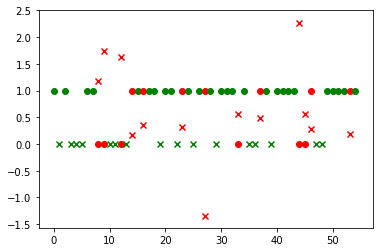

In [75]:
predict(train_X, train_y)